# Dataset

In [1]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy, csv, math
import matplotlib.pyplot as plt
import numpy as np


# tube.csv에 수술 시점 weight, height 추가
df0 = pd.read_csv('tube.csv')
df0.drop(columns=['weight', 'height'], inplace=True)
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 1, 'weight'] = None
df.loc[df['weight'] > 200, 'weight'] = None
df.loc[df['height'] <= 30, 'height'] = None
df.loc[df['height'] > 230, 'height'] = None
df['age'] = df['age'].astype(int)
df = df.loc[df['airway_tube_type'] == 'plain']
# [nan 'plain' 'RAE(oral)' 'reinforced' 'LMA' 'T-tube' 'CobraPLA', 'double lumen tube' 'RAE(nasal)' 'laser' 'combitube' 'univent']

# age, sex, airway tube size 값이 없는 경우는 제외
df.dropna(subset=['age', 'airway_tube_size'], inplace=True)
df['sex'] = (df['sex'] == 'M')

# 나이 계산 -> age_cal 열에 추가
df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')

# inclusion criteria : 소아 10세 미만
df = df.loc[df['age_cal'] < 10-0.01]
df = df.loc[df['age_cal'] > 0]
df['age'] = df['age_cal'].apply(lambda x: math.floor(x))


# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')

# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')


perc = np.mean(df['cuffed'].values)
print(f'소아 10세 미만에서 cuffed ETT 사용 비율: {perc:.3f}')
print(f'소아 10세 미만 최종 opid수: {len(df)}')

중복되는 hid는 첫번째 수술 외 제외: 34042
소아 10세 미만에서 cuffed ETT 사용 비율: 0.287
소아 10세 미만 최종 opid수: 34042


## Outlier 제거

## Train, test split

In [2]:
import math

# age-based formula에 따른 ETT size
OLD_VAR = 'old_tube_size'
# df[OLD_VAR] = np.round((df['age'] / 4 + 4) * 2) / 2
df[OLD_VAR] = df['age'].apply(lambda x: math.floor((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)

#y_old = df[[OLD_VAR]].values.flatten().astype(float)
#y_test_old = y[-ntest:]

In [4]:
SEED = 98
INPUT_VARS = ['age_cal','sex','weight','height', 'cuffed']
TARGET_VAR = 'airway_tube_size'

random.seed(SEED)
df = shuffle(df)
df.reset_index(drop=True, inplace=True)
y = df[[TARGET_VAR]].values.flatten().astype(float)
c = df['opid'].values.flatten().astype(int)
y_old = df[[OLD_VAR]].values.flatten().astype(float)
x = df.loc[:, INPUT_VARS].values.astype(float)

# 저장하기
np.savez(f'dataset/ETT_size.npz', x=x, y=y, y_old=y_old, c=c)


# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

x_train: (27234, 5), x_test: (6808, 5)


In [3]:
dat = np.load(f'dataset/ETT_size.npz')
x, y = dat['x'], dat['y']
y_old  = dat['y_old']

# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

x_train: (27234, 5), x_test: (6808, 5)


# Cuffed model

In [11]:
train_mask = (x_train[:,4] == 1)
test_mask = (x_test[:,4] == 1)

x_train_c = x_train[train_mask][:,0:4]
y_train_c = y_train[train_mask]
x_test_c = x_test[test_mask][:,0:4]
y_test_c = y_test[test_mask]

In [12]:
# age (일단위)
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 100, 200, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 10
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                    n_jobs=-1,
                    verbose=3,
                    param_grid=param_dict, cv=nfold)
gs.fit(x_train_c, y_train_c)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test_c).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test_c, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test_c, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test_c, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test_c)
acc3 = np.mean((y_pred >= y_test_c-0.5) & (y_pred <= y_test_c+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 10 folds for each of 80 candidates, totalling 800 fits
[CV 5/5] END colsample_bytree=0.5, max_depth=3, n_estimators=25, subsample=0.5;, score=0.877 total time=   0.4s
[CV 1/5] END colsample_bytree=0.5, max_depth=3, n_estimators=75, subsample=1;, score=0.878 total time=   0.4s
[CV 2/5] END colsample_bytree=0.5, max_depth=3, n_estimators=100, subsample=0.5;, score=0.881 total time=   0.8s
[CV 2/5] END colsample_bytree=0.5, max_depth=3, n_estimators=300, subsample=1;, score=0.880 total time=   2.2s
[CV 3/5] END colsample_bytree=0.5, max_depth=4, n_estimators=300, subsample=1;, score=0.883 total time=   2.9s
[CV 4/5] END colsample_bytree=0.5, max_depth=7, n_estimators=25, subsample=0.8;, score=0.877 total time=   0.5s
[CV 2/5] END colsample_bytree=0.5, max_depth=7, n_estimators=50, subsample=1;, score=0.880 total time=   0.8s
[CV 5/5] END colsample_bytree=0.5, max_depth=7, n_estimators=75, subsample=1;, score=0.874 total time=   1.3s
[CV 5/5] END colsample_bytree=0.5, max_depth=7, 

In [14]:
# save model
odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_XGBR-cuffed_{nfold}fold'
odir = f'result/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
model.save_model(f'{odir}/model.model')

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'classification model')
f.write(f'explained_variance_score: {explained_variance_score(y_test_c, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(y_test_c, y_pred):.3f}')
f.write(f'mean_absolute_errors: {mean_absolute_error(y_test_c, y_pred):.3f}')
f.write(f'r2_score: {r2_score(y_test_c, y_pred):.3f}')
f.close()

# Uncuffed model

In [15]:
train_mask = (x_train[:,4] == 0)
test_mask = (x_test[:,4] == 0)

x_train_c = x_train[train_mask][:,0:4]
y_train_c = y_train[train_mask]
x_test_c = x_test[test_mask][:,0:4]
y_test_c = y_test[test_mask]

In [16]:
# age (일단위)
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 100, 200, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 5
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                    n_jobs=-1,
                    verbose=3,
                    param_grid=param_dict, cv=nfold)
gs.fit(x_train_c, y_train_c)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test_c).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test_c, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test_c, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test_c, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test_c)
acc3 = np.mean((y_pred >= y_test_c-0.5) & (y_pred <= y_test_c+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 5/5] END colsample_bytree=0.5, max_depth=3, n_estimators=75, subsample=0.5;, score=0.878 total time=   1.2s
[CV 5/5] END colsample_bytree=0.5, max_depth=3, n_estimators=300, subsample=1;, score=0.877 total time=   2.2s
[CV 5/5] END colsample_bytree=0.5, max_depth=4, n_estimators=300, subsample=1;, score=0.875 total time=   2.9s
[CV 1/5] END colsample_bytree=0.5, max_depth=7, n_estimators=25, subsample=0.8;, score=0.877 total time=   0.5s
[CV 3/5] END colsample_bytree=0.5, max_depth=7, n_estimators=50, subsample=0.8;, score=0.882 total time=   0.9s
[CV 2/5] END colsample_bytree=0.5, max_depth=7, n_estimators=100, subsample=0.5;, score=0.873 total time=   1.8s
[CV 5/5] END colsample_bytree=0.5, max_depth=7, n_estimators=300, subsample=1;, score=0.866 total time=   4.9s
[CV 3/5] END colsample_bytree=0.8, max_depth=4, n_estimators=75, subsample=0.5;, score=0.885 total time=   1.4s
[CV 4/5] END colsample_bytree=0.8, max_depth

In [17]:
# save model
odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_XGBR-uncuffed_{nfold}fold'
odir = f'result/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
model.save_model(f'{odir}/model.model')

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'classification model')
f.write(f'explained_variance_score: {explained_variance_score(y_test_c, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(y_test_c, y_pred):.3f}')
f.write(f'mean_absolute_errors: {mean_absolute_error(y_test_c, y_pred):.3f}')
f.write(f'r2_score: {r2_score(y_test_c, y_pred):.3f}')
f.close()

# Cuffed + Uncuffed

## Age-based (Cole)

In [ ]:
# age-based formula - Cole's formula에 따른 ETT size
OLD_VAR = 'old_tube_size'
# df[OLD_VAR] = np.round((df['age'] / 4 + 4) * 2) / 2
df[OLD_VAR] = df['age'].apply(lambda x: math.floor((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)

In [8]:
print('--------------')
print('old model = age/4+4')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')
# accuracy
acc1 = np.mean(y_test_old==y_test)
acc3 = np.mean((y_test_old >= y_test-0.5) & (y_test_old <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
old model = age/4+4
--------------
explained_variance_score: 0.819
mean_squared_errors: 0.272
mean_absolute_errors: 0.395
r2_score: 0.725
acc: 0.344
acc(+-0.5mm): 0.878


In [ ]:
# Khine
{0: 3.0, 1:3.5, 2: 3.5, 3: 4, 4: 4}

### age 내림으로 수정

In [59]:
[math.floor((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4) for x in range(0,6)]

[3.5, 4, 4.5, 4.5, 5.0, 5.0]

In [52]:
import math
df_cole = pd.DataFrame({'age_cal':x_test[:,0], 'cuffed':x_test[:,4]})
df_cole['age'] = df_cole['age_cal'].apply(lambda x: math.floor(x))

OLD_VAR = 'old_tube_size'
df_cole[OLD_VAR] = df_cole['age'].apply(lambda x: math.floor((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
df_cole[OLD_VAR] = df_cole.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)

y_old = df_cole[[OLD_VAR]].values.flatten().astype(float)
y_test_old = y_old[-ntest:]


print('--------------')
print('old model = age/4+4')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')
# accuracy
acc1 = np.mean(y_test_old==y_test)
acc3 = np.mean((y_test_old >= y_test-0.5) & (y_test_old <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
old model = age/4+4
--------------
explained_variance_score: 0.817
mean_squared_errors: 0.321
mean_absolute_errors: 0.449
r2_score: 0.676
acc: 0.276
acc(+-0.5mm): 0.841


In [61]:
cuff_mask = x_test[:,4] == 1

y_test_old1 = y_test_old[cuff_mask]
y_test1 = y_test[cuff_mask]

print('--------------')
print('old model for cuffed = age/4+3.5')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test1, y_test_old1):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test1, y_test_old1):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test1, y_test_old1):.3f}')
print(f'r2_score: {r2_score(y_test1, y_test_old1):.3f}')
# accuracy
acc1 = np.mean(y_test_old1==y_test1)
acc3 = np.mean((y_test_old1 >= y_test1-0.5) & (y_test_old1 <= y_test1+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
old model for cuffed = age/4+3.5
--------------
explained_variance_score: 0.873
mean_squared_errors: 0.302
mean_absolute_errors: 0.419
r2_score: 0.728
acc: 0.318
acc(+-0.5mm): 0.870


In [63]:
cuff_mask = x_test[:,4] == 1

y_test_old1 = y_test_old[~cuff_mask]
y_test1 = y_test[~cuff_mask]

print('--------------')
print('old model for uncuffed = age/4+3.5')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test1, y_test_old1):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test1, y_test_old1):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test1, y_test_old1):.3f}')
print(f'r2_score: {r2_score(y_test1, y_test_old1):.3f}')
# accuracy
acc1 = np.mean(y_test_old1==y_test1)
acc3 = np.mean((y_test_old1 >= y_test1-0.5) & (y_test_old1 <= y_test1+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
old model for uncuffed = age/4+3.5
--------------
explained_variance_score: 0.791
mean_squared_errors: 0.328
mean_absolute_errors: 0.461
r2_score: 0.649
acc: 0.259
acc(+-0.5mm): 0.829


In [53]:
xvals = []
yvals = []
cvals = []
cvals_old = []
for x in np.arange(3, 8, 0.5):
    for y in np.arange(3, 8, 0.5):
        xvals.append(x)
        yvals.append(y)
        #cvals.append(sum((y_pred == x) & (y_test == y)))
        cvals_old.append(sum((y_test_old == x) & (y_test == y)))
xvals = np.array(xvals)
yvals = np.array(yvals)
#cvals = np.array(cvals) / 2
cvals_old = np.array(cvals_old) / 2

plt.figure(figsize=(8, 8))
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='red', alpha=0.5, s=cvals_old, label='4+AGE/4')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
plt.plot([2,8], [2,8], 'k-', alpha=0.1)
plt.plot([2.5,8], [2,7.5], '--k', alpha=0.1)
plt.plot([2,7.5], [2.5,8], '--k', alpha=0.1)
plt.savefig('old_내림.png')
plt.close()

## XGBR

In [9]:
# age (일단위)
param_dict = {
                #'learning_rate': [ 0.01, 0.03, 0.05, 0.07] #, #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 75, 100, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8, 1], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8, 1], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 10
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                n_jobs=-1,
                verbose=3,
                param_grid=param_dict, cv=nfold)
gs.fit(x_train, y_train)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
[CV 2/5] END colsample_bytree=0.5, max_depth=3, n_estimators=50, subsample=0.5;, score=0.881 total time=   0.7s
[CV 4/5] END colsample_bytree=0.5, max_depth=3, n_estimators=100, subsample=0.5;, score=0.878 total time=   0.7s
[CV 5/5] END colsample_bytree=0.5, max_depth=3, n_estimators=300, subsample=0.8;, score=0.877 total time=   2.5s
[CV 2/5] END colsample_bytree=0.5, max_depth=5, n_estimators=25, subsample=0.8;, score=0.881 total time=   0.4s
[CV 1/5] END colsample_bytree=0.5, max_depth=5, n_estimators=50, subsample=1;, score=0.878 total time=   0.7s
[CV 5/5] END colsample_bytree=0.5, max_depth=5, n_estimators=100, subsample=0.5;, score=0.875 total time=   2.3s
[CV 3/5] END colsample_bytree=0.5, max_depth=7, n_estimators=75, subsample=0.5;, score=0.878 total time=   1.5s
[CV 1/5] END colsample_bytree=0.5, max_depth=7, n_estimators=100, subsample=1;, score=0.873 total time=   2.1s
[CV 2/5] END colsample_bytree=0.8, max_

In [10]:
# save model
odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_XGBR_{nfold}fold'
odir = f'result/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
model.save_model(f'{odir}/model.model')

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'classification model')
f.write(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
f.write(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
f.write(f'r2_score: {r2_score(y_test, y_pred):.3f}')
f.close()

### Sex 제외 (4 inputs)

In [4]:
x_train = np.concatenate((x_train[:,0:1], x_train[:,2:5]),axis=-1)
x_test = np.concatenate((x_test[:,0:1], x_test[:,2:5]),axis=-1)

print(f'x_train: {x_train.shape}, x_test: {x_test.shape}')

x_train: (27234, 4), x_test: (6808, 4)


In [5]:
# age (일단위)
param_dict = {
                #'learning_rate': [ 0.01, 0.03, 0.05, 0.07] #, #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 75, 100, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8, 1], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8, 1], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 10
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                n_jobs=-1,
                verbose=3,
                param_grid=param_dict, cv=nfold)
gs.fit(x_train, y_train)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 10 folds for each of 180 candidates, totalling 1800 fits

========= found hyperparameter =========
{'colsample_bytree': 0.8, 'max_depth': 5, 'n_estimators': 25, 'subsample': 1}
0.8819567888550919
--------------
new model
--------------
explained_variance_score: 0.863
mean_squared_errors: 0.135
mean_absolute_errors: 0.220
r2_score: 0.863
acc: 0.600
acc(+-0.5mm): 0.965


In [10]:
# save model
odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_XGBR_4inputs_{nfold}fold'
odir = f'result/size/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
model.save_model(f'{odir}/model.model')

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'classification model')
f.write(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
f.write(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
f.write(f'r2_score: {r2_score(y_test, y_pred):.3f}')
f.close()

### feature importance

In [4]:
# xgbr에 내장된 함수 이용
xgbr = xgb.XGBRegressor()
xgbr.load_model('result/size/acc1-0.601_acc3-0.966_XGBR_10fold/model.model')

index_list = ['age', 'sex', 'weight', 'height', 'cuffed'] # xgbr.get_booster().feature_names
df_imp = pd.DataFrame({'imp':xgbr.feature_importances_}, index = index_list)
df_imp = df_imp[df_imp.imp > 0].sort_values('imp').copy()

feat_num = df_imp.shape[0]
print("total number of features =", feat_num)
df_imp

total number of features = 5


/home/painstudy/.local/lib/python3.8/site-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


imp
sex     0.002337
height  0.025891
weight  0.056897
cuffed  0.098848
age     0.816028

In [8]:
import sys

# 모듈 yaml이 설치된 path를 지정
sys.path.append('/home/painstudy/anaconda3/lib/python3.9/site-packages')
sys.path.append('/home/painstudy/anaconda3/envs/keras/bin/python')

In [9]:
# feature selection using BorutaShap
from BorutaShap import BorutaShap
from sklearn.base import clone

model_BS = clone(model)
Feature_Selector = BorutaShap(model=xgbr, 
                              importance_measure='shap', 
                              classification=False, 
                              percentile=100, 
                              pvalue=0.05)

Feature_Selector.fit(X=X_train, 
                     y=y_train, 
                     n_trials=100, 
                     sample=False, 
                     train_or_test = 'train', 
                     normalize=True, 
                     verbose=False, 
                     random_state=SEED)

# boruta plot
Feature_Selector.plot(X_size=15,
                       which_features='all')

ImportError: Numba could not be imported.
If you are seeing this message and are undertaking Numba development work, you may need to re-run:

python setup.py build_ext --inplace

(Also, please check the development set up guide https://numba.pydata.org/numba-doc/latest/developer/contributing.html.)

If you are not working on Numba development:

Please report the error message and traceback, along with a minimal reproducer
at: https://github.com/numba/numba/issues/new

If more help is needed please feel free to speak to the Numba core developers
directly at: https://gitter.im/numba/numba

Thanks in advance for your help in improving Numba!

The original error was: 'cannot import name '_typeconv' from 'numba.core.typeconv' (/home/painstudy/anaconda3/lib/python3.9/site-packages/numba/core/typeconv/__init__.py)'
--------------------------------------------------------------------------------
If possible please include the following in your error report:

sys.executable: /home/painstudy/anaconda3/envs/keras/bin/python


### < 1 years (new born + infant)

In [13]:
inf_mask = x_train[:,0] < 1
x_train_inf = x_train[inf_mask]
y_train_inf = y_train[inf_mask]

inf_mask = x_test[:,0] < 1
x_test_inf = x_test[inf_mask]
y_test_inf = y_test[inf_mask]

In [14]:
# age (일단위)
param_dict = {
                #'learning_rate': [ 0.01, 0.03, 0.05, 0.07] #, #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 75, 100, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8, 1], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8, 1], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 10
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                n_jobs=-1,
                verbose=3,
                param_grid=param_dict, cv=nfold)
gs.fit(x_train_inf, y_train_inf)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test_inf).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test_inf, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test_inf, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test_inf, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test_inf, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test_inf)
acc3 = np.mean((y_pred >= y_test_inf-0.5) & (y_pred <= y_test_inf+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 10 folds for each of 180 candidates, totalling 1800 fits

========= found hyperparameter =========
{'colsample_bytree': 0.8, 'max_depth': 3, 'n_estimators': 25, 'subsample': 0.8}
0.586124199643337
--------------
new model
--------------
explained_variance_score: 0.504
mean_squared_errors: 0.122
mean_absolute_errors: 0.196
r2_score: 0.502
acc: 0.642
acc(+-0.5mm): 0.975
[CV 3/10] END colsample_bytree=0.5, max_depth=3, n_estimators=25, subsample=0.8;, score=0.583 total time=   0.9s
[CV 10/10] END colsample_bytree=0.5, max_depth=3, n_estimators=75, subsample=0.5;, score=0.560 total time=   0.2s
[CV 9/10] END colsample_bytree=0.5, max_depth=3, n_estimators=100, subsample=0.5;, score=0.595 total time=   0.3s
[CV 10/10] END colsample_bytree=0.5, max_depth=3, n_estimators=300, subsample=0.8;, score=0.563 total time=   0.8s
[CV 10/10] END colsample_bytree=0.5, max_depth=4, n_estimators=75, subsample=1;, score=0.563 total time=   0.2s
[CV 9/10] END colsample_bytree=0.5, max_depth=4, n_es

### 1 <= age <= 6 years (Toddler, )

In [21]:
age_mask = (1 <= x_train[:,0]) & (x_train[:,0] < 7)
x_train_age = x_train[age_mask]
y_train_age = y_train[age_mask]

age_mask = (1 <= x_test[:,0]) & (x_test[:,0] < 7)
x_test_age = x_test[age_mask]
y_test_age = y_test[age_mask]

In [22]:
# age (일단위)
param_dict = {
                #'learning_rate': [ 0.01, 0.03, 0.05, 0.07] #, #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 75, 100, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8, 1], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8, 1], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 10
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                n_jobs=-1,
                verbose=3,
                param_grid=param_dict, cv=nfold)
gs.fit(x_train_age, y_train_age)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test_age).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test_age, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test_age, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test_age, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test_age, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test_age)
acc3 = np.mean((y_pred >= y_test_age-0.5) & (y_pred <= y_test_age+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
[CV 5/10] END colsample_bytree=0.5, max_depth=3, n_estimators=25, subsample=0.8;, score=0.723 total time=   1.0s
[CV 2/10] END colsample_bytree=0.5, max_depth=3, n_estimators=75, subsample=0.8;, score=0.688 total time=   0.4s
[CV 10/10] END colsample_bytree=0.5, max_depth=3, n_estimators=100, subsample=0.8;, score=0.696 total time=   0.5s
[CV 8/10] END colsample_bytree=0.5, max_depth=4, n_estimators=25, subsample=0.5;, score=0.698 total time=   0.2s
[CV 10/10] END colsample_bytree=0.5, max_depth=4, n_estimators=25, subsample=0.8;, score=0.690 total time=   0.2s
[CV 10/10] END colsample_bytree=0.5, max_depth=4, n_estimators=25, subsample=1;, score=0.697 total time=   0.2s
[CV 10/10] END colsample_bytree=0.5, max_depth=4, n_estimators=50, subsample=0.5;, score=0.697 total time=   0.3s
[CV 10/10] END colsample_bytree=0.5, max_depth=4, n_estimators=50, subsample=0.8;, score=0.696 total time=   0.3s
[CV 10/10] END colsample_by

In [23]:
print('--------------')
print('new model 1<=age<=6 years')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test_age, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test_age, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test_age, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test_age, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test_age)
acc3 = np.mean((y_pred >= y_test_age-0.5) & (y_pred <= y_test_age+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
new model 1<=age<=6 years
--------------
explained_variance_score: 0.673
mean_squared_errors: 0.141
mean_absolute_errors: 0.226
r2_score: 0.673
acc: 0.592
acc(+-0.5mm): 0.961


### 6 < age < 10

In [25]:
age_mask = (6 < x_train[:,0])
x_train_age = x_train[age_mask]
y_train_age = y_train[age_mask]

age_mask = (6 < x_test[:,0])
x_test_age = x_test[age_mask]
y_test_age = y_test[age_mask]

In [26]:
# age (일단위)
param_dict = {
                #'learning_rate': [ 0.01, 0.03, 0.05, 0.07] #, #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 75, 100, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8, 1], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8, 1], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 10
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                n_jobs=-1,
                verbose=3,
                param_grid=param_dict, cv=nfold)
gs.fit(x_train_age, y_train_age)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test_age).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model 6<age<10')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test_age, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test_age, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test_age, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test_age, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test_age)
acc3 = np.mean((y_pred >= y_test_age-0.5) & (y_pred <= y_test_age+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 10 folds for each of 180 candidates, totalling 1800 fits

========= found hyperparameter =========
{'colsample_bytree': 0.5, 'max_depth': 3, 'n_estimators': 25, 'subsample': 1}
0.36741212303996496
--------------
new model 6<age<10
--------------
explained_variance_score: 0.305
mean_squared_errors: 0.147
mean_absolute_errors: 0.233
r2_score: 0.304
acc: 0.578
acc(+-0.5mm): 0.962


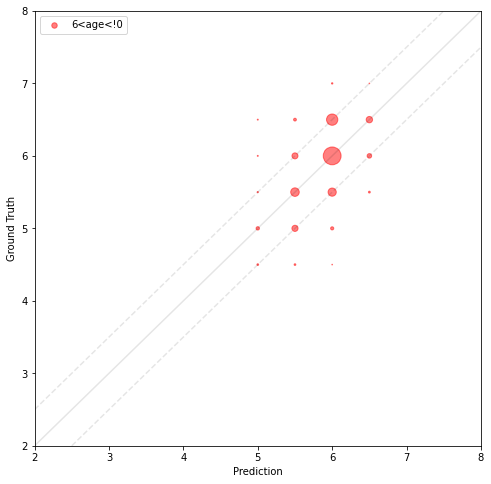

[CV 7/10] END colsample_bytree=0.5, max_depth=3, n_estimators=25, subsample=0.8;, score=0.349 total time=   0.8s
[CV 10/10] END colsample_bytree=0.5, max_depth=3, n_estimators=75, subsample=0.8;, score=0.394 total time=   0.2s
[CV 9/10] END colsample_bytree=0.5, max_depth=3, n_estimators=100, subsample=0.8;, score=0.306 total time=   0.2s
[CV 8/10] END colsample_bytree=0.5, max_depth=3, n_estimators=300, subsample=1;, score=0.339 total time=   0.6s
[CV 4/10] END colsample_bytree=0.5, max_depth=4, n_estimators=75, subsample=1;, score=0.334 total time=   0.2s
[CV 8/10] END colsample_bytree=0.5, max_depth=4, n_estimators=100, subsample=0.8;, score=0.345 total time=   0.3s
[CV 5/10] END colsample_bytree=0.5, max_depth=5, n_estimators=25, subsample=0.5;, score=0.350 total time=   0.1s
[CV 5/10] END colsample_bytree=0.5, max_depth=5, n_estimators=25, subsample=0.8;, score=0.347 total time=   0.1s
[CV 5/10] END colsample_bytree=0.5, max_depth=5, n_estimators=25, subsample=1;, score=0.354 tota

In [27]:
xvals = []
yvals = []
cvals = []
cvals_old = []
for x in np.arange(3, 8, 0.5):
    for y in np.arange(3, 8, 0.5):
        xvals.append(x)
        yvals.append(y)
        cvals.append(sum((y_pred == x) & (y_test_age == y)))
xvals = np.array(xvals)
yvals = np.array(yvals)
cvals = np.array(cvals) / 2


plt.figure(figsize=(8, 8))
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='red', alpha=0.5, s=cvals, label='6<age<!0')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
plt.plot([2,8], [2,8], 'k-', alpha=0.1)
plt.plot([2.5,8], [2,7.5], '--k', alpha=0.1)
plt.plot([2,7.5], [2.5,8], '--k', alpha=0.1)

## RF

In [14]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

In [32]:
from sklearn.ensemble import RandomForestRegressor

SEED = 98
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'n_estimators': [50, 100, 200, 300],
                'max_features': ['auto', 'sqrt', 'log2'],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'min_samples_split': [2,3,5],
                'min_samples_leaf': [1,2,3],
               'bootstrap': [True, False]
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 10
gs = GridSearchCV(estimator=RandomForestRegressor(random_state = SEED),
                    n_jobs=-1,
                    verbose=5,
                    param_grid=param_dict, cv=nfold)
gs.fit(x_train_imputed, y_train)
#model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test_imputed).flatten()
y_pred = np.round(y_pred * 2) / 2

print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
[CV 3/10] END bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.872 total time=   6.7s
[CV 10/10] END bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=50;, score=0.870 total time=   5.1s
[CV 9/10] END bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=200;, score=0.873 total time=  19.0s
[CV 3/10] END bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=0.874 total time=  30.3s
[CV 8/10] END bootstrap=True, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=200;, score=0.873 total time=  20.0s
[CV 3/10] END bootstrap=True, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50;, score=0.875 total time=   5.0s
[CV 4/10] END bootstrap=True, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estim

In [33]:
print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

# save model
odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_RF_{nfold}fold'
odir = f'result/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
#model.save_model(f'{odir}/model.model')
pickle.dump(gs, open(f'{odir}/gridSearch','wb'))

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'classification model')
f.write(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
f.write(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
f.write(f'r2_score: {r2_score(y_test, y_pred):.3f}')
f.close()

--------------
new model
--------------
explained_variance_score: 0.860
mean_squared_errors: 0.139
mean_absolute_errors: 0.224
r2_score: 0.860
acc: 0.595
acc(+-0.5mm): 0.963


### Sex 제외 (4 inputs)

In [ ]:
x_train = np.concatenate((x_train[:,0:1], x_train[:,2:5]),axis=-1)
x_test = np.concatenate((x_test[:,0:1], x_test[:,2:5]),axis=-1)

print(f'x_train: {x_train.shape}, x_test: {x_test.shape}')

In [15]:
from sklearn.ensemble import RandomForestRegressor

SEED = 98
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'n_estimators': [50, 100, 200, 300],
                'max_features': ['auto', 'sqrt', 'log2'],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'min_samples_split': [2,3,5],
                'min_samples_leaf': [1,2,3],
               'bootstrap': [True, False]
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 10
gs = GridSearchCV(estimator=RandomForestRegressor(random_state = SEED),
                    n_jobs=-1,
                    verbose=5,
                    param_grid=param_dict, cv=nfold)
gs.fit(x_train_imputed, y_train)
#model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test_imputed).flatten()
y_pred = np.round(y_pred * 2) / 2

print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
[CV 4/10] END bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.869 total time=   4.1s
[CV 7/10] END bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=50;, score=0.870 total time=   4.0s
[CV 3/10] END bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=100;, score=0.871 total time=   8.1s
[CV 3/10] END bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=300;, score=0.872 total time=  24.5s
[CV 4/10] END bootstrap=True, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=50;, score=0.874 total time=   3.9s
[CV 5/10] END bootstrap=True, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.876 total time=   7.7s
[CV 4/10] END bootstrap=True, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estima

In [17]:
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")
print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')


# save model
odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_RF_4inputs_{nfold}fold'
odir = f'result/size/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
#model.save_model(f'{odir}/model.model')
pickle.dump(gs, open(f'{odir}/gridSearch','wb'))

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'classification model')
f.write(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
f.write(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
f.write(f'r2_score: {r2_score(y_test, y_pred):.3f}')
f.close()

========= found hyperparameter =========
{'bootstrap': True, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}
0.8775560996408067
--------------
new model
--------------
explained_variance_score: 0.858
mean_squared_errors: 0.140
mean_absolute_errors: 0.226
r2_score: 0.858
acc: 0.590
acc(+-0.5mm): 0.963


## DNN

In [19]:
# from keras import losses, metrics
from keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, Dropout, Activation, Input
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, concatenate, Add
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
import itertools as it
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats, interp
import os, sys, pickle, shutil
import pandas as pd
import numpy as np
import random, datetime, time
from sklearn.model_selection import KFold


# tensorflow 사용 시 seed 고정
def seed_everything(seed: int = 98):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    
SEED = 98
os.environ["CUDA_VISIBLE_DEVICES"]= "3"

In [21]:
dat = np.load(f'dataset/ETT_size.npz')
x, y = dat['x'], dat['y']
#y_old  = dat['y_old']

# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
#y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

x_train: (27234, 5), x_test: (6808, 5)


In [22]:
x_train = np.concatenate((x_train[:,0:1], x_train[:,2:5]),axis=-1)
x_test = np.concatenate((x_test[:,0:1], x_test[:,2:5]),axis=-1)

print(f'x_train: {x_train.shape}, x_test: {x_test.shape}')

x_train: (27234, 4), x_test: (6808, 4)


In [23]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(pd.DataFrame(x_train))
x_test = sc.transform(pd.DataFrame(x_test))

In [24]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

In [25]:
# folder
nfold = 10  # 각각의 hyperparameter에 대해 k-fold 를 시행하고 평균을 구한다.
ntest = 500
rootdir = f"result/size/DNN_size_4inputs"

if not os.path.exists(rootdir):
    os.mkdir(rootdir)

# 모델에 대한 정보 txt로 저장
f = open(f'{rootdir}/README.txt', 'w')
f.write(f'model: DNN 2 layers, regression')
f.write(f'input: age, sex, height, weight, cuffed 유무  output: tube size')
f.close()
    

# test_settings
layer_settings, test_settings = [], []


# hyperparamters pool
dropout_opts  = [0, 0.1, 0.2, 0.3, 0.4, 0.5] # dropout rate
dense_opts = [16, 32, 64, 128, 256, 512]
BATCH_SIZE = [32, 64, 128, 256, 512]
lr_opts = [0.001, 0.002, 0.0005]

print('start making test settings...', end='', flush=True)
# test settings
dnodes, dropouts = [], []
for i in range(2):
    dnodes.append(0)
    dropouts.append(0)


for dnode1 in dense_opts:
    for dropout1 in dropout_opts:
        for dnode2 in dense_opts:
            for dropout2 in dropout_opts:
                for batch_size in BATCH_SIZE:
                    for learning_rate in lr_opts:
                        test_settings.append([dnode1, dropout1, dnode2, dropout2, batch_size, learning_rate])                                   

                        
print('done')
print(datetime.datetime.now())

start making test settings...done
2023-02-22 18:01:51.562222


In [26]:
from keras import metrics

seed_everything(SEED)

# random search for hyperparameter
ntrial = ntest
train_errs, val_errs = [] ,[]
test_acc, test_roc, test_prc = [], [], []
#test_rmse, test_mae, test_auc = [], [], []
random_settings = []


for itrial in range(ntrial):
    # grid search
    # test_setting = test_settings[itrial]

    # random search
    print('random search {}/{}'.format(itrial, ntrial))
    
    # total conv layers of the model
    nlayer = random.choice([1,2]) 
    # test settings
    dnodes[0], dropouts[0], dnodes[1], dropouts[1], batch_size, learning_rate = random.choice(test_settings)
    

    # 이번 옵션에 대한 결과 디렉토리
    odir_f = f'batch{batch_size},'
    for i in range(nlayer):
        odir_f += f'dnodes{dnodes[i]}_dropout{dropouts[i]},'
    odir_f += f'lr{learning_rate}'
    random_settings.append(odir_f)
    
    odir = rootdir + '/' + odir_f
    if not os.path.exists(odir):
        os.mkdir(odir)


    # build a model
    inp = Input(shape=(x_train.shape[1],))
    out = inp

    
    for i in range(nlayer):      
        out = Dense(dnodes[i], activation='relu')(out)
        out = Dropout(dropouts[i])(out)
    
    out = Dense(1)(out)


    model = Model(inputs=[inp], outputs=[out])
    model.save_weights(f'{odir}/initial_weights.hdf5')
        

    # 4-fold cv
    kfold = KFold(nfold)
    acc1s, acc3s, maes = [], [], []

    switch = 0
    for fold, (train_mask, test_mask) in enumerate(kfold.split(y_train)):
        X_train = x_train_imputed[train_mask]
        X_test = x_train_imputed[test_mask] 
        
        Y_train = y_train[train_mask] 
        Y_test = y_train[test_mask]


        # model 학습
        try:
            weightcache = f"{odir}/weights_{fold}.hdf5"
            model.compile(loss='mse', optimizer=Adam(lr=learning_rate), metrics=[])
            hist = model.fit(X_train, Y_train, validation_split=0.2, epochs=100, batch_size=batch_size, #class_weight={0:1, 1:3}, 
                                    callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weightcache, verbose=1, save_best_only=True),
                                                EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

            model.load_weights(weightcache)
            y_pred = model.predict(X_test).flatten() 
            y_pred = np.round(y_pred * 2) / 2
            
            acc1 = np.mean(y_pred==Y_test)
            acc3 = np.mean((y_pred >= Y_test-0.5) & (y_pred <= Y_test+0.5))
            mae = mean_absolute_error(Y_test, y_pred)           
            
            acc1s.append(acc1)
            acc3s.append(acc3)
            maes.append(mae)

            print(f' ###{fold} fold : val acc1 {acc1:.3f}, acc3 {acc3:.3f}, mae {mae:.3f}###')
            tf.keras.backend.clear_session()
            model.load_weights(f'{odir}/initial_weights.hdf5')

        except Exception as e:
            print(e)
            switch = 1
            shutil.rmtree(odir)
            itrial -= 1
            break

    if switch:
        switch = 0
        continue
    

    print(f'acc1{np.mean(acc1s):.3f}_acc3{np.mean(acc3s):.3f}')
    open(odir+"/model.json", "wt").write(model.to_json())

    os.rename(odir, rootdir+f'/acc1-{np.mean(acc1s):.3f}_acc3-{np.mean(acc3s):.3f}_{odir_f}')
    tf.keras.backend.clear_session()

random search 0/500


2023-02-22 18:01:54.169904: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 18:01:56.698342: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30702 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:07:00.0, compute capability: 7.0
2023-02-22 18:01:56.699086: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 142 MB memory:  -> device: 1, name: Tesla V100-DGXS-32GB, pci bus id: 0000:08:00.0, compute capability: 7.0
2023-02-22 18:01:56.699774: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:G

Epoch 1/100
603/613 [============================>.] - ETA: 0s - loss: 1.0406
Epoch 00001: val_loss improved from inf to 0.20052, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_0.hdf5
613/613 [==============================] - 4s 4ms/step - loss: 1.0303 - val_loss: 0.2005
Epoch 2/100
607/613 [============================>.] - ETA: 0s - loss: 0.2603
Epoch 00002: val_loss improved from 0.20052 to 0.14903, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_0.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 0.2600 - val_loss: 0.1490
Epoch 3/100
606/613 [============================>.] - ETA: 0s - loss: 0.2595
Epoch 00003: val_loss did not improve from 0.14903
613/613 [==============================] - 3s 4ms/step - loss: 0.2594 - val_loss: 0.1811
Epoch 4/100
601/613 [============================>.] - ETA: 0s - loss: 0.2903
Epoch 00004: val_loss impr

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


613/613 [==============================] - ETA: 0s - loss: 0.9367
Epoch 00001: val_loss improved from inf to 0.18640, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_1.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 0.9367 - val_loss: 0.1864
Epoch 2/100
602/613 [============================>.] - ETA: 0s - loss: 0.2554
Epoch 00002: val_loss improved from 0.18640 to 0.13518, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_1.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 0.2550 - val_loss: 0.1352
Epoch 3/100
605/613 [============================>.] - ETA: 0s - loss: 0.2533
Epoch 00003: val_loss did not improve from 0.13518
613/613 [==============================] - 2s 4ms/step - loss: 0.2536 - val_loss: 0.2230
Epoch 4/100
604/613 [============================>.] - ETA: 0s - loss: 0.2780
Epoch 00004: val_loss did not improve 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


600/613 [============================>.] - ETA: 0s - loss: 0.9886
Epoch 00001: val_loss improved from inf to 0.16928, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_2.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 0.9748 - val_loss: 0.1693
Epoch 2/100
613/613 [==============================] - ETA: 0s - loss: 0.2520
Epoch 00002: val_loss improved from 0.16928 to 0.13865, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_2.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.2520 - val_loss: 0.1387
Epoch 3/100
609/613 [============================>.] - ETA: 0s - loss: 0.2638
Epoch 00003: val_loss did not improve from 0.13865
613/613 [==============================] - 2s 4ms/step - loss: 0.2638 - val_loss: 0.2599
Epoch 4/100
610/613 [============================>.] - ETA: 0s - loss: 0.2930
Epoch 00004: val_loss did not improve 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


605/613 [============================>.] - ETA: 0s - loss: 0.9429
Epoch 00001: val_loss improved from inf to 0.15699, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_3.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 0.9359 - val_loss: 0.1570
Epoch 2/100
613/613 [==============================] - ETA: 0s - loss: 0.2519
Epoch 00002: val_loss improved from 0.15699 to 0.13940, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_3.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 0.2519 - val_loss: 0.1394
Epoch 3/100
609/613 [============================>.] - ETA: 0s - loss: 0.2560
Epoch 00003: val_loss did not improve from 0.13940
613/613 [==============================] - 2s 4ms/step - loss: 0.2560 - val_loss: 0.2162
Epoch 4/100
610/613 [============================>.] - ETA: 0s - loss: 0.2488
Epoch 00004: val_loss did not improve 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


600/613 [============================>.] - ETA: 0s - loss: 0.7709
Epoch 00001: val_loss improved from inf to 0.18045, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_4.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 0.7602 - val_loss: 0.1805
Epoch 2/100
607/613 [============================>.] - ETA: 0s - loss: 0.4303
Epoch 00002: val_loss improved from 0.18045 to 0.14017, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_4.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.4283 - val_loss: 0.1402
Epoch 3/100
603/613 [============================>.] - ETA: 0s - loss: 0.2399
Epoch 00003: val_loss improved from 0.14017 to 0.13112, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_4.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 0.2392 - val_loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


601/613 [============================>.] - ETA: 0s - loss: 0.5810
Epoch 00001: val_loss improved from inf to 0.18942, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_5.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 0.5746 - val_loss: 0.1894
Epoch 2/100
601/613 [============================>.] - ETA: 0s - loss: 0.2428
Epoch 00002: val_loss improved from 0.18942 to 0.17425, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_5.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.2425 - val_loss: 0.1742
Epoch 3/100
609/613 [============================>.] - ETA: 0s - loss: 0.2113
Epoch 00003: val_loss improved from 0.17425 to 0.13886, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_5.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.2111 - val_loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


606/613 [============================>.] - ETA: 0s - loss: 1.1771
Epoch 00001: val_loss improved from inf to 0.15684, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_6.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 1.1669 - val_loss: 0.1568
Epoch 2/100
610/613 [============================>.] - ETA: 0s - loss: 0.3332
Epoch 00002: val_loss did not improve from 0.15684
613/613 [==============================] - 2s 4ms/step - loss: 0.3329 - val_loss: 0.1801
Epoch 3/100
612/613 [============================>.] - ETA: 0s - loss: 0.2824
Epoch 00003: val_loss improved from 0.15684 to 0.13318, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_6.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 0.2823 - val_loss: 0.1332
Epoch 4/100
600/613 [============================>.] - ETA: 0s - loss: 0.2475
Epoch 00004: val_loss did not improve 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


613/613 [==============================] - ETA: 0s - loss: 1.1281
Epoch 00001: val_loss improved from inf to 0.15601, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_7.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 1.1281 - val_loss: 0.1560
Epoch 2/100
603/613 [============================>.] - ETA: 0s - loss: 0.3422
Epoch 00002: val_loss did not improve from 0.15601
613/613 [==============================] - 2s 4ms/step - loss: 0.3414 - val_loss: 0.1713
Epoch 3/100
599/613 [============================>.] - ETA: 0s - loss: 0.3178
Epoch 00003: val_loss improved from 0.15601 to 0.13888, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_7.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.3155 - val_loss: 0.1389
Epoch 4/100
613/613 [==============================] - ETA: 0s - loss: 0.3055
Epoch 00004: val_loss did not improve 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


610/613 [============================>.] - ETA: 0s - loss: 1.1399
Epoch 00001: val_loss improved from inf to 0.15300, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_8.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 1.1359 - val_loss: 0.1530
Epoch 2/100
602/613 [============================>.] - ETA: 0s - loss: 0.3421
Epoch 00002: val_loss did not improve from 0.15300
613/613 [==============================] - 2s 4ms/step - loss: 0.3412 - val_loss: 0.1564
Epoch 3/100
607/613 [============================>.] - ETA: 0s - loss: 0.3279
Epoch 00003: val_loss improved from 0.15300 to 0.14215, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_8.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.3267 - val_loss: 0.1422
Epoch 4/100
607/613 [============================>.] - ETA: 0s - loss: 0.3024
Epoch 00004: val_loss did not improve 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


606/613 [============================>.] - ETA: 0s - loss: 1.1460
Epoch 00001: val_loss improved from inf to 0.15256, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_9.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 1.1359 - val_loss: 0.1526
Epoch 2/100
611/613 [============================>.] - ETA: 0s - loss: 0.3414
Epoch 00002: val_loss did not improve from 0.15256
613/613 [==============================] - 2s 4ms/step - loss: 0.3412 - val_loss: 0.1578
Epoch 3/100
603/613 [============================>.] - ETA: 0s - loss: 0.3287
Epoch 00003: val_loss improved from 0.15256 to 0.14350, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_9.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.3267 - val_loss: 0.1435
Epoch 4/100
602/613 [============================>.] - ETA: 0s - loss: 0.3031
Epoch 00004: val_loss did not improve 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


70/77 [==========================>...] - ETA: 0s - loss: 19.5426
Epoch 00001: val_loss improved from inf to 14.42849, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 19.1475 - val_loss: 14.4285
Epoch 2/100
68/77 [=========================>....] - ETA: 0s - loss: 11.2301
Epoch 00002: val_loss improved from 14.42849 to 7.33068, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 10.8639 - val_loss: 7.3307
Epoch 3/100
66/77 [========================>.....] - ETA: 0s - loss: 5.4476
Epoch 00003: val_loss improved from 7.33068 to 3.37655, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 5.5059 - val_loss: 3.3765
Epoch 4/100
61/77 [======================>.......] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


60/77 [======================>.......] - ETA: 0s - loss: 20.1178
Epoch 00001: val_loss improved from inf to 14.41628, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
77/77 [==============================] - 1s 8ms/step - loss: 19.1331 - val_loss: 14.4163
Epoch 2/100
61/77 [======================>.......] - ETA: 0s - loss: 11.5677
Epoch 00002: val_loss improved from 14.41628 to 7.32009, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 10.8765 - val_loss: 7.3201
Epoch 3/100
64/77 [=======================>......] - ETA: 0s - loss: 5.5183
Epoch 00003: val_loss improved from 7.32009 to 3.36361, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 5.5215 - val_loss: 3.3636
Epoch 4/100
74/77 [===========================>..] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/77 [=========================>....] - ETA: 0s - loss: 19.7633
Epoch 00001: val_loss improved from inf to 14.40695, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 19.1535 - val_loss: 14.4069
Epoch 2/100
65/77 [========================>.....] - ETA: 0s - loss: 11.3781
Epoch 00002: val_loss improved from 14.40695 to 7.32123, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 10.8537 - val_loss: 7.3212
Epoch 3/100
64/77 [=======================>......] - ETA: 0s - loss: 5.5084
Epoch 00003: val_loss improved from 7.32123 to 3.38326, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 5.5106 - val_loss: 3.3833
Epoch 4/100
60/77 [======================>.......] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


63/77 [=======================>......] - ETA: 0s - loss: 19.9989
Epoch 00001: val_loss improved from inf to 14.43379, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 19.1370 - val_loss: 14.4338
Epoch 2/100
63/77 [=======================>......] - ETA: 0s - loss: 11.4863
Epoch 00002: val_loss improved from 14.43379 to 7.34578, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 10.8635 - val_loss: 7.3458
Epoch 3/100
61/77 [======================>.......] - ETA: 0s - loss: 5.5820
Epoch 00003: val_loss improved from 7.34578 to 3.38677, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 5.5177 - val_loss: 3.3868
Epoch 4/100
60/77 [======================>.......] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


62/77 [=======================>......] - ETA: 0s - loss: 20.0867
Epoch 00001: val_loss improved from inf to 14.35434, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 19.1376 - val_loss: 14.3543
Epoch 2/100
61/77 [======================>.......] - ETA: 0s - loss: 11.5030
Epoch 00002: val_loss improved from 14.35434 to 7.22353, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 10.7556 - val_loss: 7.2235
Epoch 3/100
71/77 [==========================>...] - ETA: 0s - loss: 5.6854
Epoch 00003: val_loss improved from 7.22353 to 3.47127, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 5.5388 - val_loss: 3.4713
Epoch 4/100
63/77 [=======================>......] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


65/77 [========================>.....] - ETA: 0s - loss: 19.8723
Epoch 00001: val_loss improved from inf to 14.32167, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 19.1219 - val_loss: 14.3217
Epoch 2/100
64/77 [=======================>......] - ETA: 0s - loss: 11.2230
Epoch 00002: val_loss improved from 14.32167 to 7.09136, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 10.6325 - val_loss: 7.0914
Epoch 3/100
65/77 [========================>.....] - ETA: 0s - loss: 5.3991
Epoch 00003: val_loss improved from 7.09136 to 3.34464, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 5.1333 - val_loss: 3.3446
Epoch 4/100
64/77 [=======================>......] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/77 [=========================>....] - ETA: 0s - loss: 19.7175
Epoch 00001: val_loss improved from inf to 14.33403, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 19.1058 - val_loss: 14.3340
Epoch 2/100
68/77 [=========================>....] - ETA: 0s - loss: 11.0003
Epoch 00002: val_loss improved from 14.33403 to 7.13283, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 10.7118 - val_loss: 7.1328
Epoch 3/100
67/77 [=========================>....] - ETA: 0s - loss: 5.6568
Epoch 00003: val_loss improved from 7.13283 to 3.45228, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 5.4168 - val_loss: 3.4523
Epoch 4/100
64/77 [=======================>......] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


60/77 [======================>.......] - ETA: 0s - loss: 20.1299
Epoch 00001: val_loss improved from inf to 14.35353, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 19.1047 - val_loss: 14.3535
Epoch 2/100
62/77 [=======================>......] - ETA: 0s - loss: 11.2941
Epoch 00002: val_loss improved from 14.35353 to 7.14500, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 10.7361 - val_loss: 7.1450
Epoch 3/100
65/77 [========================>.....] - ETA: 0s - loss: 5.6956
Epoch 00003: val_loss improved from 7.14500 to 3.44114, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 5.4100 - val_loss: 3.4411
Epoch 4/100
64/77 [=======================>......] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


61/77 [======================>.......] - ETA: 0s - loss: 20.0864
Epoch 00001: val_loss improved from inf to 14.43607, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 19.0988 - val_loss: 14.4361
Epoch 2/100
63/77 [=======================>......] - ETA: 0s - loss: 11.2394
Epoch 00002: val_loss improved from 14.43607 to 7.20521, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 10.7287 - val_loss: 7.2052
Epoch 3/100
76/77 [============================>.] - ETA: 0s - loss: 5.4208
Epoch 00003: val_loss improved from 7.20521 to 3.48078, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 5.4051 - val_loss: 3.4808
Epoch 4/100
72/77 [===========================>..] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/77 [=========================>....] - ETA: 0s - loss: 19.7130
Epoch 00001: val_loss improved from inf to 14.44746, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 19.0988 - val_loss: 14.4475
Epoch 2/100
68/77 [=========================>....] - ETA: 0s - loss: 11.0055
Epoch 00002: val_loss improved from 14.44746 to 7.20985, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 10.7287 - val_loss: 7.2098
Epoch 3/100
67/77 [=========================>....] - ETA: 0s - loss: 5.6416
Epoch 00003: val_loss improved from 7.20985 to 3.49205, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 5.4051 - val_loss: 3.4921
Epoch 4/100
67/77 [=========================>....] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


294/307 [===========================>..] - ETA: 0s - loss: 2.2986
Epoch 00001: val_loss improved from inf to 0.23014, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_0.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.2207 - val_loss: 0.2301
Epoch 2/100
303/307 [============================>.] - ETA: 0s - loss: 0.6833
Epoch 00002: val_loss did not improve from 0.23014
307/307 [==============================] - 1s 4ms/step - loss: 0.6797 - val_loss: 0.2327
Epoch 3/100
305/307 [============================>.] - ETA: 0s - loss: 0.3721
Epoch 00003: val_loss did not improve from 0.23014
307/307 [==============================] - 1s 4ms/step - loss: 0.3725 - val_loss: 0.4921
 ###0 fold : val acc1 0.446, acc3 0.897, mae 0.342###
Epoch 1/100


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


298/307 [============================>.] - ETA: 0s - loss: 2.2681
Epoch 00001: val_loss improved from inf to 0.24066, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_1.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.2155 - val_loss: 0.2407
Epoch 2/100
293/307 [===========================>..] - ETA: 0s - loss: 0.6620
Epoch 00002: val_loss improved from 0.24066 to 0.23178, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_1.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.6474 - val_loss: 0.2318
Epoch 3/100
305/307 [============================>.] - ETA: 0s - loss: 0.3680
Epoch 00003: val_loss did not improve from 0.23178
307/307 [==============================] - 1s 4ms/step - loss: 0.3685 - val_loss: 0.5264
Epoch 4/100
294/307 [===========================>..] - ETA: 0s - loss: 0.3341
Epoch 00004: val_loss did not improve fr

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


296/307 [===========================>..] - ETA: 0s - loss: 2.3045
Epoch 00001: val_loss improved from inf to 0.24020, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_2.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.2385 - val_loss: 0.2402
Epoch 2/100
303/307 [============================>.] - ETA: 0s - loss: 0.6655
Epoch 00002: val_loss improved from 0.24020 to 0.22891, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_2.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.6623 - val_loss: 0.2289
Epoch 3/100
305/307 [============================>.] - ETA: 0s - loss: 0.3694
Epoch 00003: val_loss did not improve from 0.22891
307/307 [==============================] - 1s 4ms/step - loss: 0.3698 - val_loss: 0.5030
Epoch 4/100
304/307 [============================>.] - ETA: 0s - loss: 0.3406
Epoch 00004: val_loss improved from 0.22

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


295/307 [===========================>..] - ETA: 0s - loss: 2.3234
Epoch 00001: val_loss improved from inf to 0.24738, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_3.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.2505 - val_loss: 0.2474
Epoch 2/100
297/307 [============================>.] - ETA: 0s - loss: 0.6913
Epoch 00002: val_loss improved from 0.24738 to 0.21720, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_3.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.6808 - val_loss: 0.2172
Epoch 3/100
299/307 [============================>.] - ETA: 0s - loss: 0.3073
Epoch 00003: val_loss did not improve from 0.21720
307/307 [==============================] - 1s 4ms/step - loss: 0.3609 - val_loss: 0.4468
Epoch 4/100
297/307 [============================>.] - ETA: 0s - loss: 0.3369
Epoch 00004: val_loss did not improve fr

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


296/307 [===========================>..] - ETA: 0s - loss: 2.5007
Epoch 00001: val_loss improved from inf to 0.25534, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_4.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.4288 - val_loss: 0.2553
Epoch 2/100
297/307 [============================>.] - ETA: 0s - loss: 0.4429
Epoch 00002: val_loss improved from 0.25534 to 0.24811, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_4.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.4390 - val_loss: 0.2481
Epoch 3/100
303/307 [============================>.] - ETA: 0s - loss: 0.3674
Epoch 00003: val_loss improved from 0.24811 to 0.19906, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_4.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.3661 - val_loss: 0.1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


307/307 [==============================] - ETA: 0s - loss: 2.0806
Epoch 00001: val_loss improved from inf to 0.24364, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_5.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.0806 - val_loss: 0.2436
Epoch 2/100
305/307 [============================>.] - ETA: 0s - loss: 0.3382
Epoch 00002: val_loss improved from 0.24364 to 0.23474, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_5.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.3379 - val_loss: 0.2347
Epoch 3/100
294/307 [===========================>..] - ETA: 0s - loss: 0.2953
Epoch 00003: val_loss improved from 0.23474 to 0.18254, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_5.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.2947 - val_loss: 0.1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


302/307 [============================>.] - ETA: 0s - loss: 2.2951
Epoch 00001: val_loss improved from inf to 0.26422, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_6.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.2682 - val_loss: 0.2642
Epoch 2/100
294/307 [===========================>..] - ETA: 0s - loss: 0.4746
Epoch 00002: val_loss improved from 0.26422 to 0.23929, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_6.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.4700 - val_loss: 0.2393
Epoch 3/100
306/307 [============================>.] - ETA: 0s - loss: 0.3967
Epoch 00003: val_loss improved from 0.23929 to 0.19082, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_6.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.3966 - val_loss: 0.1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


305/307 [============================>.] - ETA: 0s - loss: 2.2633
Epoch 00001: val_loss improved from inf to 0.26729, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_7.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.2547 - val_loss: 0.2673
Epoch 2/100
294/307 [===========================>..] - ETA: 0s - loss: 0.5313
Epoch 00002: val_loss improved from 0.26729 to 0.25199, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_7.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.5248 - val_loss: 0.2520
Epoch 3/100
296/307 [===========================>..] - ETA: 0s - loss: 0.3985
Epoch 00003: val_loss improved from 0.25199 to 0.20291, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_7.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.3950 - val_loss: 0.2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


304/307 [============================>.] - ETA: 0s - loss: 2.2839
Epoch 00001: val_loss improved from inf to 0.26463, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_8.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.2692 - val_loss: 0.2646
Epoch 2/100
297/307 [============================>.] - ETA: 0s - loss: 0.5203
Epoch 00002: val_loss improved from 0.26463 to 0.22098, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_8.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.5157 - val_loss: 0.2210
Epoch 3/100
292/307 [===========================>..] - ETA: 0s - loss: 0.3898
Epoch 00003: val_loss improved from 0.22098 to 0.19774, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_8.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.3854 - val_loss: 0.1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


302/307 [============================>.] - ETA: 0s - loss: 2.2967
Epoch 00001: val_loss improved from inf to 0.26363, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_9.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.2692 - val_loss: 0.2636
Epoch 2/100
300/307 [============================>.] - ETA: 0s - loss: 0.5192
Epoch 00002: val_loss improved from 0.26363 to 0.22444, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_9.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.5157 - val_loss: 0.2244
Epoch 3/100
302/307 [============================>.] - ETA: 0s - loss: 0.3867
Epoch 00003: val_loss improved from 0.22444 to 0.20102, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_9.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.3854 - val_loss: 0.2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/39 [==========================>...] - ETA: 0s - loss: 16.6694
Epoch 00001: val_loss improved from inf to 9.62951, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_0.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 16.3083 - val_loss: 9.6295
Epoch 2/100
38/39 [============================>.] - ETA: 0s - loss: 7.4073
Epoch 00002: val_loss improved from 9.62951 to 3.12916, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_0.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 7.3895 - val_loss: 3.1292
Epoch 3/100
37/39 [===========================>..] - ETA: 0s - loss: 4.0255
Epoch 00003: val_loss improved from 3.12916 to 1.65687, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_0.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 4.6401 - val_loss: 1.6569
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/39 [============================>.] - ETA: 0s - loss: 16.3575
Epoch 00001: val_loss improved from inf to 9.61312, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_1.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 16.3101 - val_loss: 9.6131
Epoch 2/100
38/39 [============================>.] - ETA: 0s - loss: 7.4492
Epoch 00002: val_loss improved from 9.61312 to 3.12050, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_1.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 7.4279 - val_loss: 3.1205
Epoch 3/100
39/39 [==============================] - ETA: 0s - loss: 4.6398
Epoch 00003: val_loss improved from 3.12050 to 1.64617, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_1.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 4.6398 - val_loss: 1.6462
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/39 [==========================>...] - ETA: 0s - loss: 16.6612
Epoch 00001: val_loss improved from inf to 9.61995, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_2.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 16.2962 - val_loss: 9.6200
Epoch 2/100
36/39 [==========================>...] - ETA: 0s - loss: 7.5806
Epoch 00002: val_loss improved from 9.61995 to 3.13254, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_2.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 7.4193 - val_loss: 3.1325
Epoch 3/100
35/39 [=========================>....] - ETA: 0s - loss: 4.0585
Epoch 00003: val_loss improved from 3.13254 to 1.65589, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_2.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 4.6469 - val_loss: 1.6559
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/39 [==========================>...] - ETA: 0s - loss: 16.6587
Epoch 00001: val_loss improved from inf to 9.62890, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_3.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 16.2932 - val_loss: 9.6289
Epoch 2/100
36/39 [==========================>...] - ETA: 0s - loss: 7.5566
Epoch 00002: val_loss improved from 9.62890 to 3.14181, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_3.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 7.4014 - val_loss: 3.1418
Epoch 3/100
35/39 [=========================>....] - ETA: 0s - loss: 4.0483
Epoch 00003: val_loss improved from 3.14181 to 1.65367, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_3.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 4.6331 - val_loss: 1.6537
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/39 [==========================>...] - ETA: 0s - loss: 16.5304
Epoch 00001: val_loss improved from inf to 9.71220, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_4.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 16.1762 - val_loss: 9.7122
Epoch 2/100
38/39 [============================>.] - ETA: 0s - loss: 7.0351
Epoch 00002: val_loss improved from 9.71220 to 2.99655, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_4.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 7.0125 - val_loss: 2.9965
Epoch 3/100
35/39 [=========================>....] - ETA: 0s - loss: 4.8043
Epoch 00003: val_loss improved from 2.99655 to 1.68824, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_4.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 4.6625 - val_loss: 1.6882
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/39 [==========================>...] - ETA: 0s - loss: 16.0306
Epoch 00001: val_loss improved from inf to 9.16853, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_5.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 15.6801 - val_loss: 9.1685
Epoch 2/100
38/39 [============================>.] - ETA: 0s - loss: 6.4037
Epoch 00002: val_loss improved from 9.16853 to 2.69558, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_5.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 6.3877 - val_loss: 2.6956
Epoch 3/100
35/39 [=========================>....] - ETA: 0s - loss: 3.8007
Epoch 00003: val_loss improved from 2.69558 to 1.46991, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_5.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 3.7369 - val_loss: 1.4699
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


37/39 [===========================>..] - ETA: 0s - loss: 15.9208
Epoch 00001: val_loss improved from inf to 9.24498, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_6.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 15.7194 - val_loss: 9.2450
Epoch 2/100
36/39 [==========================>...] - ETA: 0s - loss: 6.5176
Epoch 00002: val_loss improved from 9.24498 to 2.75014, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_6.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 7.3047 - val_loss: 2.7501
Epoch 3/100
35/39 [=========================>....] - ETA: 0s - loss: 8.2851 
Epoch 00003: val_loss improved from 2.75014 to 1.66951, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_6.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 7.8453 - val_loss: 1.6695
Epoch

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/39 [==========================>...] - ETA: 0s - loss: 16.0704
Epoch 00001: val_loss improved from inf to 9.25265, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_7.hdf5
39/39 [==============================] - 1s 13ms/step - loss: 15.7260 - val_loss: 9.2526
Epoch 2/100
38/39 [============================>.] - ETA: 0s - loss: 7.3379
Epoch 00002: val_loss improved from 9.25265 to 2.75308, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_7.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 7.3141 - val_loss: 2.7531
Epoch 3/100
35/39 [=========================>....] - ETA: 0s - loss: 8.3613 
Epoch 00003: val_loss improved from 2.75308 to 1.66900, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_7.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 7.9165 - val_loss: 1.6690
Epoc

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/39 [==========================>...] - ETA: 0s - loss: 16.0708
Epoch 00001: val_loss improved from inf to 9.33737, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_8.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 15.7246 - val_loss: 9.3374
Epoch 2/100
36/39 [==========================>...] - ETA: 0s - loss: 6.5140
Epoch 00002: val_loss improved from 9.33737 to 2.83432, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_8.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 7.3230 - val_loss: 2.8343
Epoch 3/100
35/39 [=========================>....] - ETA: 0s - loss: 8.3131 
Epoch 00003: val_loss improved from 2.83432 to 1.73435, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_8.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 7.8743 - val_loss: 1.7343
Epoch

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


37/39 [===========================>..] - ETA: 0s - loss: 15.9275
Epoch 00001: val_loss improved from inf to 9.31533, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_9.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 15.7246 - val_loss: 9.3153
Epoch 2/100
39/39 [==============================] - ETA: 0s - loss: 7.3230
Epoch 00002: val_loss improved from 9.31533 to 2.80453, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_9.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 7.3230 - val_loss: 2.8045
Epoch 3/100
21/39 [===============>..............] - ETA: 0s - loss: 11.5071
Epoch 00003: val_loss improved from 2.80453 to 1.71597, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_9.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 7.8743 - val_loss: 1.7160
Epoch

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


63/77 [=======================>......] - ETA: 0s - loss: 15.8222
Epoch 00001: val_loss improved from inf to 6.73047, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_0.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 14.4156 - val_loss: 6.7305
Epoch 2/100
62/77 [=======================>......] - ETA: 0s - loss: 4.1863
Epoch 00002: val_loss improved from 6.73047 to 1.75610, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_0.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 3.7679 - val_loss: 1.7561
Epoch 3/100
77/77 [==============================] - ETA: 0s - loss: 1.3172
Epoch 00003: val_loss improved from 1.75610 to 0.71912, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_0.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 1.3172 - val_loss: 0.7191
Epoch 4/100
60/77 [======================>.......] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


63/77 [=======================>......] - ETA: 0s - loss: 15.8320
Epoch 00001: val_loss improved from inf to 6.70970, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_1.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 14.4100 - val_loss: 6.7097
Epoch 2/100
64/77 [=======================>......] - ETA: 0s - loss: 4.1339
Epoch 00002: val_loss improved from 6.70970 to 1.74679, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_1.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.7726 - val_loss: 1.7468
Epoch 3/100
76/77 [============================>.] - ETA: 0s - loss: 1.3286
Epoch 00003: val_loss improved from 1.74679 to 0.72064, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_1.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 1.3233 - val_loss: 0.7206
Epoch 4/100
72/77 [===========================>..] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


71/77 [==========================>...] - ETA: 0s - loss: 14.9833
Epoch 00001: val_loss improved from inf to 6.71523, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_2.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 14.4100 - val_loss: 6.7152
Epoch 2/100
72/77 [===========================>..] - ETA: 0s - loss: 3.8946
Epoch 00002: val_loss improved from 6.71523 to 1.75732, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_2.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.7746 - val_loss: 1.7573
Epoch 3/100
68/77 [=========================>....] - ETA: 0s - loss: 1.1888
Epoch 00003: val_loss improved from 1.75732 to 0.72161, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_2.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 1.3269 - val_loss: 0.7216
Epoch 4/100
70/77 [==========================>...] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


63/77 [=======================>......] - ETA: 0s - loss: 15.8404
Epoch 00001: val_loss improved from inf to 6.74271, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_3.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 14.4125 - val_loss: 6.7427
Epoch 2/100
61/77 [======================>.......] - ETA: 0s - loss: 4.2465
Epoch 00002: val_loss improved from 6.74271 to 1.75078, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_3.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 3.7794 - val_loss: 1.7508
Epoch 3/100
59/77 [=====================>........] - ETA: 0s - loss: 1.2318
Epoch 00003: val_loss improved from 1.75078 to 0.71961, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_3.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 1.3158 - val_loss: 0.7196
Epoch 4/100
60/77 [======================>.......] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


63/77 [=======================>......] - ETA: 0s - loss: 15.8023
Epoch 00001: val_loss improved from inf to 6.71430, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_4.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 14.3926 - val_loss: 6.7143
Epoch 2/100
66/77 [========================>.....] - ETA: 0s - loss: 4.1259
Epoch 00002: val_loss improved from 6.71430 to 1.74695, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_4.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.8165 - val_loss: 1.7469
Epoch 3/100
62/77 [=======================>......] - ETA: 0s - loss: 1.4772
Epoch 00003: val_loss improved from 1.74695 to 0.71283, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_4.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 1.3399 - val_loss: 0.7128
Epoch 4/100
61/77 [======================>.......] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


64/77 [=======================>......] - ETA: 0s - loss: 15.5629
Epoch 00001: val_loss improved from inf to 6.43078, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_5.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 14.2267 - val_loss: 6.4308
Epoch 2/100
63/77 [=======================>......] - ETA: 0s - loss: 3.7364
Epoch 00002: val_loss improved from 6.43078 to 1.74582, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_5.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 3.4172 - val_loss: 1.7458
Epoch 3/100
60/77 [======================>.......] - ETA: 0s - loss: 1.2069
Epoch 00003: val_loss improved from 1.74582 to 0.65147, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_5.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 1.0964 - val_loss: 0.6515
Epoch 4/100
76/77 [============================>.] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


73/77 [===========================>..] - ETA: 0s - loss: 14.6383
Epoch 00001: val_loss improved from inf to 6.49380, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_6.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 14.2663 - val_loss: 6.4938
Epoch 2/100
69/77 [=========================>....] - ETA: 0s - loss: 3.5700
Epoch 00002: val_loss improved from 6.49380 to 1.75406, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_6.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.8833 - val_loss: 1.7541
Epoch 3/100
69/77 [=========================>....] - ETA: 0s - loss: 1.5289
Epoch 00003: val_loss improved from 1.75406 to 0.71585, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_6.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 1.4457 - val_loss: 0.7158
Epoch 4/100
67/77 [=========================>....] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


66/77 [========================>.....] - ETA: 0s - loss: 15.3947
Epoch 00001: val_loss improved from inf to 6.51437, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_7.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 14.2889 - val_loss: 6.5144
Epoch 2/100
66/77 [========================>.....] - ETA: 0s - loss: 3.6364
Epoch 00002: val_loss improved from 6.51437 to 1.75079, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_7.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.8936 - val_loss: 1.7508
Epoch 3/100
63/77 [=======================>......] - ETA: 0s - loss: 1.6089
Epoch 00003: val_loss improved from 1.75079 to 0.72292, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_7.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 1.4567 - val_loss: 0.7229
Epoch 4/100
59/77 [=====================>........] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


76/77 [============================>.] - ETA: 0s - loss: 14.3444
Epoch 00001: val_loss improved from inf to 6.57852, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_8.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 14.2869 - val_loss: 6.5785
Epoch 2/100
74/77 [===========================>..] - ETA: 0s - loss: 3.9646
Epoch 00002: val_loss improved from 6.57852 to 1.79863, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_8.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.8911 - val_loss: 1.7986
Epoch 3/100
73/77 [===========================>..] - ETA: 0s - loss: 1.4893
Epoch 00003: val_loss improved from 1.79863 to 0.74071, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_8.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 1.4530 - val_loss: 0.7407
Epoch 4/100
72/77 [===========================>..] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/77 [=========================>....] - ETA: 0s - loss: 15.2946
Epoch 00001: val_loss improved from inf to 6.58374, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_9.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 14.2869 - val_loss: 6.5837
Epoch 2/100
66/77 [========================>.....] - ETA: 0s - loss: 3.6335
Epoch 00002: val_loss improved from 6.58374 to 1.79948, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_9.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.8911 - val_loss: 1.7995
Epoch 3/100
64/77 [=======================>......] - ETA: 0s - loss: 1.5909
Epoch 00003: val_loss improved from 1.79948 to 0.73199, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0,lr0.0005/weights_9.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 1.4530 - val_loss: 0.7320
Epoch 4/100
69/77 [=========================>....] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


144/154 [===========================>..] - ETA: 0s - loss: 12.6079
Epoch 00001: val_loss improved from inf to 3.45529, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 12.0782 - val_loss: 3.4553
Epoch 2/100
152/154 [============================>.] - ETA: 0s - loss: 2.0679
Epoch 00002: val_loss improved from 3.45529 to 0.85685, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 2.0594 - val_loss: 0.8569
Epoch 3/100
137/154 [=========================>....] - ETA: 0s - loss: 0.5436
Epoch 00003: val_loss improved from 0.85685 to 0.34676, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.7310 - val_loss: 0.3468
Epoch 4/100
152/154 [============================>.] -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


135/154 [=========================>....] - ETA: 0s - loss: 13.1747
Epoch 00001: val_loss improved from inf to 3.43707, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 12.0793 - val_loss: 3.4371
Epoch 2/100
151/154 [============================>.] - ETA: 0s - loss: 2.0671
Epoch 00002: val_loss improved from 3.43707 to 0.85567, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_1.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 2.0505 - val_loss: 0.8557
Epoch 3/100
139/154 [==========================>...] - ETA: 0s - loss: 0.5459
Epoch 00003: val_loss improved from 0.85567 to 0.34796, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.7374 - val_loss: 0.3480
Epoch 4/100
143/154 [==========================>...] -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


146/154 [===========================>..] - ETA: 0s - loss: 12.4909
Epoch 00001: val_loss improved from inf to 3.46270, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 12.0797 - val_loss: 3.4627
Epoch 2/100
140/154 [==========================>...] - ETA: 0s - loss: 2.1860
Epoch 00002: val_loss improved from 3.46270 to 0.86489, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 2.0774 - val_loss: 0.8649
Epoch 3/100
154/154 [==============================] - ETA: 0s - loss: 0.7459
Epoch 00003: val_loss improved from 0.86489 to 0.34861, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.7459 - val_loss: 0.3486
Epoch 4/100
137/154 [=========================>....] -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


139/154 [==========================>...] - ETA: 0s - loss: 12.9277
Epoch 00001: val_loss improved from inf to 3.46081, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 12.0878 - val_loss: 3.4608
Epoch 2/100
137/154 [=========================>....] - ETA: 0s - loss: 2.1997
Epoch 00002: val_loss improved from 3.46081 to 0.85838, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_3.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 2.0638 - val_loss: 0.8584
Epoch 3/100
138/154 [=========================>....] - ETA: 0s - loss: 0.5455
Epoch 00003: val_loss improved from 0.85838 to 0.34939, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_3.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 0.7398 - val_loss: 0.3494
Epoch 4/100
138/154 [=========================>....] -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


152/154 [============================>.] - ETA: 0s - loss: 12.0809
Epoch 00001: val_loss improved from inf to 3.45210, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 12.0140 - val_loss: 3.4521
Epoch 2/100
149/154 [============================>.] - ETA: 0s - loss: 2.0187
Epoch 00002: val_loss improved from 3.45210 to 0.83400, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_4.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.9850 - val_loss: 0.8340
Epoch 3/100
143/154 [==========================>...] - ETA: 0s - loss: 0.6989
Epoch 00003: val_loss improved from 0.83400 to 0.34214, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_4.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 0.6739 - val_loss: 0.3421
Epoch 4/100
137/154 [=========================>....] -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


142/154 [==========================>...] - ETA: 0s - loss: 12.3503
Epoch 00001: val_loss improved from inf to 3.23263, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 11.7082 - val_loss: 3.2326
Epoch 2/100
152/154 [============================>.] - ETA: 0s - loss: 1.6597
Epoch 00002: val_loss improved from 3.23263 to 0.75831, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_5.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.6534 - val_loss: 0.7583
Epoch 3/100
144/154 [===========================>..] - ETA: 0s - loss: 0.4581
Epoch 00003: val_loss improved from 0.75831 to 0.29018, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_5.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 0.4468 - val_loss: 0.2902
Epoch 4/100
139/154 [==========================>...] -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


140/154 [==========================>...] - ETA: 0s - loss: 12.6970
Epoch 00001: val_loss improved from inf to 3.31030, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 11.9222 - val_loss: 3.3103
Epoch 2/100
145/154 [===========================>..] - ETA: 0s - loss: 1.6948
Epoch 00002: val_loss improved from 3.31030 to 0.78706, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_6.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.8939 - val_loss: 0.7871
Epoch 3/100
136/154 [=========================>....] - ETA: 0s - loss: 0.6613
Epoch 00003: val_loss improved from 0.78706 to 0.32809, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_6.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.6220 - val_loss: 0.3281
Epoch 4/100
154/154 [==============================] -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


152/154 [============================>.] - ETA: 0s - loss: 12.0082
Epoch 00001: val_loss improved from inf to 3.29934, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 11.9431 - val_loss: 3.2993
Epoch 2/100
145/154 [===========================>..] - ETA: 0s - loss: 1.6769
Epoch 00002: val_loss improved from 3.29934 to 0.79008, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_7.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.8928 - val_loss: 0.7901
Epoch 3/100
142/154 [==========================>...] - ETA: 0s - loss: 0.6589
Epoch 00003: val_loss improved from 0.79008 to 0.33198, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_7.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.6358 - val_loss: 0.3320
Epoch 4/100
138/154 [=========================>....] -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


147/154 [===========================>..] - ETA: 0s - loss: 12.3057
Epoch 00001: val_loss improved from inf to 3.35305, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 11.9459 - val_loss: 3.3531
Epoch 2/100
143/154 [==========================>...] - ETA: 0s - loss: 1.6898
Epoch 00002: val_loss improved from 3.35305 to 0.80690, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_8.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.8938 - val_loss: 0.8069
Epoch 3/100
140/154 [==========================>...] - ETA: 0s - loss: 0.6611
Epoch 00003: val_loss improved from 0.80690 to 0.33154, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.6326 - val_loss: 0.3315
Epoch 4/100
143/154 [==========================>...] -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


145/154 [===========================>..] - ETA: 0s - loss: 12.4248
Epoch 00001: val_loss improved from inf to 3.35748, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_9.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 11.9459 - val_loss: 3.3575
Epoch 2/100
146/154 [===========================>..] - ETA: 0s - loss: 1.6729
Epoch 00002: val_loss improved from 3.35748 to 0.80680, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_9.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.8938 - val_loss: 0.8068
Epoch 3/100
136/154 [=========================>....] - ETA: 0s - loss: 0.6724
Epoch 00003: val_loss improved from 0.80680 to 0.32271, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_9.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.6326 - val_loss: 0.3227
Epoch 4/100
138/154 [=========================>....] -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


147/154 [===========================>..] - ETA: 0s - loss: 14.4431
Epoch 00001: val_loss improved from inf to 6.48087, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 14.1438 - val_loss: 6.4809
Epoch 2/100
134/154 [=========================>....] - ETA: 0s - loss: 4.3890
Epoch 00002: val_loss improved from 6.48087 to 1.87221, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 4.1153 - val_loss: 1.8722
Epoch 3/100
149/154 [============================>.] - ETA: 0s - loss: 1.4989
Epoch 00003: val_loss improved from 1.87221 to 0.82508, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.9562 - val_loss: 0.8251
Epoch 4/100
149/154 [===========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


154/154 [==============================] - ETA: 0s - loss: 14.1493
Epoch 00001: val_loss improved from inf to 6.47782, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 14.1493 - val_loss: 6.4778
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 4.1184
Epoch 00002: val_loss improved from 6.47782 to 1.85779, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 4.1184 - val_loss: 1.8578
Epoch 3/100
142/154 [==========================>...] - ETA: 0s - loss: 1.5096
Epoch 00003: val_loss improved from 1.85779 to 0.81869, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 1.9466 - val_loss: 0.8187
Epoch 4/100
152/154 [===========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


142/154 [==========================>...] - ETA: 0s - loss: 14.7233
Epoch 00001: val_loss improved from inf to 6.48652, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 14.1600 - val_loss: 6.4865
Epoch 2/100
138/154 [=========================>....] - ETA: 0s - loss: 4.3163
Epoch 00002: val_loss improved from 6.48652 to 1.86156, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 4.1055 - val_loss: 1.8616
Epoch 3/100
143/154 [==========================>...] - ETA: 0s - loss: 1.5160
Epoch 00003: val_loss improved from 1.86156 to 0.82137, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.9461 - val_loss: 0.8214
Epoch 4/100
148/154 [===========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


151/154 [============================>.] - ETA: 0s - loss: 14.2664
Epoch 00001: val_loss improved from inf to 6.50402, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 14.1652 - val_loss: 6.5040
Epoch 2/100
146/154 [===========================>..] - ETA: 0s - loss: 4.2047
Epoch 00002: val_loss improved from 6.50402 to 1.85698, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 4.1085 - val_loss: 1.8570
Epoch 3/100
150/154 [============================>.] - ETA: 0s - loss: 1.4848
Epoch 00003: val_loss improved from 1.85698 to 0.81156, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.9362 - val_loss: 0.8116
Epoch 4/100
145/154 [===========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


150/154 [============================>.] - ETA: 0s - loss: 14.3643
Epoch 00001: val_loss improved from inf to 6.67727, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 14.2018 - val_loss: 6.6773
Epoch 2/100
144/154 [===========================>..] - ETA: 0s - loss: 4.5285
Epoch 00002: val_loss improved from 6.67727 to 1.87681, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 4.3858 - val_loss: 1.8768
Epoch 3/100
147/154 [===========================>..] - ETA: 0s - loss: 2.0940
Epoch 00003: val_loss improved from 1.87681 to 0.80928, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.0509 - val_loss: 0.8093
Epoch 4/100
138/154 [=========================>.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


141/154 [==========================>...] - ETA: 0s - loss: 14.4704
Epoch 00001: val_loss improved from inf to 6.10768, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 13.8462 - val_loss: 6.1077
Epoch 2/100
153/154 [============================>.] - ETA: 0s - loss: 3.4208
Epoch 00002: val_loss improved from 6.10768 to 1.70083, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 3.4184 - val_loss: 1.7008
Epoch 3/100
145/154 [===========================>..] - ETA: 0s - loss: 1.3471
Epoch 00003: val_loss improved from 1.70083 to 0.65975, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.3225 - val_loss: 0.6598
Epoch 4/100
141/154 [==========================>

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


150/154 [============================>.] - ETA: 0s - loss: 14.2490
Epoch 00001: val_loss improved from inf to 6.46135, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 14.0917 - val_loss: 6.4613
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 3.8935
Epoch 00002: val_loss improved from 6.46135 to 1.71898, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 3.8935 - val_loss: 1.7190
Epoch 3/100
154/154 [==============================] - ETA: 0s - loss: 1.8020
Epoch 00003: val_loss improved from 1.71898 to 0.73972, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 1.8020 - val_loss: 0.7397
Epoch 4/100
153/154 [===========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


148/154 [===========================>..] - ETA: 0s - loss: 14.3649
Epoch 00001: val_loss improved from inf to 6.48131, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 14.1055 - val_loss: 6.4813
Epoch 2/100
153/154 [============================>.] - ETA: 0s - loss: 3.8956
Epoch 00002: val_loss improved from 6.48131 to 1.71472, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 3.8930 - val_loss: 1.7147
Epoch 3/100
153/154 [============================>.] - ETA: 0s - loss: 1.8083
Epoch 00003: val_loss improved from 1.71472 to 0.74807, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 1.8074 - val_loss: 0.7481
Epoch 4/100
153/154 [===========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


151/154 [============================>.] - ETA: 0s - loss: 14.2113
Epoch 00001: val_loss improved from inf to 6.55817, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 14.1102 - val_loss: 6.5582
Epoch 2/100
149/154 [============================>.] - ETA: 0s - loss: 3.9460
Epoch 00002: val_loss improved from 6.55817 to 1.77138, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 3.8917 - val_loss: 1.7714
Epoch 3/100
154/154 [==============================] - ETA: 0s - loss: 1.8058
Epoch 00003: val_loss improved from 1.77138 to 0.78074, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 1.8058 - val_loss: 0.7807
Epoch 4/100
137/154 [=========================>.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


134/154 [=========================>....] - ETA: 0s - loss: 15.0898
Epoch 00001: val_loss improved from inf to 6.56950, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 14.1102 - val_loss: 6.5695
Epoch 2/100
153/154 [============================>.] - ETA: 0s - loss: 3.8944
Epoch 00002: val_loss improved from 6.56950 to 1.77356, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 3.8917 - val_loss: 1.7736
Epoch 3/100
148/154 [===========================>..] - ETA: 0s - loss: 1.8335
Epoch 00003: val_loss improved from 1.77356 to 0.77017, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.8058 - val_loss: 0.7702
Epoch 4/100
142/154 [==========================>

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


288/307 [===========================>..] - ETA: 0s - loss: 7.7867
Epoch 00001: val_loss improved from inf to 0.58917, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_0.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 7.3559 - val_loss: 0.5892
Epoch 2/100
302/307 [============================>.] - ETA: 0s - loss: 0.7887
Epoch 00002: val_loss improved from 0.58917 to 0.26591, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_0.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.7816 - val_loss: 0.2659
Epoch 3/100
289/307 [===========================>..] - ETA: 0s - loss: 0.2010
Epoch 00003: val_loss improved from 0.26591 to 0.19067, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_0.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.3860 - val_loss: 0.1907
Epoch 4/100
297/307 [============================>.] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


304/307 [============================>.] - ETA: 0s - loss: 7.4206
Epoch 00001: val_loss improved from inf to 0.59303, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_1.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 7.3672 - val_loss: 0.5930
Epoch 2/100
290/307 [===========================>..] - ETA: 0s - loss: 0.8265
Epoch 00002: val_loss improved from 0.59303 to 0.27130, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_1.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.7972 - val_loss: 0.2713
Epoch 3/100
305/307 [============================>.] - ETA: 0s - loss: 0.4586
Epoch 00003: val_loss improved from 0.27130 to 0.19399, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_1.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.4574 - val_loss: 0.1940
Epoch 4/100
291/307 [===========================>..] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


302/307 [============================>.] - ETA: 0s - loss: 7.4877
Epoch 00001: val_loss improved from inf to 0.60408, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_2.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 7.3897 - val_loss: 0.6041
Epoch 2/100
289/307 [===========================>..] - ETA: 0s - loss: 0.8282
Epoch 00002: val_loss improved from 0.60408 to 0.27309, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_2.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.7975 - val_loss: 0.2731
Epoch 3/100
301/307 [============================>.] - ETA: 0s - loss: 0.4540
Epoch 00003: val_loss improved from 0.27309 to 0.19614, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_2.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.4492 - val_loss: 0.1961
Epoch 4/100
292/307 [===========================>..] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


305/307 [============================>.] - ETA: 0s - loss: 7.4347
Epoch 00001: val_loss improved from inf to 0.60462, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_3.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 7.4042 - val_loss: 0.6046
Epoch 2/100
292/307 [===========================>..] - ETA: 0s - loss: 0.8355
Epoch 00002: val_loss improved from 0.60462 to 0.27280, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_3.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.8093 - val_loss: 0.2728
Epoch 3/100
306/307 [============================>.] - ETA: 0s - loss: 0.4114
Epoch 00003: val_loss improved from 0.27280 to 0.19148, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_3.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.4111 - val_loss: 0.1915
Epoch 4/100
295/307 [===========================>..] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


305/307 [============================>.] - ETA: 0s - loss: 7.5619
Epoch 00001: val_loss improved from inf to 0.65179, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_4.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 7.5314 - val_loss: 0.6518
Epoch 2/100
306/307 [============================>.] - ETA: 0s - loss: 0.9462
Epoch 00002: val_loss improved from 0.65179 to 0.27906, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_4.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.9455 - val_loss: 0.2791
Epoch 3/100
294/307 [===========================>..] - ETA: 0s - loss: 0.5549
Epoch 00003: val_loss improved from 0.27906 to 0.18945, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_4.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.5390 - val_loss: 0.1895
Epoch 4/100
289/307 [===========================>..] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


301/307 [============================>.] - ETA: 0s - loss: 6.8410
Epoch 00001: val_loss improved from inf to 0.54998, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_5.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 6.7298 - val_loss: 0.5500
Epoch 2/100
302/307 [============================>.] - ETA: 0s - loss: 0.3322
Epoch 00002: val_loss improved from 0.54998 to 0.23308, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_5.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.3307 - val_loss: 0.2331
Epoch 3/100
307/307 [==============================] - ETA: 0s - loss: 0.1846
Epoch 00003: val_loss improved from 0.23308 to 0.17154, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_5.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.1846 - val_loss: 0.1715
Epoch 4/100
306/307 [============================>.] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


292/307 [===========================>..] - ETA: 0s - loss: 7.9211
Epoch 00001: val_loss improved from inf to 0.77489, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_6.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 7.5890 - val_loss: 0.7749
Epoch 2/100
294/307 [===========================>..] - ETA: 0s - loss: 0.8252
Epoch 00002: val_loss improved from 0.77489 to 0.29898, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_6.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.8023 - val_loss: 0.2990
Epoch 3/100
307/307 [==============================] - ETA: 0s - loss: 0.4040
Epoch 00003: val_loss improved from 0.29898 to 0.19458, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_6.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.4040 - val_loss: 0.1946
Epoch 4/100
302/307 [============================>.] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


296/307 [===========================>..] - ETA: 0s - loss: 7.8041
Epoch 00001: val_loss improved from inf to 0.76551, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_7.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 7.5675 - val_loss: 0.7655
Epoch 2/100
290/307 [===========================>..] - ETA: 0s - loss: 0.4259
Epoch 00002: val_loss improved from 0.76551 to 0.29358, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_7.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.7646 - val_loss: 0.2936
Epoch 3/100
289/307 [===========================>..] - ETA: 0s - loss: 0.3984
Epoch 00003: val_loss improved from 0.29358 to 0.19400, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_7.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.3865 - val_loss: 0.1940
Epoch 4/100
307/307 [==============================] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


290/307 [===========================>..] - ETA: 0s - loss: 7.9445
Epoch 00001: val_loss improved from inf to 0.81078, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_8.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 7.5631 - val_loss: 0.8108
Epoch 2/100
292/307 [===========================>..] - ETA: 0s - loss: 0.4213
Epoch 00002: val_loss improved from 0.81078 to 0.29656, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_8.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.7507 - val_loss: 0.2966
Epoch 3/100
289/307 [===========================>..] - ETA: 0s - loss: 0.3890
Epoch 00003: val_loss improved from 0.29656 to 0.19504, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_8.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.3772 - val_loss: 0.1950
Epoch 4/100
300/307 [============================>.] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


292/307 [===========================>..] - ETA: 0s - loss: 7.8953
Epoch 00001: val_loss improved from inf to 0.79140, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_9.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 7.5631 - val_loss: 0.7914
Epoch 2/100
294/307 [===========================>..] - ETA: 0s - loss: 0.7708
Epoch 00002: val_loss improved from 0.79140 to 0.29130, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_9.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.7507 - val_loss: 0.2913
Epoch 3/100
304/307 [============================>.] - ETA: 0s - loss: 0.3791
Epoch 00003: val_loss improved from 0.29130 to 0.18926, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0,lr0.002/weights_9.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.3772 - val_loss: 0.1893
Epoch 4/100
302/307 [============================>.] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


142/154 [==========================>...] - ETA: 0s - loss: 5.3811
Epoch 00001: val_loss improved from inf to 0.30159, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 5.0665 - val_loss: 0.3016
Epoch 2/100
149/154 [============================>.] - ETA: 0s - loss: 1.6562
Epoch 00002: val_loss improved from 0.30159 to 0.23620, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.6436 - val_loss: 0.2362
Epoch 3/100
146/154 [===========================>..] - ETA: 0s - loss: 0.9232
Epoch 00003: val_loss did not improve from 0.23620
154/154 [==============================] - 1s 4ms/step - loss: 1.1114 - val_loss: 0.2835
Epoch 4/100
153/154 [============================>.] - ETA: 0s - loss: 1.0303
Epoch 00004: val_loss improved from 0.2362

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


141/154 [==========================>...] - ETA: 0s - loss: 5.3710
Epoch 00001: val_loss improved from inf to 0.30278, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 5.0318 - val_loss: 0.3028
Epoch 2/100
147/154 [===========================>..] - ETA: 0s - loss: 1.6304
Epoch 00002: val_loss improved from 0.30278 to 0.23210, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.6087 - val_loss: 0.2321
Epoch 3/100
146/154 [===========================>..] - ETA: 0s - loss: 0.9234
Epoch 00003: val_loss did not improve from 0.23210
154/154 [==============================] - 1s 4ms/step - loss: 1.1086 - val_loss: 0.2824
Epoch 4/100
144/154 [===========================>..] - ETA: 0s - loss: 1.0264
Epoch 00004: val_loss improved from 0.2321

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


139/154 [==========================>...] - ETA: 0s - loss: 5.4234
Epoch 00001: val_loss improved from inf to 0.30292, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_2.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 5.0229 - val_loss: 0.3029
Epoch 2/100
148/154 [===========================>..] - ETA: 0s - loss: 1.6327
Epoch 00002: val_loss improved from 0.30292 to 0.23600, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.6165 - val_loss: 0.2360
Epoch 3/100
145/154 [===========================>..] - ETA: 0s - loss: 0.9322
Epoch 00003: val_loss did not improve from 0.23600
154/154 [==============================] - 1s 4ms/step - loss: 1.1128 - val_loss: 0.2727
Epoch 4/100
145/154 [===========================>..] - ETA: 0s - loss: 1.0261
Epoch 00004: val_loss improved from 0.2360

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


151/154 [============================>.] - ETA: 0s - loss: 5.0620
Epoch 00001: val_loss improved from inf to 0.30222, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 5.0084 - val_loss: 0.3022
Epoch 2/100
149/154 [============================>.] - ETA: 0s - loss: 1.6248
Epoch 00002: val_loss improved from 0.30222 to 0.23394, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.6129 - val_loss: 0.2339
Epoch 3/100
139/154 [==========================>...] - ETA: 0s - loss: 0.9363
Epoch 00003: val_loss did not improve from 0.23394
154/154 [==============================] - 1s 4ms/step - loss: 1.1134 - val_loss: 0.2699
Epoch 4/100
143/154 [==========================>...] - ETA: 0s - loss: 1.0143
Epoch 00004: val_loss improved from 0.2339

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


149/154 [============================>.] - ETA: 0s - loss: 5.9410
Epoch 00001: val_loss improved from inf to 0.32743, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_4.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 5.8119 - val_loss: 0.3274
Epoch 2/100
146/154 [===========================>..] - ETA: 0s - loss: 1.3651
Epoch 00002: val_loss improved from 0.32743 to 0.22372, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.3447 - val_loss: 0.2237
Epoch 3/100
140/154 [==========================>...] - ETA: 0s - loss: 1.2710
Epoch 00003: val_loss improved from 0.22372 to 0.20069, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.2431 - val_loss: 0.2007

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


145/154 [===========================>..] - ETA: 0s - loss: 4.7139
Epoch 00001: val_loss improved from inf to 0.31369, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 4.5242 - val_loss: 0.3137
Epoch 2/100
153/154 [============================>.] - ETA: 0s - loss: 1.0121
Epoch 00002: val_loss improved from 0.31369 to 0.24079, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.0121 - val_loss: 0.2408
Epoch 3/100
139/154 [==========================>...] - ETA: 0s - loss: 0.9412
Epoch 00003: val_loss improved from 0.24079 to 0.20606, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.9378 - val_loss: 0.2061

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


153/154 [============================>.] - ETA: 0s - loss: 6.7837
Epoch 00001: val_loss improved from inf to 0.36996, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_6.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 6.7766 - val_loss: 0.3700
Epoch 2/100
147/154 [===========================>..] - ETA: 0s - loss: 1.4545
Epoch 00002: val_loss improved from 0.36996 to 0.31824, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.4339 - val_loss: 0.3182
Epoch 3/100
145/154 [===========================>..] - ETA: 0s - loss: 1.1925
Epoch 00003: val_loss improved from 0.31824 to 0.21721, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.1770 - val_loss: 0.2172

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


140/154 [==========================>...] - ETA: 0s - loss: 7.2681
Epoch 00001: val_loss improved from inf to 0.37481, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 6.7476 - val_loss: 0.3748
Epoch 2/100
146/154 [===========================>..] - ETA: 0s - loss: 1.0647
Epoch 00002: val_loss improved from 0.37481 to 0.34414, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.5382 - val_loss: 0.3441
Epoch 3/100
143/154 [==========================>...] - ETA: 0s - loss: 1.2209
Epoch 00003: val_loss improved from 0.34414 to 0.21679, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.1975 - val_loss: 0.2168

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


153/154 [============================>.] - ETA: 0s - loss: 6.7290
Epoch 00001: val_loss improved from inf to 0.43164, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_8.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 6.7217 - val_loss: 0.4316
Epoch 2/100
148/154 [===========================>..] - ETA: 0s - loss: 1.5600
Epoch 00002: val_loss improved from 0.43164 to 0.37491, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.5385 - val_loss: 0.3749
Epoch 3/100
151/154 [============================>.] - ETA: 0s - loss: 1.1962
Epoch 00003: val_loss improved from 0.37491 to 0.22790, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.1924 - val_loss: 0.2279

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


145/154 [===========================>..] - ETA: 0s - loss: 7.0340
Epoch 00001: val_loss improved from inf to 0.40119, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_9.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 6.7217 - val_loss: 0.4012
Epoch 2/100
149/154 [============================>.] - ETA: 0s - loss: 1.5556
Epoch 00002: val_loss improved from 0.40119 to 0.35980, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_9.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.5385 - val_loss: 0.3598
Epoch 3/100
147/154 [===========================>..] - ETA: 0s - loss: 1.2050
Epoch 00003: val_loss improved from 0.35980 to 0.21899, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_9.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.1924 - val_loss: 0.2190

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/39 [==========================>...] - ETA: 0s - loss: 10.6548
Epoch 00001: val_loss improved from inf to 1.90256, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_0.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 10.1724 - val_loss: 1.9026
Epoch 2/100
35/39 [=========================>....] - ETA: 0s - loss: 3.9145
Epoch 00002: val_loss improved from 1.90256 to 0.50850, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_0.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 3.6724 - val_loss: 0.5085
Epoch 3/100
36/39 [==========================>...] - ETA: 0s - loss: 0.9417
Epoch 00003: val_loss improved from 0.50850 to 0.36448, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_0.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.6349 - val_loss: 0.3645
Epo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/39 [==========================>...] - ETA: 0s - loss: 10.7239
Epoch 00001: val_loss improved from inf to 1.89201, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_1.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 10.2358 - val_loss: 1.8920
Epoch 2/100
36/39 [==========================>...] - ETA: 0s - loss: 3.8439
Epoch 00002: val_loss improved from 1.89201 to 0.50920, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_1.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 3.6777 - val_loss: 0.5092
Epoch 3/100
35/39 [=========================>....] - ETA: 0s - loss: 0.9502
Epoch 00003: val_loss improved from 0.50920 to 0.36927, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_1.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.6354 - val_loss: 0.3693
Epo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/39 [==========================>...] - ETA: 0s - loss: 10.6667
Epoch 00001: val_loss improved from inf to 1.90817, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_2.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 10.1781 - val_loss: 1.9082
Epoch 2/100
35/39 [=========================>....] - ETA: 0s - loss: 3.9103
Epoch 00002: val_loss improved from 1.90817 to 0.51099, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_2.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 3.6689 - val_loss: 0.5110
Epoch 3/100
33/39 [========================>.....] - ETA: 0s - loss: 0.9664
Epoch 00003: val_loss improved from 0.51099 to 0.36891, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_2.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.6345 - val_loss: 0.3689
Epo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


35/39 [=========================>....] - ETA: 0s - loss: 10.8724
Epoch 00001: val_loss improved from inf to 1.86513, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_3.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 10.1604 - val_loss: 1.8651
Epoch 2/100
36/39 [==========================>...] - ETA: 0s - loss: 3.8918
Epoch 00002: val_loss improved from 1.86513 to 0.51326, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_3.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 3.7236 - val_loss: 0.5133
Epoch 3/100
36/39 [==========================>...] - ETA: 0s - loss: 0.9508
Epoch 00003: val_loss improved from 0.51326 to 0.36723, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_3.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.6429 - val_loss: 0.3672
Epo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


35/39 [=========================>....] - ETA: 0s - loss: 11.4089
Epoch 00001: val_loss improved from inf to 1.80262, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_4.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 10.6980 - val_loss: 1.8026
Epoch 2/100
35/39 [=========================>....] - ETA: 0s - loss: 2.3276
Epoch 00002: val_loss improved from 1.80262 to 0.60595, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_4.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 2.2158 - val_loss: 0.6059
Epoch 3/100
35/39 [=========================>....] - ETA: 0s - loss: 1.4015
Epoch 00003: val_loss improved from 0.60595 to 0.30402, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_4.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.3478 - val_loss: 0.3040
Epo

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/39 [==========================>...] - ETA: 0s - loss: 8.6974 
Epoch 00001: val_loss improved from inf to 1.70881, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_5.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 8.3351 - val_loss: 1.7088
Epoch 2/100
35/39 [=========================>....] - ETA: 0s - loss: 1.5601
Epoch 00002: val_loss improved from 1.70881 to 0.49034, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_5.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.5081 - val_loss: 0.4903
Epoch 3/100
35/39 [=========================>....] - ETA: 0s - loss: 0.8655
Epoch 00003: val_loss improved from 0.49034 to 0.27906, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_5.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 0.8502 - val_loss: 0.2791
Epoc

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
36/39 [==========================>...] - ETA: 0s - loss: 8.8726 
Epoch 00001: val_loss improved from inf to 1.65164, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_6.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 8.5021 - val_loss: 1.6516
Epoch 2/100
35/39 [=========================>....] - ETA: 0s - loss: 1.5636
Epoch 00002: val_loss improved from 1.65164 to 0.62425, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_6.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 2.6088 - val_loss: 0.6243
Epoch 3/100
34/39 [=========================>....] - ETA: 0s - loss: 1.8749
Epoch 00003: val_loss improved from 0.62425 to 0.23599, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_6.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.7473 - val_loss:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/39 [==========================>...] - ETA: 0s - loss: 8.8077 
Epoch 00001: val_loss improved from inf to 1.63475, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_7.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 8.4352 - val_loss: 1.6347
Epoch 2/100
35/39 [=========================>....] - ETA: 0s - loss: 1.5312
Epoch 00002: val_loss improved from 1.63475 to 0.64582, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_7.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 2.8719 - val_loss: 0.6458
Epoch 3/100
34/39 [=========================>....] - ETA: 0s - loss: 2.2319
Epoch 00003: val_loss improved from 0.64582 to 0.24506, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_7.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 2.0672 - val_loss: 0.2451
Epoc

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


35/39 [=========================>....] - ETA: 0s - loss: 8.9961 
Epoch 00001: val_loss improved from inf to 1.73054, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_8.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 8.4478 - val_loss: 1.7305
Epoch 2/100
34/39 [=========================>....] - ETA: 0s - loss: 1.5471
Epoch 00002: val_loss improved from 1.73054 to 0.68122, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_8.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 2.8630 - val_loss: 0.6812
Epoch 3/100
34/39 [=========================>....] - ETA: 0s - loss: 2.2090
Epoch 00003: val_loss improved from 0.68122 to 0.25669, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_8.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 2.0471 - val_loss: 0.2567
Epoc

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/39 [==========================>...] - ETA: 0s - loss: 8.8215 
Epoch 00001: val_loss improved from inf to 1.71319, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_9.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 8.4478 - val_loss: 1.7132
Epoch 2/100
36/39 [==========================>...] - ETA: 0s - loss: 1.5219
Epoch 00002: val_loss improved from 1.71319 to 0.67703, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_9.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 2.8630 - val_loss: 0.6770
Epoch 3/100
35/39 [=========================>....] - ETA: 0s - loss: 2.1680
Epoch 00003: val_loss improved from 0.67703 to 0.25161, saving model to result/size/DNN_size_4inputs/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_9.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 2.0471 - val_loss: 0.2516
Epoc

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


152/154 [============================>.] - ETA: 0s - loss: 7.5410
Epoch 00001: val_loss improved from inf to 0.80009, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 7.4947 - val_loss: 0.8001
Epoch 2/100
143/154 [==========================>...] - ETA: 0s - loss: 1.6693
Epoch 00002: val_loss improved from 0.80009 to 0.39060, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.6389 - val_loss: 0.3906
Epoch 3/100
143/154 [==========================>...] - ETA: 0s - loss: 0.9771
Epoch 00003: val_loss improved from 0.39060 to 0.35781, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.3579 - val_loss: 0.3

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


152/154 [============================>.] - ETA: 0s - loss: 7.5333
Epoch 00001: val_loss improved from inf to 0.80630, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 7.4861 - val_loss: 0.8063
Epoch 2/100
140/154 [==========================>...] - ETA: 0s - loss: 1.6644
Epoch 00002: val_loss improved from 0.80630 to 0.39039, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.6264 - val_loss: 0.3904
Epoch 3/100
152/154 [============================>.] - ETA: 0s - loss: 1.3593
Epoch 00003: val_loss improved from 0.39039 to 0.36177, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.3550 - val_loss: 0.3

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


153/154 [============================>.] - ETA: 0s - loss: 7.5051
Epoch 00001: val_loss improved from inf to 0.81547, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 7.4978 - val_loss: 0.8155
Epoch 2/100
152/154 [============================>.] - ETA: 0s - loss: 1.6115
Epoch 00002: val_loss improved from 0.81547 to 0.38607, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.6118 - val_loss: 0.3861
Epoch 3/100
152/154 [============================>.] - ETA: 0s - loss: 1.3571
Epoch 00003: val_loss improved from 0.38607 to 0.37000, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.3530 - val_loss: 0.3

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


146/154 [===========================>..] - ETA: 0s - loss: 7.7548
Epoch 00001: val_loss improved from inf to 0.81685, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 7.4794 - val_loss: 0.8168
Epoch 2/100
144/154 [===========================>..] - ETA: 0s - loss: 1.6294
Epoch 00002: val_loss improved from 0.81685 to 0.38282, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.6060 - val_loss: 0.3828
Epoch 3/100
140/154 [==========================>...] - ETA: 0s - loss: 0.9788
Epoch 00003: val_loss improved from 0.38282 to 0.37822, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.3500 - val_loss: 0.3

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


142/154 [==========================>...] - ETA: 0s - loss: 8.7477
Epoch 00001: val_loss improved from inf to 0.83559, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 8.2684 - val_loss: 0.8356
Epoch 2/100
149/154 [============================>.] - ETA: 0s - loss: 2.3598
Epoch 00002: val_loss improved from 0.83559 to 0.38103, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.3240 - val_loss: 0.3810
Epoch 3/100
147/154 [===========================>..] - ETA: 0s - loss: 1.3641
Epoch 00003: val_loss improved from 0.38103 to 0.31112, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.3445 - val_loss: 0.3

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


153/154 [============================>.] - ETA: 0s - loss: 7.1179
Epoch 00001: val_loss improved from inf to 0.79170, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 7.1117 - val_loss: 0.7917
Epoch 2/100
144/154 [===========================>..] - ETA: 0s - loss: 1.3380
Epoch 00002: val_loss improved from 0.79170 to 0.37988, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.3166 - val_loss: 0.3799
Epoch 3/100
154/154 [==============================] - ETA: 0s - loss: 0.8885
Epoch 00003: val_loss improved from 0.37988 to 0.33639, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.8885 - val_loss: 0.3

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


149/154 [============================>.] - ETA: 0s - loss: 7.6479
Epoch 00001: val_loss improved from inf to 0.81443, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_6.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 7.4872 - val_loss: 0.8144
Epoch 2/100
143/154 [==========================>...] - ETA: 0s - loss: 1.4077
Epoch 00002: val_loss improved from 0.81443 to 0.43234, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.5534 - val_loss: 0.4323
Epoch 3/100
147/154 [===========================>..] - ETA: 0s - loss: 1.7088
Epoch 00003: val_loss improved from 0.43234 to 0.30960, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.6738 - val_loss: 0.3

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


147/154 [===========================>..] - ETA: 0s - loss: 7.7160
Epoch 00001: val_loss improved from inf to 0.80743, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_7.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 7.4794 - val_loss: 0.8074
Epoch 2/100
145/154 [===========================>..] - ETA: 0s - loss: 1.3746
Epoch 00002: val_loss improved from 0.80743 to 0.44590, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.5852 - val_loss: 0.4459
Epoch 3/100
154/154 [==============================] - ETA: 0s - loss: 1.7209
Epoch 00003: val_loss improved from 0.44590 to 0.31291, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.7209 - val_loss: 0.3

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


154/154 [==============================] - ETA: 0s - loss: 7.4896
Epoch 00001: val_loss improved from inf to 0.87527, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 7.4896 - val_loss: 0.8753
Epoch 2/100
142/154 [==========================>...] - ETA: 0s - loss: 1.3738
Epoch 00002: val_loss improved from 0.87527 to 0.49176, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.5789 - val_loss: 0.4918
Epoch 3/100
153/154 [============================>.] - ETA: 0s - loss: 1.7082
Epoch 00003: val_loss improved from 0.49176 to 0.33555, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.7072 - val_loss: 0.3

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


142/154 [==========================>...] - ETA: 0s - loss: 7.9315
Epoch 00001: val_loss improved from inf to 0.85444, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_9.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 7.4896 - val_loss: 0.8544
Epoch 2/100
140/154 [==========================>...] - ETA: 0s - loss: 1.3778
Epoch 00002: val_loss improved from 0.85444 to 0.47335, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_9.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.5789 - val_loss: 0.4734
Epoch 3/100
141/154 [==========================>...] - ETA: 0s - loss: 1.7809
Epoch 00003: val_loss improved from 0.47335 to 0.32681, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_9.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.7072 - val_loss: 0.3

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


602/613 [============================>.] - ETA: 0s - loss: 1.1860
Epoch 00001: val_loss improved from inf to 0.14026, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0,lr0.002/weights_0.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 1.1682 - val_loss: 0.1403
Epoch 2/100
604/613 [============================>.] - ETA: 0s - loss: 0.1368
Epoch 00002: val_loss improved from 0.14026 to 0.13190, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0,lr0.002/weights_0.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1364 - val_loss: 0.1319
Epoch 3/100
613/613 [==============================] - ETA: 0s - loss: 0.1250
Epoch 00003: val_loss improved from 0.13190 to 0.12943, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0,lr0.002/weights_0.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1250 - val_loss: 0.1294
Epoch 4/100
604/613 [============================>.] - ETA: 0s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


600/613 [============================>.] - ETA: 0s - loss: 1.1913
Epoch 00001: val_loss improved from inf to 0.13841, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0,lr0.002/weights_1.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 1.1699 - val_loss: 0.1384
Epoch 2/100
605/613 [============================>.] - ETA: 0s - loss: 0.1391
Epoch 00002: val_loss improved from 0.13841 to 0.12849, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0,lr0.002/weights_1.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1387 - val_loss: 0.1285
Epoch 3/100
605/613 [============================>.] - ETA: 0s - loss: 0.1262
Epoch 00003: val_loss did not improve from 0.12849
613/613 [==============================] - 2s 3ms/step - loss: 0.1259 - val_loss: 0.1308
Epoch 4/100
597/613 [============================>.] - ETA: 0s - loss: 0.1270
Epoch 00004: val_loss did not improve from 0.12849
613/613 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


606/613 [============================>.] - ETA: 0s - loss: 1.1868
Epoch 00001: val_loss improved from inf to 0.14256, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0,lr0.002/weights_2.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 1.1760 - val_loss: 0.1426
Epoch 2/100
601/613 [============================>.] - ETA: 0s - loss: 0.1360
Epoch 00002: val_loss improved from 0.14256 to 0.13105, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0,lr0.002/weights_2.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1357 - val_loss: 0.1311
Epoch 3/100
597/613 [============================>.] - ETA: 0s - loss: 0.1264
Epoch 00003: val_loss did not improve from 0.13105
613/613 [==============================] - 2s 3ms/step - loss: 0.1260 - val_loss: 0.1313
Epoch 4/100
609/613 [============================>.] - ETA: 0s - loss: 0.1255
Epoch 00004: val_loss did not improve from 0.13105
613/613 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


608/613 [============================>.] - ETA: 0s - loss: 1.2069
Epoch 00001: val_loss improved from inf to 0.14334, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0,lr0.002/weights_3.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 1.1988 - val_loss: 0.1433
Epoch 2/100
612/613 [============================>.] - ETA: 0s - loss: 0.1383
Epoch 00002: val_loss improved from 0.14334 to 0.13381, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0,lr0.002/weights_3.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1383 - val_loss: 0.1338
Epoch 3/100
604/613 [============================>.] - ETA: 0s - loss: 0.1270
Epoch 00003: val_loss improved from 0.13381 to 0.12881, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0,lr0.002/weights_3.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1267 - val_loss: 0.1288
Epoch 4/100
602/613 [============================>.] - ETA: 0s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


604/613 [============================>.] - ETA: 0s - loss: 1.1940
Epoch 00001: val_loss improved from inf to 0.13520, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0,lr0.002/weights_4.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 1.1786 - val_loss: 0.1352
Epoch 2/100
609/613 [============================>.] - ETA: 0s - loss: 0.1527
Epoch 00002: val_loss did not improve from 0.13520
613/613 [==============================] - 2s 3ms/step - loss: 0.1525 - val_loss: 0.1496
Epoch 3/100
600/613 [============================>.] - ETA: 0s - loss: 0.1403
Epoch 00003: val_loss did not improve from 0.13520
613/613 [==============================] - 2s 3ms/step - loss: 0.1398 - val_loss: 0.1371
 ###4 fold : val acc1 0.571, acc3 0.959, mae 0.239###
Epoch 1/100


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


597/613 [============================>.] - ETA: 0s - loss: 1.0789
Epoch 00001: val_loss improved from inf to 0.14029, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0,lr0.002/weights_5.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 1.0547 - val_loss: 0.1403
Epoch 2/100
599/613 [============================>.] - ETA: 0s - loss: 0.1316
Epoch 00002: val_loss improved from 0.14029 to 0.13108, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0,lr0.002/weights_5.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1314 - val_loss: 0.1311
Epoch 3/100
609/613 [============================>.] - ETA: 0s - loss: 0.1284
Epoch 00003: val_loss improved from 0.13108 to 0.12961, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0,lr0.002/weights_5.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1282 - val_loss: 0.1296
Epoch 4/100
597/613 [============================>.] - ETA: 0s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


598/613 [============================>.] - ETA: 0s - loss: 1.2474
Epoch 00001: val_loss improved from inf to 0.13675, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0,lr0.002/weights_6.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 1.2204 - val_loss: 0.1367
Epoch 2/100
596/613 [============================>.] - ETA: 0s - loss: 0.1499
Epoch 00002: val_loss did not improve from 0.13675
613/613 [==============================] - 2s 3ms/step - loss: 0.1500 - val_loss: 0.1820
Epoch 3/100
610/613 [============================>.] - ETA: 0s - loss: 0.1348
Epoch 00003: val_loss improved from 0.13675 to 0.13049, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0,lr0.002/weights_6.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1346 - val_loss: 0.1305
Epoch 4/100
608/613 [============================>.] - ETA: 0s - loss: 0.1358
Epoch 00004: val_loss improved from 0.13049 to 0.12811, saving model to result/size/

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


596/613 [============================>.] - ETA: 0s - loss: 1.2287
Epoch 00001: val_loss improved from inf to 0.13752, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0,lr0.002/weights_7.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 1.1989 - val_loss: 0.1375
Epoch 2/100
597/613 [============================>.] - ETA: 0s - loss: 0.1668
Epoch 00002: val_loss did not improve from 0.13752
613/613 [==============================] - 2s 3ms/step - loss: 0.1669 - val_loss: 0.2099
Epoch 3/100
604/613 [============================>.] - ETA: 0s - loss: 0.1635
Epoch 00003: val_loss did not improve from 0.13752
613/613 [==============================] - 2s 3ms/step - loss: 0.1627 - val_loss: 0.1418
 ###7 fold : val acc1 0.574, acc3 0.959, mae 0.238###
Epoch 1/100


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


612/613 [============================>.] - ETA: 0s - loss: 1.2081
Epoch 00001: val_loss improved from inf to 0.13766, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0,lr0.002/weights_8.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 1.2067 - val_loss: 0.1377
Epoch 2/100
601/613 [============================>.] - ETA: 0s - loss: 0.1670
Epoch 00002: val_loss did not improve from 0.13766
613/613 [==============================] - 2s 3ms/step - loss: 0.1669 - val_loss: 0.2203
Epoch 3/100
598/613 [============================>.] - ETA: 0s - loss: 0.1571
Epoch 00003: val_loss did not improve from 0.13766
613/613 [==============================] - 2s 3ms/step - loss: 0.1561 - val_loss: 0.1420
 ###8 fold : val acc1 0.553, acc3 0.953, mae 0.252###
Epoch 1/100


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


611/613 [============================>.] - ETA: 0s - loss: 1.2099
Epoch 00001: val_loss improved from inf to 0.13544, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0,lr0.002/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 1.2067 - val_loss: 0.1354
Epoch 2/100
613/613 [==============================] - ETA: 0s - loss: 0.1669
Epoch 00002: val_loss did not improve from 0.13544
613/613 [==============================] - 2s 3ms/step - loss: 0.1669 - val_loss: 0.2078
Epoch 3/100
609/613 [============================>.] - ETA: 0s - loss: 0.1565
Epoch 00003: val_loss did not improve from 0.13544
613/613 [==============================] - 2s 3ms/step - loss: 0.1561 - val_loss: 0.1396
 ###9 fold : val acc1 0.571, acc3 0.957, mae 0.241###
acc10.569_acc30.961
random search 12/500
Epoch 1/100


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


292/307 [===========================>..] - ETA: 0s - loss: 1.6612
Epoch 00001: val_loss improved from inf to 0.15711, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_0.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.5956 - val_loss: 0.1571
Epoch 2/100
290/307 [===========================>..] - ETA: 0s - loss: 0.2576
Epoch 00002: val_loss improved from 0.15711 to 0.13350, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_0.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2551 - val_loss: 0.1335
Epoch 3/100
290/307 [===========================>..] - ETA: 0s - loss: 0.2069
Epoch 00003: val_loss did not improve from 0.13350
307/307 [==============================] - 1s 3ms/step - loss: 0.2851 - val_loss: 0.2438
Epoch 4/100
293/307 [===========================>..] - ETA: 0s - loss: 0.2380
Epoch 00004: val_loss did not improve from 0.13350
307/307 [====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


294/307 [===========================>..] - ETA: 0s - loss: 1.6628
Epoch 00001: val_loss improved from inf to 0.15622, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_1.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.6064 - val_loss: 0.1562
Epoch 2/100
293/307 [===========================>..] - ETA: 0s - loss: 0.2608
Epoch 00002: val_loss improved from 0.15622 to 0.13306, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_1.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2581 - val_loss: 0.1331
Epoch 3/100
294/307 [===========================>..] - ETA: 0s - loss: 0.2095
Epoch 00003: val_loss did not improve from 0.13306
307/307 [==============================] - 1s 3ms/step - loss: 0.2933 - val_loss: 0.2828
Epoch 4/100
296/307 [===========================>..] - ETA: 0s - loss: 0.2319
Epoch 00004: val_loss did not improve from 0.13306
307/307 [====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


296/307 [===========================>..] - ETA: 0s - loss: 1.6712
Epoch 00001: val_loss improved from inf to 0.16026, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_2.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 1.6235 - val_loss: 0.1603
Epoch 2/100
296/307 [===========================>..] - ETA: 0s - loss: 0.2609
Epoch 00002: val_loss improved from 0.16026 to 0.13384, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_2.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2592 - val_loss: 0.1338
Epoch 3/100
306/307 [============================>.] - ETA: 0s - loss: 0.2942
Epoch 00003: val_loss did not improve from 0.13384
307/307 [==============================] - 1s 3ms/step - loss: 0.2944 - val_loss: 0.2652
Epoch 4/100
305/307 [============================>.] - ETA: 0s - loss: 0.2365
Epoch 00004: val_loss did not improve from 0.13384
307/307 [====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


303/307 [============================>.] - ETA: 0s - loss: 1.6540
Epoch 00001: val_loss improved from inf to 0.16335, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_3.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 1.6392 - val_loss: 0.1634
Epoch 2/100
300/307 [============================>.] - ETA: 0s - loss: 0.2635
Epoch 00002: val_loss improved from 0.16335 to 0.13412, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_3.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.2623 - val_loss: 0.1341
Epoch 3/100
306/307 [============================>.] - ETA: 0s - loss: 0.2815
Epoch 00003: val_loss did not improve from 0.13412
307/307 [==============================] - 1s 4ms/step - loss: 0.2816 - val_loss: 0.2544
Epoch 4/100
297/307 [============================>.] - ETA: 0s - loss: 0.2522
Epoch 00004: val_loss did not improve from 0.13412
307/307 [====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


298/307 [============================>.] - ETA: 0s - loss: 1.6608
Epoch 00001: val_loss improved from inf to 0.15202, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_4.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 1.6218 - val_loss: 0.1520
Epoch 2/100
292/307 [===========================>..] - ETA: 0s - loss: 0.2469
Epoch 00002: val_loss improved from 0.15202 to 0.14448, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_4.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.2450 - val_loss: 0.1445
Epoch 3/100
291/307 [===========================>..] - ETA: 0s - loss: 0.2229
Epoch 00003: val_loss improved from 0.14448 to 0.13531, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_4.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.2220 - val_loss: 0.1353
Epoch 4/100
296/307 [===========================>..] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


301/307 [============================>.] - ETA: 0s - loss: 1.5426
Epoch 00001: val_loss improved from inf to 0.15254, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_5.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.5193 - val_loss: 0.1525
Epoch 2/100
306/307 [============================>.] - ETA: 0s - loss: 0.2270
Epoch 00002: val_loss improved from 0.15254 to 0.14450, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_5.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.2270 - val_loss: 0.1445
Epoch 3/100
294/307 [===========================>..] - ETA: 0s - loss: 0.2094
Epoch 00003: val_loss improved from 0.14450 to 0.14049, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_5.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.2090 - val_loss: 0.1405
Epoch 4/100
297/307 [============================>.] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


301/307 [============================>.] - ETA: 0s - loss: 1.7465
Epoch 00001: val_loss improved from inf to 0.15293, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_6.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 1.7197 - val_loss: 0.1529
Epoch 2/100
297/307 [============================>.] - ETA: 0s - loss: 0.3622
Epoch 00002: val_loss did not improve from 0.15293
307/307 [==============================] - 1s 3ms/step - loss: 0.3585 - val_loss: 0.1548
Epoch 3/100
307/307 [==============================] - ETA: 0s - loss: 0.2317
Epoch 00003: val_loss improved from 0.15293 to 0.13477, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_6.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.2317 - val_loss: 0.1348
Epoch 4/100
292/307 [===========================>..] - ETA: 0s - loss: 0.2071
Epoch 00004: val_loss did not improve from 0.13477
307/307 [====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


298/307 [============================>.] - ETA: 0s - loss: 1.7352
Epoch 00001: val_loss improved from inf to 0.15405, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_7.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.6945 - val_loss: 0.1541
Epoch 2/100
297/307 [============================>.] - ETA: 0s - loss: 0.3953
Epoch 00002: val_loss improved from 0.15405 to 0.15272, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_7.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.3907 - val_loss: 0.1527
Epoch 3/100
306/307 [============================>.] - ETA: 0s - loss: 0.2427
Epoch 00003: val_loss improved from 0.15272 to 0.13479, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_7.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.2426 - val_loss: 0.1348
Epoch 4/100
307/307 [==============================] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


298/307 [============================>.] - ETA: 0s - loss: 1.7487
Epoch 00001: val_loss improved from inf to 0.15679, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_8.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 1.7075 - val_loss: 0.1568
Epoch 2/100
306/307 [============================>.] - ETA: 0s - loss: 0.3918
Epoch 00002: val_loss improved from 0.15679 to 0.15388, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_8.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.3916 - val_loss: 0.1539
Epoch 3/100
296/307 [===========================>..] - ETA: 0s - loss: 0.2398
Epoch 00003: val_loss improved from 0.15388 to 0.13302, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_8.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.2383 - val_loss: 0.1330
Epoch 4/100
305/307 [============================>.] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


288/307 [===========================>..] - ETA: 0s - loss: 1.8003
Epoch 00001: val_loss improved from inf to 0.15295, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_9.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 1.7075 - val_loss: 0.1530
Epoch 2/100
289/307 [===========================>..] - ETA: 0s - loss: 0.2271
Epoch 00002: val_loss improved from 0.15295 to 0.15078, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_9.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.3916 - val_loss: 0.1508
Epoch 3/100
297/307 [============================>.] - ETA: 0s - loss: 0.2398
Epoch 00003: val_loss improved from 0.15078 to 0.13191, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_9.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2383 - val_loss: 0.1319
Epoch 4/100
296/307 [===========================>..] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


63/77 [=======================>......] - ETA: 0s - loss: 17.9454
Epoch 00001: val_loss improved from inf to 11.04831, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_0.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 16.9497 - val_loss: 11.0483
Epoch 2/100
62/77 [=======================>......] - ETA: 0s - loss: 7.9252
Epoch 00002: val_loss improved from 11.04831 to 3.67690, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_0.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 7.3131 - val_loss: 3.6769
Epoch 3/100
66/77 [========================>.....] - ETA: 0s - loss: 3.1345
Epoch 00003: val_loss improved from 3.67690 to 1.50016, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_0.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.0699 - val_loss: 1.5002
Epoch 4/100
63/77 [=======================>......] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


64/77 [=======================>......] - ETA: 0s - loss: 17.8830
Epoch 00001: val_loss improved from inf to 11.04597, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_1.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 16.9507 - val_loss: 11.0460
Epoch 2/100
68/77 [=========================>....] - ETA: 0s - loss: 7.6614
Epoch 00002: val_loss improved from 11.04597 to 3.65960, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_1.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 7.3150 - val_loss: 3.6596
Epoch 3/100
66/77 [========================>.....] - ETA: 0s - loss: 3.1353
Epoch 00003: val_loss improved from 3.65960 to 1.50045, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_1.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 3.0759 - val_loss: 1.5004
Epoch 4/100
64/77 [=======================>......] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


64/77 [=======================>......] - ETA: 0s - loss: 17.9141
Epoch 00001: val_loss improved from inf to 11.03783, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_2.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 16.9656 - val_loss: 11.0378
Epoch 2/100
64/77 [=======================>......] - ETA: 0s - loss: 7.8400
Epoch 00002: val_loss improved from 11.03783 to 3.67162, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_2.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 7.3025 - val_loss: 3.6716
Epoch 3/100
61/77 [======================>.......] - ETA: 0s - loss: 3.1753
Epoch 00003: val_loss improved from 3.67162 to 1.49538, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_2.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 3.0847 - val_loss: 1.4954
Epoch 4/100
74/77 [===========================>..] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


65/77 [========================>.....] - ETA: 0s - loss: 17.8281
Epoch 00001: val_loss improved from inf to 11.05287, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_3.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 16.9562 - val_loss: 11.0529
Epoch 2/100
64/77 [=======================>......] - ETA: 0s - loss: 7.8616
Epoch 00002: val_loss improved from 11.05287 to 3.67748, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_3.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 7.3193 - val_loss: 3.6775
Epoch 3/100
61/77 [======================>.......] - ETA: 0s - loss: 3.1804
Epoch 00003: val_loss improved from 3.67748 to 1.48978, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_3.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 3.0821 - val_loss: 1.4898
Epoch 4/100
77/77 [==============================] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


63/77 [=======================>......] - ETA: 0s - loss: 17.9654
Epoch 00001: val_loss improved from inf to 11.02282, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_4.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 16.9418 - val_loss: 11.0228
Epoch 2/100
63/77 [=======================>......] - ETA: 0s - loss: 7.8876
Epoch 00002: val_loss improved from 11.02282 to 3.63638, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_4.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 7.2995 - val_loss: 3.6364
Epoch 3/100
77/77 [==============================] - ETA: 0s - loss: 3.3347
Epoch 00003: val_loss improved from 3.63638 to 1.52651, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_4.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 3.3347 - val_loss: 1.5265
Epoch 4/100
63/77 [=======================>......] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


65/77 [========================>.....] - ETA: 0s - loss: 17.8211
Epoch 00001: val_loss improved from inf to 11.01670, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_5.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 16.9450 - val_loss: 11.0167
Epoch 2/100
64/77 [=======================>......] - ETA: 0s - loss: 7.7979
Epoch 00002: val_loss improved from 11.01670 to 3.60992, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_5.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 7.2672 - val_loss: 3.6099
Epoch 3/100
63/77 [=======================>......] - ETA: 0s - loss: 3.1939
Epoch 00003: val_loss improved from 3.60992 to 1.48106, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_5.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 3.0426 - val_loss: 1.4811
Epoch 4/100
60/77 [======================>.......] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/77 [=========================>....] - ETA: 0s - loss: 17.6662
Epoch 00001: val_loss improved from inf to 11.05812, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_6.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 16.9547 - val_loss: 11.0581
Epoch 2/100
67/77 [=========================>....] - ETA: 0s - loss: 7.6556
Epoch 00002: val_loss improved from 11.05812 to 3.63412, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_6.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 7.2836 - val_loss: 3.6341
Epoch 3/100
63/77 [=======================>......] - ETA: 0s - loss: 3.4277
Epoch 00003: val_loss improved from 3.63412 to 1.50206, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_6.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 3.2365 - val_loss: 1.5021
Epoch 4/100
63/77 [=======================>......] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


65/77 [========================>.....] - ETA: 0s - loss: 17.8048
Epoch 00001: val_loss improved from inf to 11.08931, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_7.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 16.9592 - val_loss: 11.0893
Epoch 2/100
65/77 [========================>.....] - ETA: 0s - loss: 7.7560
Epoch 00002: val_loss improved from 11.08931 to 3.63547, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_7.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 7.2876 - val_loss: 3.6355
Epoch 3/100
64/77 [=======================>......] - ETA: 0s - loss: 3.3984
Epoch 00003: val_loss improved from 3.63547 to 1.50791, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_7.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 3.2253 - val_loss: 1.5079
Epoch 4/100
64/77 [=======================>......] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


63/77 [=======================>......] - ETA: 0s - loss: 17.9561
Epoch 00001: val_loss improved from inf to 11.17709, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_8.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 16.9553 - val_loss: 11.1771
Epoch 2/100
64/77 [=======================>......] - ETA: 0s - loss: 7.7931
Epoch 00002: val_loss improved from 11.17709 to 3.67721, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_8.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 7.2821 - val_loss: 3.6772
Epoch 3/100
61/77 [======================>.......] - ETA: 0s - loss: 3.4370
Epoch 00003: val_loss improved from 3.67721 to 1.53658, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_8.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 3.2212 - val_loss: 1.5366
Epoch 4/100
62/77 [=======================>......] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


65/77 [========================>.....] - ETA: 0s - loss: 17.8105
Epoch 00001: val_loss improved from inf to 11.20631, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_9.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 16.9553 - val_loss: 11.2063
Epoch 2/100
63/77 [=======================>......] - ETA: 0s - loss: 7.8349
Epoch 00002: val_loss improved from 11.20631 to 3.71176, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_9.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 7.2821 - val_loss: 3.7118
Epoch 3/100
62/77 [=======================>......] - ETA: 0s - loss: 3.4185
Epoch 00003: val_loss improved from 3.71176 to 1.55194, saving model to result/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_9.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 3.2212 - val_loss: 1.5519
Epoch 4/100
61/77 [======================>.......] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


613/613 [==============================] - ETA: 0s - loss: 2.0127
Epoch 00001: val_loss improved from inf to 0.16820, saving model to result/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_0.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.0127 - val_loss: 0.1682
Epoch 2/100
604/613 [============================>.] - ETA: 0s - loss: 0.1614
Epoch 00002: val_loss improved from 0.16820 to 0.13581, saving model to result/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_0.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1610 - val_loss: 0.1358
Epoch 3/100
596/613 [============================>.] - ETA: 0s - loss: 0.1274
Epoch 00003: val_loss did not improve from 0.13581
613/613 [==============================] - 2s 3ms/step - loss: 0.1313 - val_loss: 0.1524
Epoch 4/100
610/613 [============================>.] - ETA: 0s - loss: 0.1467
Epoch 00004: val_loss did not improve from 0.13581
613/613 [==========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
600/613 [============================>.] - ETA: 0s - loss: 2.0620
Epoch 00001: val_loss improved from inf to 0.16898, saving model to result/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_1.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.0231 - val_loss: 0.1690
Epoch 2/100
608/613 [============================>.] - ETA: 0s - loss: 0.1614
Epoch 00002: val_loss improved from 0.16898 to 0.13421, saving model to result/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_1.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1612 - val_loss: 0.1342
Epoch 3/100
602/613 [============================>.] - ETA: 0s - loss: 0.1316
Epoch 00003: val_loss did not improve from 0.13421
613/613 [==============================] - 2s 3ms/step - loss: 0.1318 - val_loss: 0.1511
Epoch 4/100
605/613 [============================>.] - ETA: 0s - loss: 0.1394
Epoch 00004: val_loss did not improve from 0.13421
613/613 [==============

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


611/613 [============================>.] - ETA: 0s - loss: 2.0456
Epoch 00001: val_loss improved from inf to 0.17264, saving model to result/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_2.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.0402 - val_loss: 0.1726
Epoch 2/100
610/613 [============================>.] - ETA: 0s - loss: 0.1602
Epoch 00002: val_loss improved from 0.17264 to 0.13564, saving model to result/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_2.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1601 - val_loss: 0.1356
Epoch 3/100
612/613 [============================>.] - ETA: 0s - loss: 0.1316
Epoch 00003: val_loss did not improve from 0.13564
613/613 [==============================] - 2s 3ms/step - loss: 0.1316 - val_loss: 0.1523
Epoch 4/100
612/613 [============================>.] - ETA: 0s - loss: 0.1386
Epoch 00004: val_loss did not improve from 0.13564
613/613 [==========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


613/613 [==============================] - ETA: 0s - loss: 2.0540
Epoch 00001: val_loss improved from inf to 0.17242, saving model to result/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_3.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.0540 - val_loss: 0.1724
Epoch 2/100
607/613 [============================>.] - ETA: 0s - loss: 0.1643
Epoch 00002: val_loss improved from 0.17242 to 0.13570, saving model to result/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_3.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1641 - val_loss: 0.1357
Epoch 3/100
610/613 [============================>.] - ETA: 0s - loss: 0.1336
Epoch 00003: val_loss did not improve from 0.13570
613/613 [==============================] - 2s 3ms/step - loss: 0.1337 - val_loss: 0.1548
Epoch 4/100
597/613 [============================>.] - ETA: 0s - loss: 0.1423
Epoch 00004: val_loss did not improve from 0.13570
613/613 [==========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


604/613 [============================>.] - ETA: 0s - loss: 2.0547
Epoch 00001: val_loss improved from inf to 0.16643, saving model to result/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_4.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.0272 - val_loss: 0.1664
Epoch 2/100
602/613 [============================>.] - ETA: 0s - loss: 0.1861
Epoch 00002: val_loss improved from 0.16643 to 0.14510, saving model to result/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_4.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1849 - val_loss: 0.1451
Epoch 3/100
600/613 [============================>.] - ETA: 0s - loss: 0.1307
Epoch 00003: val_loss improved from 0.14510 to 0.13472, saving model to result/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_4.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1304 - val_loss: 0.1347
Epoch 4/100
595/613 [============================>.] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


595/613 [============================>.] - ETA: 0s - loss: 2.0000
Epoch 00001: val_loss improved from inf to 0.16230, saving model to result/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_5.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 1.9462 - val_loss: 0.1623
Epoch 2/100
604/613 [============================>.] - ETA: 0s - loss: 0.1394
Epoch 00002: val_loss improved from 0.16230 to 0.13901, saving model to result/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_5.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1391 - val_loss: 0.1390
Epoch 3/100
613/613 [==============================] - ETA: 0s - loss: 0.1298
Epoch 00003: val_loss improved from 0.13901 to 0.13447, saving model to result/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_5.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1298 - val_loss: 0.1345
Epoch 4/100
598/613 [============================>.] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


605/613 [============================>.] - ETA: 0s - loss: 2.1687
Epoch 00001: val_loss improved from inf to 0.16732, saving model to result/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_6.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.1429 - val_loss: 0.1673
Epoch 2/100
602/613 [============================>.] - ETA: 0s - loss: 0.2120
Epoch 00002: val_loss improved from 0.16732 to 0.15128, saving model to result/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_6.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2106 - val_loss: 0.1513
Epoch 3/100
607/613 [============================>.] - ETA: 0s - loss: 0.1362
Epoch 00003: val_loss improved from 0.15128 to 0.13523, saving model to result/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_6.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1358 - val_loss: 0.1352
Epoch 4/100
607/613 [============================>.] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


591/613 [===========================>..] - ETA: 0s - loss: 2.1939
Epoch 00001: val_loss improved from inf to 0.16424, saving model to result/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_7.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.1218 - val_loss: 0.1642
Epoch 2/100
607/613 [============================>.] - ETA: 0s - loss: 0.2416
Epoch 00002: val_loss improved from 0.16424 to 0.15290, saving model to result/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_7.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2407 - val_loss: 0.1529
Epoch 3/100
613/613 [==============================] - ETA: 0s - loss: 0.1321
Epoch 00003: val_loss improved from 0.15290 to 0.13498, saving model to result/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_7.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1321 - val_loss: 0.1350
Epoch 4/100
598/613 [============================>.] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


603/613 [============================>.] - ETA: 0s - loss: 2.1554
Epoch 00001: val_loss improved from inf to 0.16415, saving model to result/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_8.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.1232 - val_loss: 0.1642
Epoch 2/100
604/613 [============================>.] - ETA: 0s - loss: 0.2383
Epoch 00002: val_loss improved from 0.16415 to 0.15257, saving model to result/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_8.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2369 - val_loss: 0.1526
Epoch 3/100
607/613 [============================>.] - ETA: 0s - loss: 0.1323
Epoch 00003: val_loss improved from 0.15257 to 0.13276, saving model to result/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_8.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1320 - val_loss: 0.1328
Epoch 4/100
599/613 [============================>.] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


596/613 [============================>.] - ETA: 0s - loss: 2.1785
Epoch 00001: val_loss improved from inf to 0.15942, saving model to result/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.1232 - val_loss: 0.1594
Epoch 2/100
598/613 [============================>.] - ETA: 0s - loss: 0.2388
Epoch 00002: val_loss improved from 0.15942 to 0.15027, saving model to result/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2369 - val_loss: 0.1503
Epoch 3/100
603/613 [============================>.] - ETA: 0s - loss: 0.1324
Epoch 00003: val_loss improved from 0.15027 to 0.13219, saving model to result/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1320 - val_loss: 0.1322
Epoch 4/100
605/613 [============================>.] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


291/307 [===========================>..] - ETA: 0s - loss: 1.9420
Epoch 00001: val_loss improved from inf to 0.19749, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,lr0.002/weights_0.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 1.8543 - val_loss: 0.1975
Epoch 2/100
304/307 [============================>.] - ETA: 0s - loss: 0.1497
Epoch 00002: val_loss improved from 0.19749 to 0.13522, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,lr0.002/weights_0.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.1497 - val_loss: 0.1352
Epoch 3/100
305/307 [============================>.] - ETA: 0s - loss: 0.1296
Epoch 00003: val_loss did not improve from 0.13522
307/307 [==============================] - 1s 3ms/step - loss: 0.1296 - val_loss: 0.1557
Epoch 4/100
288/307 [===========================>..] - ETA: 0s - loss: 0.1467
Epoch 00004: val_loss did not improve from 0.13522
307/307 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


290/307 [===========================>..] - ETA: 0s - loss: 1.9515
Epoch 00001: val_loss improved from inf to 0.19411, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,lr0.002/weights_1.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.8583 - val_loss: 0.1941
Epoch 2/100
305/307 [============================>.] - ETA: 0s - loss: 0.1554
Epoch 00002: val_loss improved from 0.19411 to 0.13446, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,lr0.002/weights_1.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.1552 - val_loss: 0.1345
Epoch 3/100
304/307 [============================>.] - ETA: 0s - loss: 0.1302
Epoch 00003: val_loss did not improve from 0.13446
307/307 [==============================] - 1s 3ms/step - loss: 0.1303 - val_loss: 0.1667
Epoch 4/100
303/307 [============================>.] - ETA: 0s - loss: 0.1512
Epoch 00004: val_loss did not improve from 0.13446
307/307 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


299/307 [============================>.] - ETA: 0s - loss: 1.9094
Epoch 00001: val_loss improved from inf to 0.19660, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,lr0.002/weights_2.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.8687 - val_loss: 0.1966
Epoch 2/100
302/307 [============================>.] - ETA: 0s - loss: 0.1576
Epoch 00002: val_loss improved from 0.19660 to 0.13627, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,lr0.002/weights_2.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.1574 - val_loss: 0.1363
Epoch 3/100
291/307 [===========================>..] - ETA: 0s - loss: 0.1287
Epoch 00003: val_loss did not improve from 0.13627
307/307 [==============================] - 1s 3ms/step - loss: 0.1288 - val_loss: 0.1430
Epoch 4/100
299/307 [============================>.] - ETA: 0s - loss: 0.1359
Epoch 00004: val_loss did not improve from 0.13627
307/307 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


291/307 [===========================>..] - ETA: 0s - loss: 1.9707
Epoch 00001: val_loss improved from inf to 0.19908, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,lr0.002/weights_3.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 1.8824 - val_loss: 0.1991
Epoch 2/100
306/307 [============================>.] - ETA: 0s - loss: 0.1601
Epoch 00002: val_loss improved from 0.19908 to 0.13743, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,lr0.002/weights_3.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.1600 - val_loss: 0.1374
Epoch 3/100
292/307 [===========================>..] - ETA: 0s - loss: 0.1297
Epoch 00003: val_loss did not improve from 0.13743
307/307 [==============================] - 1s 3ms/step - loss: 0.1302 - val_loss: 0.1425
Epoch 4/100
298/307 [============================>.] - ETA: 0s - loss: 0.1412
Epoch 00004: val_loss did not improve from 0.13743
307/307 [========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


301/307 [============================>.] - ETA: 0s - loss: 1.8954
Epoch 00001: val_loss improved from inf to 0.17138, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,lr0.002/weights_4.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 1.8646 - val_loss: 0.1714
Epoch 2/100
289/307 [===========================>..] - ETA: 0s - loss: 0.1839
Epoch 00002: val_loss improved from 0.17138 to 0.16176, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,lr0.002/weights_4.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.1823 - val_loss: 0.1618
Epoch 3/100
305/307 [============================>.] - ETA: 0s - loss: 0.1374
Epoch 00003: val_loss improved from 0.16176 to 0.13860, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,lr0.002/weights_4.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.1371 - val_loss: 0.1386
Epoch 4/100
297/307 [============================>.] - ETA: 0s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


293/307 [===========================>..] - ETA: 0s - loss: 1.8080
Epoch 00001: val_loss improved from inf to 0.16536, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,lr0.002/weights_5.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 1.7368 - val_loss: 0.1654
Epoch 2/100
307/307 [==============================] - ETA: 0s - loss: 0.1409
Epoch 00002: val_loss improved from 0.16536 to 0.13878, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,lr0.002/weights_5.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.1409 - val_loss: 0.1388
Epoch 3/100
305/307 [============================>.] - ETA: 0s - loss: 0.1307
Epoch 00003: val_loss improved from 0.13878 to 0.13845, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,lr0.002/weights_5.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.1305 - val_loss: 0.1385
Epoch 4/100
306/307 [============================>.] - ETA: 0s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


299/307 [============================>.] - ETA: 0s - loss: 2.2076
Epoch 00001: val_loss improved from inf to 0.16908, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,lr0.002/weights_6.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.1580 - val_loss: 0.1691
Epoch 2/100
296/307 [===========================>..] - ETA: 0s - loss: 0.2452
Epoch 00002: val_loss improved from 0.16908 to 0.15457, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,lr0.002/weights_6.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2424 - val_loss: 0.1546
Epoch 3/100
290/307 [===========================>..] - ETA: 0s - loss: 0.1405
Epoch 00003: val_loss improved from 0.15457 to 0.13552, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,lr0.002/weights_6.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.1396 - val_loss: 0.1355
Epoch 4/100
289/307 [===========================>..] - ETA: 0s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


288/307 [===========================>..] - ETA: 0s - loss: 2.2500
Epoch 00001: val_loss improved from inf to 0.16681, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,lr0.002/weights_7.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 2.1255 - val_loss: 0.1668
Epoch 2/100
294/307 [===========================>..] - ETA: 0s - loss: 0.2753
Epoch 00002: val_loss improved from 0.16681 to 0.16227, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,lr0.002/weights_7.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2720 - val_loss: 0.1623
Epoch 3/100
305/307 [============================>.] - ETA: 0s - loss: 0.1340
Epoch 00003: val_loss improved from 0.16227 to 0.13650, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,lr0.002/weights_7.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.1338 - val_loss: 0.1365
Epoch 4/100
303/307 [============================>.] - ETA: 0s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


298/307 [============================>.] - ETA: 0s - loss: 2.1831
Epoch 00001: val_loss improved from inf to 0.16804, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,lr0.002/weights_8.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 2.1277 - val_loss: 0.1680
Epoch 2/100
300/307 [============================>.] - ETA: 0s - loss: 0.2652
Epoch 00002: val_loss improved from 0.16804 to 0.16358, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,lr0.002/weights_8.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2636 - val_loss: 0.1636
Epoch 3/100
297/307 [============================>.] - ETA: 0s - loss: 0.1353
Epoch 00003: val_loss improved from 0.16358 to 0.13771, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,lr0.002/weights_8.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.1348 - val_loss: 0.1377
Epoch 4/100
303/307 [============================>.] - ETA: 0s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


301/307 [============================>.] - ETA: 0s - loss: 2.1632
Epoch 00001: val_loss improved from inf to 0.16166, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,lr0.002/weights_9.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 2.1277 - val_loss: 0.1617
Epoch 2/100
294/307 [===========================>..] - ETA: 0s - loss: 0.2666
Epoch 00002: val_loss improved from 0.16166 to 0.16035, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,lr0.002/weights_9.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2636 - val_loss: 0.1603
Epoch 3/100
297/307 [============================>.] - ETA: 0s - loss: 0.1353
Epoch 00003: val_loss improved from 0.16035 to 0.13590, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,lr0.002/weights_9.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.1348 - val_loss: 0.1359
Epoch 4/100
299/307 [============================>.] - ETA: 0s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


608/613 [============================>.] - ETA: 0s - loss: 0.9521
Epoch 00001: val_loss improved from inf to 0.13211, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.1,lr0.002/weights_0.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 0.9461 - val_loss: 0.1321
Epoch 2/100
598/613 [============================>.] - ETA: 0s - loss: 0.1493
Epoch 00002: val_loss improved from 0.13211 to 0.12961, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.1,lr0.002/weights_0.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.1490 - val_loss: 0.1296
Epoch 3/100
605/613 [============================>.] - ETA: 0s - loss: 0.1553
Epoch 00003: val_loss did not improve from 0.12961
613/613 [==============================] - 2s 3ms/step - loss: 0.1562 - val_loss: 0.2177
Epoch 4/100
599/613 [============================>.] - ETA: 0s - loss: 0.1835
Epoch 00004: val_loss did not improve from 0.12961
613/613 [====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


599/613 [============================>.] - ETA: 0s - loss: 0.9483
Epoch 00001: val_loss improved from inf to 0.13541, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.1,lr0.002/weights_1.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.9306 - val_loss: 0.1354
Epoch 2/100
596/613 [============================>.] - ETA: 0s - loss: 0.1490
Epoch 00002: val_loss improved from 0.13541 to 0.13131, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.1,lr0.002/weights_1.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1486 - val_loss: 0.1313
Epoch 3/100
596/613 [============================>.] - ETA: 0s - loss: 0.1433
Epoch 00003: val_loss did not improve from 0.13131
613/613 [==============================] - 2s 3ms/step - loss: 0.1516 - val_loss: 0.2219
Epoch 4/100
612/613 [============================>.] - ETA: 0s - loss: 0.1706
Epoch 00004: val_loss did not improve from 0.13131
613/613 [====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


604/613 [============================>.] - ETA: 0s - loss: 0.9450
Epoch 00001: val_loss improved from inf to 0.13394, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.1,lr0.002/weights_2.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 0.9342 - val_loss: 0.1339
Epoch 2/100
598/613 [============================>.] - ETA: 0s - loss: 0.1481
Epoch 00002: val_loss did not improve from 0.13394
613/613 [==============================] - 2s 3ms/step - loss: 0.1482 - val_loss: 0.1340
Epoch 3/100
607/613 [============================>.] - ETA: 0s - loss: 0.1499
Epoch 00003: val_loss did not improve from 0.13394
613/613 [==============================] - 2s 3ms/step - loss: 0.1503 - val_loss: 0.2281
 ###2 fold : val acc1 0.572, acc3 0.961, mae 0.237###
Epoch 1/100


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


596/613 [============================>.] - ETA: 0s - loss: 0.9556
Epoch 00001: val_loss improved from inf to 0.13271, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.1,lr0.002/weights_3.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.9340 - val_loss: 0.1327
Epoch 2/100
602/613 [============================>.] - ETA: 0s - loss: 0.1492
Epoch 00002: val_loss did not improve from 0.13271
613/613 [==============================] - 2s 3ms/step - loss: 0.1491 - val_loss: 0.1361
Epoch 3/100
596/613 [============================>.] - ETA: 0s - loss: 0.1430
Epoch 00003: val_loss did not improve from 0.13271
613/613 [==============================] - 2s 3ms/step - loss: 0.1559 - val_loss: 0.2115
 ###3 fold : val acc1 0.577, acc3 0.963, mae 0.233###
Epoch 1/100


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


599/613 [============================>.] - ETA: 0s - loss: 0.9289
Epoch 00001: val_loss improved from inf to 0.13506, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.1,lr0.002/weights_4.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.9113 - val_loss: 0.1351
Epoch 2/100
610/613 [============================>.] - ETA: 0s - loss: 0.1674
Epoch 00002: val_loss did not improve from 0.13506
613/613 [==============================] - 2s 4ms/step - loss: 0.1672 - val_loss: 0.1405
Epoch 3/100
600/613 [============================>.] - ETA: 0s - loss: 0.1746
Epoch 00003: val_loss did not improve from 0.13506
613/613 [==============================] - 2s 4ms/step - loss: 0.1738 - val_loss: 0.1624
 ###4 fold : val acc1 0.583, acc3 0.959, mae 0.233###
Epoch 1/100


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


607/613 [============================>.] - ETA: 0s - loss: 0.8172
Epoch 00001: val_loss improved from inf to 0.14154, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.1,lr0.002/weights_5.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.8110 - val_loss: 0.1415
Epoch 2/100
604/613 [============================>.] - ETA: 0s - loss: 0.1491
Epoch 00002: val_loss improved from 0.14154 to 0.13043, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.1,lr0.002/weights_5.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1488 - val_loss: 0.1304
Epoch 3/100
609/613 [============================>.] - ETA: 0s - loss: 0.1445
Epoch 00003: val_loss improved from 0.13043 to 0.13004, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.1,lr0.002/weights_5.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1443 - val_loss: 0.1300
Epoch 4/100
606/613 [============================>.] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


607/613 [============================>.] - ETA: 0s - loss: 0.9947
Epoch 00001: val_loss improved from inf to 0.13709, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.1,lr0.002/weights_6.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.9867 - val_loss: 0.1371
Epoch 2/100
603/613 [============================>.] - ETA: 0s - loss: 0.1561
Epoch 00002: val_loss did not improve from 0.13709
613/613 [==============================] - 2s 3ms/step - loss: 0.1561 - val_loss: 0.1742
Epoch 3/100
595/613 [============================>.] - ETA: 0s - loss: 0.1595
Epoch 00003: val_loss improved from 0.13709 to 0.12938, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.1,lr0.002/weights_6.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1589 - val_loss: 0.1294
Epoch 4/100
606/613 [============================>.] - ETA: 0s - loss: 0.1556
Epoch 00004: val_loss did not improve from 0.12938
613/613 [====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


600/613 [============================>.] - ETA: 0s - loss: 0.9959
Epoch 00001: val_loss improved from inf to 0.14289, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.1,lr0.002/weights_7.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.9780 - val_loss: 0.1429
Epoch 2/100
596/613 [============================>.] - ETA: 0s - loss: 0.1672
Epoch 00002: val_loss did not improve from 0.14289
613/613 [==============================] - 2s 3ms/step - loss: 0.1677 - val_loss: 0.1927
Epoch 3/100
607/613 [============================>.] - ETA: 0s - loss: 0.1586
Epoch 00003: val_loss improved from 0.14289 to 0.13077, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.1,lr0.002/weights_7.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1582 - val_loss: 0.1308
Epoch 4/100
600/613 [============================>.] - ETA: 0s - loss: 0.2333
Epoch 00004: val_loss did not improve from 0.13077
613/613 [====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


611/613 [============================>.] - ETA: 0s - loss: 0.9732
Epoch 00001: val_loss improved from inf to 0.13761, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.1,lr0.002/weights_8.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.9707 - val_loss: 0.1376
Epoch 2/100
604/613 [============================>.] - ETA: 0s - loss: 0.1635
Epoch 00002: val_loss did not improve from 0.13761
613/613 [==============================] - 2s 3ms/step - loss: 0.1635 - val_loss: 0.1936
Epoch 3/100
599/613 [============================>.] - ETA: 0s - loss: 0.1561
Epoch 00003: val_loss improved from 0.13761 to 0.13007, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.1,lr0.002/weights_8.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1556 - val_loss: 0.1301
Epoch 4/100
601/613 [============================>.] - ETA: 0s - loss: 0.2305
Epoch 00004: val_loss did not improve from 0.13007
613/613 [====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


603/613 [============================>.] - ETA: 0s - loss: 0.9843
Epoch 00001: val_loss improved from inf to 0.13858, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.1,lr0.002/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.9707 - val_loss: 0.1386
Epoch 2/100
611/613 [============================>.] - ETA: 0s - loss: 0.1634
Epoch 00002: val_loss did not improve from 0.13858
613/613 [==============================] - 2s 3ms/step - loss: 0.1635 - val_loss: 0.1856
Epoch 3/100
603/613 [============================>.] - ETA: 0s - loss: 0.1561
Epoch 00003: val_loss improved from 0.13858 to 0.13001, saving model to result/size/DNN_size_4inputs/batch32,dnodes512_dropout0.1,lr0.002/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1556 - val_loss: 0.1300
Epoch 4/100
608/613 [============================>.] - ETA: 0s - loss: 0.2295
Epoch 00004: val_loss did not improve from 0.13001
613/613 [====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


63/77 [=======================>......] - ETA: 0s - loss: 21.8972
Epoch 00001: val_loss improved from inf to 16.08472, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_0.hdf5
77/77 [==============================] - 1s 8ms/step - loss: 21.0176 - val_loss: 16.0847
Epoch 2/100
65/77 [========================>.....] - ETA: 0s - loss: 12.9323
Epoch 00002: val_loss improved from 16.08472 to 8.69810, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_0.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 12.4094 - val_loss: 8.6981
Epoch 3/100
76/77 [============================>.] - ETA: 0s - loss: 6.5646
Epoch 00003: val_loss improved from 8.69810 to 4.07623, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_0.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 6.5519 - val_loss: 4.0762
Epoch 4/100
75/77 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


66/77 [========================>.....] - ETA: 0s - loss: 21.6859
Epoch 00001: val_loss improved from inf to 16.06985, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_1.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 20.9996 - val_loss: 16.0699
Epoch 2/100
66/77 [========================>.....] - ETA: 0s - loss: 12.8816
Epoch 00002: val_loss improved from 16.06985 to 8.68769, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_1.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 12.4030 - val_loss: 8.6877
Epoch 3/100
64/77 [=======================>......] - ETA: 0s - loss: 6.8019
Epoch 00003: val_loss improved from 8.68769 to 4.05976, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_1.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 6.5572 - val_loss: 4.0598
Epoch 4/100
65/77 [========================>.....] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


65/77 [========================>.....] - ETA: 0s - loss: 21.7957
Epoch 00001: val_loss improved from inf to 16.06361, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_2.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 21.0192 - val_loss: 16.0636
Epoch 2/100
69/77 [=========================>....] - ETA: 0s - loss: 12.7234
Epoch 00002: val_loss improved from 16.06361 to 8.70003, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_2.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 12.3938 - val_loss: 8.7000
Epoch 3/100
63/77 [=======================>......] - ETA: 0s - loss: 6.8384
Epoch 00003: val_loss improved from 8.70003 to 4.08695, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_2.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 6.5666 - val_loss: 4.0870
Epoch 4/100
61/77 [======================>.......] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


68/77 [=========================>....] - ETA: 0s - loss: 21.5727
Epoch 00001: val_loss improved from inf to 16.08890, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_3.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 21.0065 - val_loss: 16.0889
Epoch 2/100
66/77 [========================>.....] - ETA: 0s - loss: 12.8859
Epoch 00002: val_loss improved from 16.08890 to 8.72405, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_3.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 12.4088 - val_loss: 8.7240
Epoch 3/100
66/77 [========================>.....] - ETA: 0s - loss: 6.7869
Epoch 00003: val_loss improved from 8.72405 to 4.09321, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_3.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 6.5861 - val_loss: 4.0932
Epoch 4/100
62/77 [=======================>......] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


62/77 [=======================>......] - ETA: 0s - loss: 21.9107
Epoch 00001: val_loss improved from inf to 15.94016, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_4.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 20.9423 - val_loss: 15.9402
Epoch 2/100
63/77 [=======================>......] - ETA: 0s - loss: 13.3203
Epoch 00002: val_loss improved from 15.94016 to 8.54152, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_4.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 12.5949 - val_loss: 8.5415
Epoch 3/100
61/77 [======================>.......] - ETA: 0s - loss: 7.3386
Epoch 00003: val_loss improved from 8.54152 to 4.23918, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_4.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 6.8589 - val_loss: 4.2392
Epoch 4/100
76/77 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


63/77 [=======================>......] - ETA: 0s - loss: 21.8213
Epoch 00001: val_loss improved from inf to 15.88367, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_5.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 20.9231 - val_loss: 15.8837
Epoch 2/100
65/77 [========================>.....] - ETA: 0s - loss: 12.6331
Epoch 00002: val_loss improved from 15.88367 to 8.27715, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_5.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 12.0750 - val_loss: 8.2772
Epoch 3/100
63/77 [=======================>......] - ETA: 0s - loss: 6.5696
Epoch 00003: val_loss improved from 8.27715 to 3.88628, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_5.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 6.2174 - val_loss: 3.8863
Epoch 4/100
63/77 [=======================>......] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


65/77 [========================>.....] - ETA: 0s - loss: 21.8322
Epoch 00001: val_loss improved from inf to 16.16820, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_6.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 21.0877 - val_loss: 16.1682
Epoch 2/100
66/77 [========================>.....] - ETA: 0s - loss: 12.8800
Epoch 00002: val_loss improved from 16.16820 to 8.63479, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_6.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 12.4192 - val_loss: 8.6348
Epoch 3/100
65/77 [========================>.....] - ETA: 0s - loss: 7.0281
Epoch 00003: val_loss improved from 8.63479 to 4.13428, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_6.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 6.6804 - val_loss: 4.1343
Epoch 4/100
64/77 [=======================>......] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


61/77 [======================>.......] - ETA: 0s - loss: 22.0867
Epoch 00001: val_loss improved from inf to 16.19584, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_7.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 21.0938 - val_loss: 16.1958
Epoch 2/100
62/77 [=======================>......] - ETA: 0s - loss: 13.0878
Epoch 00002: val_loss improved from 16.19584 to 8.64997, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_7.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 12.4554 - val_loss: 8.6500
Epoch 3/100
74/77 [===========================>..] - ETA: 0s - loss: 6.7689
Epoch 00003: val_loss improved from 8.64997 to 4.13355, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_7.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 6.6916 - val_loss: 4.1335
Epoch 4/100
74/77 [===========================>..] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


77/77 [==============================] - ETA: 0s - loss: 21.0933
Epoch 00001: val_loss improved from inf to 16.26513, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_8.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 21.0933 - val_loss: 16.2651
Epoch 2/100
61/77 [======================>.......] - ETA: 0s - loss: 13.1228
Epoch 00002: val_loss improved from 16.26513 to 8.70893, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_8.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 12.4422 - val_loss: 8.7089
Epoch 3/100
75/77 [============================>.] - ETA: 0s - loss: 6.7318
Epoch 00003: val_loss improved from 8.70893 to 4.18088, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_8.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 6.6829 - val_loss: 4.1809
Epoch 4/100
70/77 [==========================>...] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


71/77 [==========================>...] - ETA: 0s - loss: 21.4481
Epoch 00001: val_loss improved from inf to 16.27046, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_9.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 21.0933 - val_loss: 16.2705
Epoch 2/100
68/77 [=========================>....] - ETA: 0s - loss: 12.7932
Epoch 00002: val_loss improved from 16.27046 to 8.69896, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_9.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 12.4422 - val_loss: 8.6990
Epoch 3/100
68/77 [=========================>....] - ETA: 0s - loss: 6.9467
Epoch 00003: val_loss improved from 8.69896 to 4.18002, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_9.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 6.6829 - val_loss: 4.1800
Epoch 4/100
66/77 [========================>.....] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/39 [================>.............] - ETA: 0s - loss: 19.6817 
Epoch 00001: val_loss improved from inf to 13.05338, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_0.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 17.8360 - val_loss: 13.0534
Epoch 2/100
24/39 [=================>............] - ETA: 0s - loss: 10.9169
Epoch 00002: val_loss improved from 13.05338 to 6.18249, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_0.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 9.6043 - val_loss: 6.1825
Epoch 3/100
23/39 [================>.............] - ETA: 0s - loss: 4.9554
Epoch 00003: val_loss improved from 6.18249 to 3.00378, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_0.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 4.5920 - val_loss: 3.0038
Epoch 4/100
24/39 [=================>............] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/39 [===============>..............] - ETA: 0s - loss: 19.8012 
Epoch 00001: val_loss improved from inf to 13.04575, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_1.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 17.8411 - val_loss: 13.0458
Epoch 2/100
22/39 [===============>..............] - ETA: 0s - loss: 11.0906
Epoch 00002: val_loss improved from 13.04575 to 6.17411, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_1.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 9.6250 - val_loss: 6.1741
Epoch 3/100
21/39 [===============>..............] - ETA: 0s - loss: 5.0981
Epoch 00003: val_loss improved from 6.17411 to 2.98769, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_1.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 4.6001 - val_loss: 2.9877
Epoch 4/100
21/39 [===============>..............] - ETA: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



608/613 [============================>.] - ETA: 0s - loss: 0.2285
Epoch 00005: val_loss improved from 0.13450 to 0.12818, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_2.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2282 - val_loss: 0.1282
Epoch 6/100
611/613 [============================>.] - ETA: 0s - loss: 0.2154
Epoch 00006: val_loss did not improve from 0.12818
613/613 [==============================] - 2s 3ms/step - loss: 0.2152 - val_loss: 0.1340
Epoch 7/100
607/613 [============================>.] - ETA: 0s - loss: 0.2112
Epoch 00007: val_loss did not improve from 0.12818
613/613 [==============================] - 2s 3ms/step - loss: 0.2110 - val_loss: 0.1333
 ###2 fold : val acc1 0.582, acc3 0.965, mae 0.230###
Epoch 1/100


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


603/613 [============================>.] - ETA: 0s - loss: 2.4231
Epoch 00001: val_loss improved from inf to 0.17346, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_3.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.3898 - val_loss: 0.1735
Epoch 2/100
612/613 [============================>.] - ETA: 0s - loss: 0.3567
Epoch 00002: val_loss improved from 0.17346 to 0.13717, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_3.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.3565 - val_loss: 0.1372
Epoch 3/100
598/613 [============================>.] - ETA: 0s - loss: 0.2361
Epoch 00003: val_loss improved from 0.13717 to 0.13501, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_3.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2377 - val_loss: 0.1350
Epoch 4/100
598/613 [============================>.] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


605/613 [============================>.] - ETA: 0s - loss: 2.4908
Epoch 00001: val_loss improved from inf to 0.16651, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_4.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.4629 - val_loss: 0.1665
Epoch 2/100
613/613 [==============================] - ETA: 0s - loss: 0.2684
Epoch 00002: val_loss improved from 0.16651 to 0.13704, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_4.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2684 - val_loss: 0.1370
Epoch 3/100
608/613 [============================>.] - ETA: 0s - loss: 0.2691
Epoch 00003: val_loss improved from 0.13704 to 0.13512, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_4.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2681 - val_loss: 0.1351
Epoch 4/100
598/613 [============================>.] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


608/613 [============================>.] - ETA: 0s - loss: 2.2476
Epoch 00001: val_loss improved from inf to 0.16418, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_5.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 2.2326 - val_loss: 0.1642
Epoch 2/100
598/613 [============================>.] - ETA: 0s - loss: 0.2560
Epoch 00002: val_loss improved from 0.16418 to 0.14013, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_5.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2565 - val_loss: 0.1401
Epoch 3/100
603/613 [============================>.] - ETA: 0s - loss: 0.2365
Epoch 00003: val_loss improved from 0.14013 to 0.13446, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_5.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.2356 - val_loss: 0.1345
Epoch 4/100
607/613 [============================>.] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


604/613 [============================>.] - ETA: 0s - loss: 2.7450
Epoch 00001: val_loss improved from inf to 0.17079, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_6.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 2.7098 - val_loss: 0.1708
Epoch 2/100
601/613 [============================>.] - ETA: 0s - loss: 0.3719
Epoch 00002: val_loss improved from 0.17079 to 0.14075, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_6.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.3702 - val_loss: 0.1407
Epoch 3/100
597/613 [============================>.] - ETA: 0s - loss: 0.2417
Epoch 00003: val_loss improved from 0.14075 to 0.13376, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_6.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2407 - val_loss: 0.1338
Epoch 4/100
600/613 [============================>.] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


600/613 [============================>.] - ETA: 0s - loss: 2.7351
Epoch 00001: val_loss improved from inf to 0.17127, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_7.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.6835 - val_loss: 0.1713
Epoch 2/100
613/613 [==============================] - ETA: 0s - loss: 0.4126
Epoch 00002: val_loss improved from 0.17127 to 0.14006, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_7.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.4126 - val_loss: 0.1401
Epoch 3/100
603/613 [============================>.] - ETA: 0s - loss: 0.2539
Epoch 00003: val_loss improved from 0.14006 to 0.13451, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_7.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2526 - val_loss: 0.1345
Epoch 4/100
611/613 [============================>.] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


600/613 [============================>.] - ETA: 0s - loss: 2.7404
Epoch 00001: val_loss improved from inf to 0.17684, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_8.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.6886 - val_loss: 0.1768
Epoch 2/100
608/613 [============================>.] - ETA: 0s - loss: 0.4121
Epoch 00002: val_loss improved from 0.17684 to 0.13741, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_8.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.4113 - val_loss: 0.1374
Epoch 3/100
598/613 [============================>.] - ETA: 0s - loss: 0.2505
Epoch 00003: val_loss improved from 0.13741 to 0.13235, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_8.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2491 - val_loss: 0.1323
Epoch 4/100
603/613 [============================>.] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


611/613 [============================>.] - ETA: 0s - loss: 2.6954
Epoch 00001: val_loss improved from inf to 0.16934, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.6886 - val_loss: 0.1693
Epoch 2/100
602/613 [============================>.] - ETA: 0s - loss: 0.4138
Epoch 00002: val_loss improved from 0.16934 to 0.13712, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.4113 - val_loss: 0.1371
Epoch 3/100
612/613 [============================>.] - ETA: 0s - loss: 0.2492
Epoch 00003: val_loss improved from 0.13712 to 0.13286, saving model to result/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2491 - val_loss: 0.1329
Epoch 4/100
611/613 [============================>.] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


295/307 [===========================>..] - ETA: 0s - loss: 3.1649
Epoch 00001: val_loss improved from inf to 0.22630, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_0.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.0838 - val_loss: 0.2263
Epoch 2/100
301/307 [============================>.] - ETA: 0s - loss: 1.1169
Epoch 00002: val_loss improved from 0.22630 to 0.15619, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_0.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.1136 - val_loss: 0.1562
Epoch 3/100
304/307 [============================>.] - ETA: 0s - loss: 0.8588
Epoch 00003: val_loss did not improve from 0.15619
307/307 [==============================] - 1s 4ms/step - loss: 0.8579 - val_loss: 0.2092
Epoch 4/100
301/307 [============================>.] - ETA: 0s - loss: 0.8238
Epoch 00004: val_loss improved from 0.15

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


304/307 [============================>.] - ETA: 0s - loss: 3.0925
Epoch 00001: val_loss improved from inf to 0.22722, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_1.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.0748 - val_loss: 0.2272
Epoch 2/100
302/307 [============================>.] - ETA: 0s - loss: 1.1184
Epoch 00002: val_loss improved from 0.22722 to 0.15872, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_1.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.1151 - val_loss: 0.1587
Epoch 3/100
304/307 [============================>.] - ETA: 0s - loss: 0.8577
Epoch 00003: val_loss did not improve from 0.15872
307/307 [==============================] - 1s 4ms/step - loss: 0.8566 - val_loss: 0.1948
Epoch 4/100
304/307 [============================>.] - ETA: 0s - loss: 0.8279
Epoch 00004: val_loss improved from 0.15

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


298/307 [============================>.] - ETA: 0s - loss: 3.1711
Epoch 00001: val_loss improved from inf to 0.22519, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_2.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.1088 - val_loss: 0.2252
Epoch 2/100
294/307 [===========================>..] - ETA: 0s - loss: 1.1230
Epoch 00002: val_loss improved from 0.22519 to 0.15839, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_2.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.1117 - val_loss: 0.1584
Epoch 3/100
304/307 [============================>.] - ETA: 0s - loss: 0.8585
Epoch 00003: val_loss did not improve from 0.15839
307/307 [==============================] - 1s 4ms/step - loss: 0.8571 - val_loss: 0.2014
Epoch 4/100
302/307 [============================>.] - ETA: 0s - loss: 0.8310
Epoch 00004: val_loss improved from 0.15

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


293/307 [===========================>..] - ETA: 0s - loss: 3.2219
Epoch 00001: val_loss improved from inf to 0.22483, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_3.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.1226 - val_loss: 0.2248
Epoch 2/100
296/307 [===========================>..] - ETA: 0s - loss: 1.1682
Epoch 00002: val_loss improved from 0.22483 to 0.16137, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_3.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.1569 - val_loss: 0.1614
Epoch 3/100
303/307 [============================>.] - ETA: 0s - loss: 0.8614
Epoch 00003: val_loss did not improve from 0.16137
307/307 [==============================] - 1s 4ms/step - loss: 0.8599 - val_loss: 0.1943
Epoch 4/100
305/307 [============================>.] - ETA: 0s - loss: 0.8274
Epoch 00004: val_loss improved from 0.16

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


295/307 [===========================>..] - ETA: 0s - loss: 3.0793
Epoch 00001: val_loss improved from inf to 0.20268, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_4.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.9978 - val_loss: 0.2027
Epoch 2/100
295/307 [===========================>..] - ETA: 0s - loss: 1.0569
Epoch 00002: val_loss improved from 0.20268 to 0.15916, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_4.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.0474 - val_loss: 0.1592
Epoch 3/100
304/307 [============================>.] - ETA: 0s - loss: 0.8830
Epoch 00003: val_loss did not improve from 0.15916
307/307 [==============================] - 1s 4ms/step - loss: 0.8816 - val_loss: 0.1685
Epoch 4/100
300/307 [============================>.] - ETA: 0s - loss: 0.8511
Epoch 00004: val_loss improved from 0.15

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


300/307 [============================>.] - ETA: 0s - loss: 2.7850
Epoch 00001: val_loss improved from inf to 0.20762, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_5.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.7441 - val_loss: 0.2076
Epoch 2/100
302/307 [============================>.] - ETA: 0s - loss: 0.8739
Epoch 00002: val_loss improved from 0.20762 to 0.15676, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_5.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.8724 - val_loss: 0.1568
Epoch 3/100
299/307 [============================>.] - ETA: 0s - loss: 0.8434
Epoch 00003: val_loss did not improve from 0.15676
307/307 [==============================] - 1s 4ms/step - loss: 0.8419 - val_loss: 0.1767
Epoch 4/100
294/307 [===========================>..] - ETA: 0s - loss: 0.8156
Epoch 00004: val_loss improved from 0.15

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


296/307 [===========================>..] - ETA: 0s - loss: 3.8923
Epoch 00001: val_loss improved from inf to 0.22051, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_6.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.7899 - val_loss: 0.2205
Epoch 2/100
295/307 [===========================>..] - ETA: 0s - loss: 1.2442
Epoch 00002: val_loss improved from 0.22051 to 0.20168, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_6.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.2320 - val_loss: 0.2017
Epoch 3/100
303/307 [============================>.] - ETA: 0s - loss: 0.8742
Epoch 00003: val_loss improved from 0.20168 to 0.17330, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_6.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.8724 - val_loss: 0.1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


302/307 [============================>.] - ETA: 0s - loss: 3.7536
Epoch 00001: val_loss improved from inf to 0.22301, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_7.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.7116 - val_loss: 0.2230
Epoch 2/100
306/307 [============================>.] - ETA: 0s - loss: 1.4162
Epoch 00002: val_loss did not improve from 0.22301
307/307 [==============================] - 1s 4ms/step - loss: 1.4152 - val_loss: 0.2537
Epoch 3/100
303/307 [============================>.] - ETA: 0s - loss: 0.8854
Epoch 00003: val_loss improved from 0.22301 to 0.17520, saving model to result/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_7.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.8841 - val_loss: 0.1752
Epoch 4/100
306/307 [============================>.] - ETA: 0s - loss: 0.8429
Epoch 00004: val_loss improved from 0.17

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



152/154 [============================>.] - ETA: 0s - loss: 0.1659
Epoch 00013: val_loss did not improve from 0.12607
154/154 [==============================] - 1s 3ms/step - loss: 0.1656 - val_loss: 0.1287
Epoch 14/100
154/154 [==============================] - ETA: 0s - loss: 0.1612
Epoch 00014: val_loss improved from 0.12607 to 0.12534, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_9.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.1612 - val_loss: 0.1253
Epoch 15/100
136/154 [=========================>....] - ETA: 0s - loss: 0.1730
Epoch 00015: val_loss did not improve from 0.12534
154/154 [==============================] - 1s 3ms/step - loss: 0.1714 - val_loss: 0.1292
Epoch 16/100
150/154 [============================>.] - ETA: 0s - loss: 0.1696
Epoch 00016: val_loss did not improve from 0.12534
154/154 [==============================] - 1s 3ms/step - loss: 0.1690 - val_loss: 0.1269
 ###9 fold : val acc1 0.589, acc3 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/39 [================>.............] - ETA: 0s - loss: 19.2780 
Epoch 00001: val_loss improved from inf to 12.13460, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_0.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 17.2855 - val_loss: 12.1346
Epoch 2/100
23/39 [================>.............] - ETA: 0s - loss: 10.2131
Epoch 00002: val_loss improved from 12.13460 to 5.47965, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_0.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 8.8363 - val_loss: 5.4796
Epoch 3/100
23/39 [================>.............] - ETA: 0s - loss: 4.3695
Epoch 00003: val_loss improved from 5.47965 to 2.54676, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_0.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 4.3210 - val_loss: 2.5468
Epoch 4/100
22/39 [===============>..............] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/39 [================>.............] - ETA: 0s - loss: 19.2736 
Epoch 00001: val_loss improved from inf to 12.12625, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_1.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 17.2841 - val_loss: 12.1263
Epoch 2/100
24/39 [=================>............] - ETA: 0s - loss: 10.1409
Epoch 00002: val_loss improved from 12.12625 to 5.46796, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_1.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 8.8537 - val_loss: 5.4680
Epoch 3/100
23/39 [================>.............] - ETA: 0s - loss: 4.3972
Epoch 00003: val_loss improved from 5.46796 to 2.52971, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_1.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 4.3230 - val_loss: 2.5297
Epoch 4/100
24/39 [=================>............] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


25/39 [==================>...........] - ETA: 0s - loss: 19.0281 
Epoch 00001: val_loss improved from inf to 12.12899, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_2.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 17.2951 - val_loss: 12.1290
Epoch 2/100
27/39 [===================>..........] - ETA: 0s - loss: 9.8400 
Epoch 00002: val_loss improved from 12.12899 to 5.47354, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_2.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 8.8402 - val_loss: 5.4735
Epoch 3/100
24/39 [=================>............] - ETA: 0s - loss: 4.3525
Epoch 00003: val_loss improved from 5.47354 to 2.53951, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_2.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 4.3122 - val_loss: 2.5395
Epoch 4/100
24/39 [=================>............] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/39 [===============>..............] - ETA: 0s - loss: 19.4315 
Epoch 00001: val_loss improved from inf to 12.14497, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_3.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 17.2900 - val_loss: 12.1450
Epoch 2/100
23/39 [================>.............] - ETA: 0s - loss: 10.2616
Epoch 00002: val_loss improved from 12.14497 to 5.49491, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_3.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 8.8548 - val_loss: 5.4949
Epoch 3/100
23/39 [================>.............] - ETA: 0s - loss: 4.4126
Epoch 00003: val_loss improved from 5.49491 to 2.54521, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_3.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 4.3294 - val_loss: 2.5452
Epoch 4/100
22/39 [===============>..............] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/39 [===============>..............] - ETA: 0s - loss: 19.4691 
Epoch 00001: val_loss improved from inf to 12.17438, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_4.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 17.3166 - val_loss: 12.1744
Epoch 2/100
22/39 [===============>..............] - ETA: 0s - loss: 10.1122
Epoch 00002: val_loss improved from 12.17438 to 5.47210, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_4.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 8.9905 - val_loss: 5.4721
Epoch 3/100
21/39 [===============>..............] - ETA: 0s - loss: 4.5863
Epoch 00003: val_loss improved from 5.47210 to 2.60786, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_4.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 4.2670 - val_loss: 2.6079
Epoch 4/100
21/39 [===============>..............] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/39 [================>.............] - ETA: 0s - loss: 19.3077 
Epoch 00001: val_loss improved from inf to 12.03292, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_5.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 17.2320 - val_loss: 12.0329
Epoch 2/100
23/39 [================>.............] - ETA: 0s - loss: 9.8504 
Epoch 00002: val_loss improved from 12.03292 to 5.25137, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_5.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 8.4970 - val_loss: 5.2514
Epoch 3/100
23/39 [================>.............] - ETA: 0s - loss: 4.3358
Epoch 00003: val_loss improved from 5.25137 to 2.57736, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_5.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 3.7927 - val_loss: 2.5774
Epoch 4/100
22/39 [===============>..............] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/39 [===============>..............] - ETA: 0s - loss: 19.5003 
Epoch 00001: val_loss improved from inf to 12.12237, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_6.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 17.2773 - val_loss: 12.1224
Epoch 2/100
23/39 [================>.............] - ETA: 0s - loss: 9.8887 
Epoch 00002: val_loss improved from 12.12237 to 5.33991, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_6.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 8.8463 - val_loss: 5.3399
Epoch 3/100
22/39 [===============>..............] - ETA: 0s - loss: 4.9767
Epoch 00003: val_loss improved from 5.33991 to 2.59820, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_6.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 4.1633 - val_loss: 2.5982
Epoch 4/100
20/39 [==============>...............] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/39 [===============>..............] - ETA: 0s - loss: 19.6410 
Epoch 00001: val_loss improved from inf to 12.13533, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_7.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 17.2836 - val_loss: 12.1353
Epoch 2/100
22/39 [===============>..............] - ETA: 0s - loss: 10.0070
Epoch 00002: val_loss improved from 12.13533 to 5.33739, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_7.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 8.8549 - val_loss: 5.3374
Epoch 3/100
21/39 [===============>..............] - ETA: 0s - loss: 5.0188
Epoch 00003: val_loss improved from 5.33739 to 2.59200, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_7.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 4.1532 - val_loss: 2.5920
Epoch 4/100
21/39 [===============>..............] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/39 [===============>..............] - ETA: 0s - loss: 19.5017 
Epoch 00001: val_loss improved from inf to 12.20568, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_8.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 17.2815 - val_loss: 12.2057
Epoch 2/100
23/39 [================>.............] - ETA: 0s - loss: 9.9074 
Epoch 00002: val_loss improved from 12.20568 to 5.40455, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_8.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 8.8479 - val_loss: 5.4045
Epoch 3/100
23/39 [================>.............] - ETA: 0s - loss: 4.8745
Epoch 00003: val_loss improved from 5.40455 to 2.63478, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_8.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 4.1425 - val_loss: 2.6348
Epoch 4/100
23/39 [================>.............] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/39 [================>.............] - ETA: 0s - loss: 19.3525 
Epoch 00001: val_loss improved from inf to 12.20519, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_9.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 17.2815 - val_loss: 12.2052
Epoch 2/100
23/39 [================>.............] - ETA: 0s - loss: 9.9074 
Epoch 00002: val_loss improved from 12.20519 to 5.39573, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_9.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 8.8479 - val_loss: 5.3957
Epoch 3/100
23/39 [================>.............] - ETA: 0s - loss: 4.8745
Epoch 00003: val_loss improved from 5.39573 to 2.64447, saving model to result/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_9.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 4.1425 - val_loss: 2.6445
Epoch 4/100
22/39 [===============>..............] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


139/154 [==========================>...] - ETA: 0s - loss: 2.4356
Epoch 00001: val_loss improved from inf to 0.19849, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_0.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 2.2384 - val_loss: 0.1985
Epoch 2/100
146/154 [===========================>..] - ETA: 0s - loss: 0.3807
Epoch 00002: val_loss improved from 0.19849 to 0.14734, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.3738 - val_loss: 0.1473
Epoch 3/100
148/154 [===========================>..] - ETA: 0s - loss: 0.1889
Epoch 00003: val_loss did not improve from 0.14734
154/154 [==============================] - 1s 4ms/step - loss: 0.2245 - val_loss: 0.1938
Epoch 4/100
149/154 [============================>.] - ETA: 0s - loss: 0.2230
Epoch 00004: val_loss improved from 0.1473

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


142/154 [==========================>...] - ETA: 0s - loss: 2.3360
Epoch 00001: val_loss improved from inf to 0.19347, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_1.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 2.1880 - val_loss: 0.1935
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 0.3745
Epoch 00002: val_loss improved from 0.19347 to 0.14916, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.3745 - val_loss: 0.1492
Epoch 3/100
147/154 [===========================>..] - ETA: 0s - loss: 0.1882
Epoch 00003: val_loss did not improve from 0.14916
154/154 [==============================] - 1s 4ms/step - loss: 0.2167 - val_loss: 0.1975
Epoch 4/100
145/154 [===========================>..] - ETA: 0s - loss: 0.2123
Epoch 00004: val_loss improved from 0.1491

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


150/154 [============================>.] - ETA: 0s - loss: 2.2069
Epoch 00001: val_loss improved from inf to 0.19320, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_2.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 2.1680 - val_loss: 0.1932
Epoch 2/100
145/154 [===========================>..] - ETA: 0s - loss: 0.3830
Epoch 00002: val_loss improved from 0.19320 to 0.14664, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.3753 - val_loss: 0.1466
Epoch 3/100
145/154 [===========================>..] - ETA: 0s - loss: 0.1888
Epoch 00003: val_loss did not improve from 0.14664
154/154 [==============================] - 1s 4ms/step - loss: 0.2124 - val_loss: 0.1858
Epoch 4/100
143/154 [==========================>...] - ETA: 0s - loss: 0.2032
Epoch 00004: val_loss improved from 0.1466

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


146/154 [===========================>..] - ETA: 0s - loss: 2.1939
Epoch 00001: val_loss improved from inf to 0.19049, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_3.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 2.1055 - val_loss: 0.1905
Epoch 2/100
150/154 [============================>.] - ETA: 0s - loss: 0.3685
Epoch 00002: val_loss improved from 0.19049 to 0.14734, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.3656 - val_loss: 0.1473
Epoch 3/100
143/154 [==========================>...] - ETA: 0s - loss: 0.1904
Epoch 00003: val_loss did not improve from 0.14734
154/154 [==============================] - 1s 4ms/step - loss: 0.2040 - val_loss: 0.1687
Epoch 4/100
142/154 [==========================>...] - ETA: 0s - loss: 0.2063
Epoch 00004: val_loss improved from 0.1473

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


141/154 [==========================>...] - ETA: 0s - loss: 2.2584
Epoch 00001: val_loss improved from inf to 0.17987, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_4.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 2.0999 - val_loss: 0.1799
Epoch 2/100
148/154 [===========================>..] - ETA: 0s - loss: 0.3651
Epoch 00002: val_loss improved from 0.17987 to 0.16049, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.3607 - val_loss: 0.1605
Epoch 3/100
145/154 [===========================>..] - ETA: 0s - loss: 0.2541
Epoch 00003: val_loss improved from 0.16049 to 0.13915, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.2500 - val_loss: 0.1391

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


145/154 [===========================>..] - ETA: 0s - loss: 1.6551
Epoch 00001: val_loss improved from inf to 0.17819, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_5.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 1.5796 - val_loss: 0.1782
Epoch 2/100
148/154 [===========================>..] - ETA: 0s - loss: 0.1979
Epoch 00002: val_loss improved from 0.17819 to 0.14581, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.1978 - val_loss: 0.1458
Epoch 3/100
146/154 [===========================>..] - ETA: 0s - loss: 0.1833
Epoch 00003: val_loss improved from 0.14581 to 0.13465, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.1828 - val_loss: 0.1347

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
146/154 [===========================>..] - ETA: 0s - loss: 3.0638
Epoch 00001: val_loss improved from inf to 0.18358, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_6.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 2.9323 - val_loss: 0.1836
Epoch 2/100
150/154 [============================>.] - ETA: 0s - loss: 0.4093
Epoch 00002: val_loss improved from 0.18358 to 0.16396, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.4065 - val_loss: 0.1640
Epoch 3/100
144/154 [===========================>..] - ETA: 0s - loss: 0.2759
Epoch 00003: val_loss improved from 0.16396 to 0.13438, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.2702 - val_

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


142/154 [==========================>...] - ETA: 0s - loss: 3.0946
Epoch 00001: val_loss improved from inf to 0.18891, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_7.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 2.8863 - val_loss: 0.1889
Epoch 2/100
151/154 [============================>.] - ETA: 0s - loss: 0.5416
Epoch 00002: val_loss improved from 0.18891 to 0.18661, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.5381 - val_loss: 0.1866
Epoch 3/100
152/154 [============================>.] - ETA: 0s - loss: 0.3419
Epoch 00003: val_loss improved from 0.18661 to 0.13442, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.3403 - val_loss: 0.1344

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


152/154 [============================>.] - ETA: 0s - loss: 2.9281
Epoch 00001: val_loss improved from inf to 0.20356, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_8.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 2.9069 - val_loss: 0.2036
Epoch 2/100
146/154 [===========================>..] - ETA: 0s - loss: 0.2061
Epoch 00002: val_loss improved from 0.20356 to 0.18524, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.5468 - val_loss: 0.1852
Epoch 3/100
146/154 [===========================>..] - ETA: 0s - loss: 0.3500
Epoch 00003: val_loss improved from 0.18524 to 0.13305, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.3422 - val_loss: 0.1331

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


153/154 [============================>.] - ETA: 0s - loss: 2.9102
Epoch 00001: val_loss improved from inf to 0.19252, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_9.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 2.9069 - val_loss: 0.1925
Epoch 2/100
140/154 [==========================>...] - ETA: 0s - loss: 0.2069
Epoch 00002: val_loss improved from 0.19252 to 0.19035, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_9.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.5468 - val_loss: 0.1904
Epoch 3/100
153/154 [============================>.] - ETA: 0s - loss: 0.3424
Epoch 00003: val_loss improved from 0.19035 to 0.13371, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_9.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.3422 - val_loss: 0.1337

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


149/154 [============================>.] - ETA: 0s - loss: 14.4180
Epoch 00001: val_loss improved from inf to 2.56432, saving model to result/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 14.1073 - val_loss: 2.5643
Epoch 2/100
149/154 [============================>.] - ETA: 0s - loss: 2.6483
Epoch 00002: val_loss improved from 2.56432 to 1.16640, saving model to result/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.6238 - val_loss: 1.1664
Epoch 3/100
154/154 [==============================] - ETA: 0s - loss: 4.0503
Epoch 00003: val_loss improved from 1.16640 to 0.66523, saving model to result/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 4.0503 - val_l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


141/154 [==========================>...] - ETA: 0s - loss: 15.0367
Epoch 00001: val_loss improved from inf to 2.54821, saving model to result/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 14.1049 - val_loss: 2.5482
Epoch 2/100
152/154 [============================>.] - ETA: 0s - loss: 2.6352
Epoch 00002: val_loss improved from 2.54821 to 1.16391, saving model to result/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.6287 - val_loss: 1.1639
Epoch 3/100
145/154 [===========================>..] - ETA: 0s - loss: 1.4493
Epoch 00003: val_loss improved from 1.16391 to 0.66839, saving model to result/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 4.0149 - val_l

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



153/154 [============================>.] - ETA: 0s - loss: 0.4991
Epoch 00004: val_loss improved from 0.17216 to 0.14971, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_0.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 0.4988 - val_loss: 0.1497
Epoch 5/100
141/154 [==========================>...] - ETA: 0s - loss: 0.3512
Epoch 00005: val_loss improved from 0.14971 to 0.14845, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_0.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 0.3506 - val_loss: 0.1485
Epoch 6/100
141/154 [==========================>...] - ETA: 0s - loss: 0.3354
Epoch 00006: val_loss did not improve from 0.14845
154/154 [==============================] - 1s 4ms/step - loss: 0.3329 - val_loss: 0.1571
Epoch 7/100
141/154 [==========================>...] - ETA: 0s - loss: 0.3052
Epoch 00007: val_loss improved f

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


153/154 [============================>.] - ETA: 0s - loss: 2.4272
Epoch 00001: val_loss improved from inf to 0.20250, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_1.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 2.4249 - val_loss: 0.2025
Epoch 2/100
148/154 [===========================>..] - ETA: 0s - loss: 0.8219
Epoch 00002: val_loss improved from 0.20250 to 0.17315, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.8126 - val_loss: 0.1732
Epoch 3/100
152/154 [============================>.] - ETA: 0s - loss: 0.4755
Epoch 00003: val_loss did not improve from 0.17315
154/154 [==============================] - 1s 4ms/step - loss: 0.4752 - val_loss: 0.2423
Epoch 4/100
148/154 [===========================>..] - ETA: 0s - loss: 0.5106
Epoch 00004: val_loss improved from 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


153/154 [============================>.] - ETA: 0s - loss: 2.4124
Epoch 00001: val_loss improved from inf to 0.20223, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_2.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 2.4099 - val_loss: 0.2022
Epoch 2/100
144/154 [===========================>..] - ETA: 0s - loss: 0.8335
Epoch 00002: val_loss improved from 0.20223 to 0.18929, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.8147 - val_loss: 0.1893
Epoch 3/100
143/154 [==========================>...] - ETA: 0s - loss: 0.4008
Epoch 00003: val_loss did not improve from 0.18929
154/154 [==============================] - 1s 4ms/step - loss: 0.4800 - val_loss: 0.2391
Epoch 4/100
142/154 [==========================>...] - ETA: 0s - loss: 0.5238
Epoch 00004: val_loss improved from 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


153/154 [============================>.] - ETA: 0s - loss: 2.4078
Epoch 00001: val_loss improved from inf to 0.20130, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_3.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 2.4052 - val_loss: 0.2013
Epoch 2/100
151/154 [============================>.] - ETA: 0s - loss: 0.8462
Epoch 00002: val_loss improved from 0.20130 to 0.18919, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.8409 - val_loss: 0.1892
Epoch 3/100
151/154 [============================>.] - ETA: 0s - loss: 0.4672
Epoch 00003: val_loss did not improve from 0.18919
154/154 [==============================] - 1s 4ms/step - loss: 0.4659 - val_loss: 0.2020
Epoch 4/100
141/154 [==========================>...] - ETA: 0s - loss: 0.5091
Epoch 00004: val_loss improved from 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


146/154 [===========================>..] - ETA: 0s - loss: 2.4279
Epoch 00001: val_loss improved from inf to 0.19659, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_4.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 2.3387 - val_loss: 0.1966
Epoch 2/100
150/154 [============================>.] - ETA: 0s - loss: 0.7521
Epoch 00002: val_loss improved from 0.19659 to 0.17665, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.7449 - val_loss: 0.1766
Epoch 3/100
142/154 [==========================>...] - ETA: 0s - loss: 0.4341
Epoch 00003: val_loss improved from 0.17665 to 0.15768, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.4326 - val_los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


151/154 [============================>.] - ETA: 0s - loss: 1.8443
Epoch 00001: val_loss improved from inf to 0.21059, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_5.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 1.8254 - val_loss: 0.2106
Epoch 2/100
142/154 [==========================>...] - ETA: 0s - loss: 0.4463
Epoch 00002: val_loss improved from 0.21059 to 0.17106, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.4412 - val_loss: 0.1711
Epoch 3/100
143/154 [==========================>...] - ETA: 0s - loss: 0.3741
Epoch 00003: val_loss did not improve from 0.17106
154/154 [==============================] - 1s 4ms/step - loss: 0.3747 - val_loss: 0.1823
Epoch 4/100
141/154 [==========================>...] - ETA: 0s - loss: 0.3381
Epoch 00004: val_loss improved from 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


142/154 [==========================>...] - ETA: 0s - loss: 3.9260
Epoch 00001: val_loss improved from inf to 0.21063, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_6.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 3.6819 - val_loss: 0.2106
Epoch 2/100
142/154 [==========================>...] - ETA: 0s - loss: 0.4686
Epoch 00002: val_loss improved from 0.21063 to 0.16657, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_6.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 0.7122 - val_loss: 0.1666
Epoch 3/100
142/154 [==========================>...] - ETA: 0s - loss: 0.4787
Epoch 00003: val_loss improved from 0.16657 to 0.15312, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_6.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 0.4734 - val_los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


148/154 [===========================>..] - ETA: 0s - loss: 3.7773
Epoch 00001: val_loss improved from inf to 0.22338, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_7.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 3.6675 - val_loss: 0.2234
Epoch 2/100
152/154 [============================>.] - ETA: 0s - loss: 0.8848
Epoch 00002: val_loss improved from 0.22338 to 0.17191, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.8812 - val_loss: 0.1719
Epoch 3/100
152/154 [============================>.] - ETA: 0s - loss: 0.5091
Epoch 00003: val_loss improved from 0.17191 to 0.15399, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.5083 - val_los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


140/154 [==========================>...] - ETA: 0s - loss: 3.9538
Epoch 00001: val_loss improved from inf to 0.24324, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_8.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 3.6602 - val_loss: 0.2432
Epoch 2/100
151/154 [============================>.] - ETA: 0s - loss: 0.8975
Epoch 00002: val_loss improved from 0.24324 to 0.17175, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.8907 - val_loss: 0.1717
Epoch 3/100
148/154 [===========================>..] - ETA: 0s - loss: 0.5038
Epoch 00003: val_loss improved from 0.17175 to 0.15179, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.5004 - val_los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


152/154 [============================>.] - ETA: 0s - loss: 3.6850
Epoch 00001: val_loss improved from inf to 0.22553, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_9.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 3.6602 - val_loss: 0.2255
Epoch 2/100
141/154 [==========================>...] - ETA: 0s - loss: 0.4607
Epoch 00002: val_loss improved from 0.22553 to 0.16870, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_9.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 0.8907 - val_loss: 0.1687
Epoch 3/100
142/154 [==========================>...] - ETA: 0s - loss: 0.5087
Epoch 00003: val_loss improved from 0.16870 to 0.15105, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_9.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 0.5004 - val_los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


304/307 [============================>.] - ETA: 0s - loss: 2.8675
Epoch 00001: val_loss improved from inf to 0.19089, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_0.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.8482 - val_loss: 0.1909
Epoch 2/100
305/307 [============================>.] - ETA: 0s - loss: 0.4203
Epoch 00002: val_loss improved from 0.19089 to 0.14657, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_0.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.4195 - val_loss: 0.1466
Epoch 3/100
302/307 [============================>.] - ETA: 0s - loss: 0.2564
Epoch 00003: val_loss did not improve from 0.14657
307/307 [==============================] - 1s 4ms/step - loss: 0.2568 - val_loss: 0.1955
Epoch 4/100
304/307 [============================>.] - ETA: 0s - loss: 0.2349
Epoch 00004: val_loss improved from 0.14

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


304/307 [============================>.] - ETA: 0s - loss: 2.8279
Epoch 00001: val_loss improved from inf to 0.18719, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_1.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.8090 - val_loss: 0.1872
Epoch 2/100
298/307 [============================>.] - ETA: 0s - loss: 0.4192
Epoch 00002: val_loss improved from 0.18719 to 0.14649, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_1.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.4153 - val_loss: 0.1465
Epoch 3/100
294/307 [===========================>..] - ETA: 0s - loss: 0.2348
Epoch 00003: val_loss did not improve from 0.14649
307/307 [==============================] - 1s 4ms/step - loss: 0.2513 - val_loss: 0.1954
Epoch 4/100
301/307 [============================>.] - ETA: 0s - loss: 0.2301
Epoch 00004: val_loss improved from 0.14

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


299/307 [============================>.] - ETA: 0s - loss: 2.8493
Epoch 00001: val_loss improved from inf to 0.18621, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_2.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.7904 - val_loss: 0.1862
Epoch 2/100
298/307 [============================>.] - ETA: 0s - loss: 0.3948
Epoch 00002: val_loss improved from 0.18621 to 0.14995, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_2.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.3922 - val_loss: 0.1500
Epoch 3/100
301/307 [============================>.] - ETA: 0s - loss: 0.2473
Epoch 00003: val_loss did not improve from 0.14995
307/307 [==============================] - 1s 4ms/step - loss: 0.2475 - val_loss: 0.1867
Epoch 4/100
304/307 [============================>.] - ETA: 0s - loss: 0.2270
Epoch 00004: val_loss improved from 0.14

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


302/307 [============================>.] - ETA: 0s - loss: 2.7992
Epoch 00001: val_loss improved from inf to 0.18857, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_3.hdf5
307/307 [==============================] - 2s 5ms/step - loss: 2.7657 - val_loss: 0.1886
Epoch 2/100
300/307 [============================>.] - ETA: 0s - loss: 0.4029
Epoch 00002: val_loss improved from 0.18857 to 0.14883, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_3.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.4000 - val_loss: 0.1488
Epoch 3/100
301/307 [============================>.] - ETA: 0s - loss: 0.2452
Epoch 00003: val_loss did not improve from 0.14883
307/307 [==============================] - 1s 4ms/step - loss: 0.2454 - val_loss: 0.1736
Epoch 4/100
307/307 [==============================] - ETA: 0s - loss: 0.2261
Epoch 00004: val_loss improved from 0.14

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


300/307 [============================>.] - ETA: 0s - loss: 3.1625
Epoch 00001: val_loss improved from inf to 0.18456, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_4.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.1033 - val_loss: 0.1846
Epoch 2/100
300/307 [============================>.] - ETA: 0s - loss: 0.3709
Epoch 00002: val_loss improved from 0.18456 to 0.15069, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_4.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.3676 - val_loss: 0.1507
Epoch 3/100
297/307 [============================>.] - ETA: 0s - loss: 0.2976
Epoch 00003: val_loss improved from 0.15069 to 0.13921, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_4.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.2951 - val_loss: 0.1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


302/307 [============================>.] - ETA: 0s - loss: 2.3750
Epoch 00001: val_loss improved from inf to 0.18894, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_5.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.3458 - val_loss: 0.1889
Epoch 2/100
297/307 [============================>.] - ETA: 0s - loss: 0.2793
Epoch 00002: val_loss improved from 0.18894 to 0.15353, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_5.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.2780 - val_loss: 0.1535
Epoch 3/100
298/307 [============================>.] - ETA: 0s - loss: 0.2289
Epoch 00003: val_loss improved from 0.15353 to 0.14005, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_5.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.2285 - val_loss: 0.1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


305/307 [============================>.] - ETA: 0s - loss: 4.5893
Epoch 00001: val_loss improved from inf to 0.19833, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_6.hdf5
307/307 [==============================] - 2s 5ms/step - loss: 4.5701 - val_loss: 0.1983
Epoch 2/100
296/307 [===========================>..] - ETA: 0s - loss: 0.5029
Epoch 00002: val_loss improved from 0.19833 to 0.15649, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_6.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.4938 - val_loss: 0.1565
Epoch 3/100
301/307 [============================>.] - ETA: 0s - loss: 0.2873
Epoch 00003: val_loss improved from 0.15649 to 0.14009, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_6.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.2861 - val_loss: 0.1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


307/307 [==============================] - ETA: 0s - loss: 4.3140
Epoch 00001: val_loss improved from inf to 0.20792, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_7.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 4.3140 - val_loss: 0.2079
Epoch 2/100
307/307 [==============================] - ETA: 0s - loss: 0.5639
Epoch 00002: val_loss improved from 0.20792 to 0.16220, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_7.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.5639 - val_loss: 0.1622
Epoch 3/100
299/307 [============================>.] - ETA: 0s - loss: 0.3397
Epoch 00003: val_loss improved from 0.16220 to 0.14005, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_7.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.3369 - val_loss: 0.1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


305/307 [============================>.] - ETA: 0s - loss: 4.3311
Epoch 00001: val_loss improved from inf to 0.22370, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_8.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 4.3128 - val_loss: 0.2237
Epoch 2/100
304/307 [============================>.] - ETA: 0s - loss: 0.5482
Epoch 00002: val_loss improved from 0.22370 to 0.15894, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_8.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.5457 - val_loss: 0.1589
Epoch 3/100
302/307 [============================>.] - ETA: 0s - loss: 0.3251
Epoch 00003: val_loss improved from 0.15894 to 0.13728, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_8.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.3239 - val_loss: 0.1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


304/307 [============================>.] - ETA: 0s - loss: 4.3444
Epoch 00001: val_loss improved from inf to 0.20975, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_9.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 4.3128 - val_loss: 0.2097
Epoch 2/100
296/307 [===========================>..] - ETA: 0s - loss: 0.5562
Epoch 00002: val_loss improved from 0.20975 to 0.15869, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_9.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.5457 - val_loss: 0.1587
Epoch 3/100
306/307 [============================>.] - ETA: 0s - loss: 0.3239
Epoch 00003: val_loss improved from 0.15869 to 0.13593, saving model to result/size/DNN_size_4inputs/batch64,dnodes16_dropout0.1,dnodes512_dropout0.4,lr0.001/weights_9.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.3239 - val_loss: 0.1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


148/154 [===========================>..] - ETA: 0s - loss: 8.0108
Epoch 00001: val_loss improved from inf to 0.43333, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 7.7670 - val_loss: 0.4333
Epoch 2/100
151/154 [============================>.] - ETA: 0s - loss: 2.4229
Epoch 00002: val_loss improved from 0.43333 to 0.29475, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.4020 - val_loss: 0.2948
Epoch 3/100
140/154 [==========================>...] - ETA: 0s - loss: 0.6484
Epoch 00003: val_loss did not improve from 0.29475
154/154 [==============================] - 1s 4ms/step - loss: 1.6851 - val_loss: 0.3123
Epoch 4/100
150/154 [============================>.] - ETA: 0s - loss: 1.0201
Epoch 00004: val_loss improved from 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


140/154 [==========================>...] - ETA: 0s - loss: 8.2557
Epoch 00001: val_loss improved from inf to 0.43303, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 7.6286 - val_loss: 0.4330
Epoch 2/100
152/154 [============================>.] - ETA: 0s - loss: 2.2410
Epoch 00002: val_loss improved from 0.43303 to 0.28411, saving model to result/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes512_dropout0.3,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.2323 - val_loss: 0.2841
Epoch 3/100
141/154 [==========================>...] - ETA: 0s - loss: 0.6411
Epoch 00003: val_loss did not improve from 0.28411
154/154 [==============================] - 1s 4ms/step - loss: 1.5543 - val_loss: 0.3129
Epoch 4/100
148/154 [===========================>..] - ETA: 0s - loss: 0.9861
Epoch 00004: val_loss improved from 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



606/613 [============================>.] - ETA: 0s - loss: 0.1274
Epoch 00010: val_loss improved from 0.13250 to 0.13072, saving model to result/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_7.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1283 - val_loss: 0.1307
Epoch 11/100
610/613 [============================>.] - ETA: 0s - loss: 0.1277
Epoch 00011: val_loss did not improve from 0.13072
613/613 [==============================] - 2s 3ms/step - loss: 0.1278 - val_loss: 0.1344
Epoch 12/100
607/613 [============================>.] - ETA: 0s - loss: 0.1284
Epoch 00012: val_loss improved from 0.13072 to 0.12907, saving model to result/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_7.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1284 - val_loss: 0.1291
Epoch 13/100
598/613 [============================>.] - ETA: 0s - loss: 0.1290
Epoch 00013: val_loss did not improve from 0.12907
613/613 [===================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


603/613 [============================>.] - ETA: 0s - loss: 7.3040
Epoch 00001: val_loss improved from inf to 1.22712, saving model to result/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_8.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 7.2071 - val_loss: 1.2271
Epoch 2/100
601/613 [============================>.] - ETA: 0s - loss: 0.5883
Epoch 00002: val_loss improved from 1.22712 to 0.30114, saving model to result/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_8.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.5821 - val_loss: 0.3011
Epoch 3/100
605/613 [============================>.] - ETA: 0s - loss: 0.2215
Epoch 00003: val_loss improved from 0.30114 to 0.18544, saving model to result/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_8.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2204 - val_loss: 0.1854
Epoch 4/100
607/613 [============================>.] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


605/613 [============================>.] - ETA: 0s - loss: 7.2840
Epoch 00001: val_loss improved from inf to 1.24283, saving model to result/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 7.2071 - val_loss: 1.2428
Epoch 2/100
608/613 [============================>.] - ETA: 0s - loss: 0.5843
Epoch 00002: val_loss improved from 1.24283 to 0.30544, saving model to result/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.5821 - val_loss: 0.3054
Epoch 3/100
596/613 [============================>.] - ETA: 0s - loss: 0.2208
Epoch 00003: val_loss improved from 0.30544 to 0.18429, saving model to result/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2204 - val_loss: 0.1843
Epoch 4/100
609/613 [============================>.] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


70/77 [==========================>...] - ETA: 0s - loss: 4.3601
Epoch 00001: val_loss improved from inf to 0.27824, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_0.hdf5
77/77 [==============================] - 1s 6ms/step - loss: 4.0370 - val_loss: 0.2782
Epoch 2/100
72/77 [===========================>..] - ETA: 0s - loss: 0.9254
Epoch 00002: val_loss improved from 0.27824 to 0.21032, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_0.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 0.9059 - val_loss: 0.2103
Epoch 3/100
69/77 [=========================>....] - ETA: 0s - loss: 0.4710
Epoch 00003: val_loss did not improve from 0.21032
77/77 [==============================] - 0s 4ms/step - loss: 0.8732 - val_loss: 0.2108
Epoch 4/100
64/77 [=======================>......] - ETA: 0s - loss: 0.4547
Epoch 00004: val_loss improved from 0.21032 to 0.1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


64/77 [=======================>......] - ETA: 0s - loss: 4.6128
Epoch 00001: val_loss improved from inf to 0.28240, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_1.hdf5
77/77 [==============================] - 1s 6ms/step - loss: 3.9554 - val_loss: 0.2824
Epoch 2/100
77/77 [==============================] - ETA: 0s - loss: 0.8952
Epoch 00002: val_loss improved from 0.28240 to 0.20545, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_1.hdf5
77/77 [==============================] - 0s 5ms/step - loss: 0.8952 - val_loss: 0.2055
Epoch 3/100
74/77 [===========================>..] - ETA: 0s - loss: 0.4687
Epoch 00003: val_loss did not improve from 0.20545
77/77 [==============================] - 0s 4ms/step - loss: 0.8322 - val_loss: 0.2173
Epoch 4/100
71/77 [==========================>...] - ETA: 0s - loss: 0.5366
Epoch 00004: val_loss improved from 0.20545 to 0.1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


77/77 [==============================] - ETA: 0s - loss: 3.9212
Epoch 00001: val_loss improved from inf to 0.28210, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_2.hdf5
77/77 [==============================] - 1s 6ms/step - loss: 3.9212 - val_loss: 0.2821
Epoch 2/100
65/77 [========================>.....] - ETA: 0s - loss: 0.9773
Epoch 00002: val_loss improved from 0.28210 to 0.20838, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_2.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 0.9084 - val_loss: 0.2084
Epoch 3/100
75/77 [============================>.] - ETA: 0s - loss: 0.4701
Epoch 00003: val_loss did not improve from 0.20838
77/77 [==============================] - 0s 4ms/step - loss: 0.8483 - val_loss: 0.2104
Epoch 4/100
73/77 [===========================>..] - ETA: 0s - loss: 0.5470
Epoch 00004: val_loss improved from 0.20838 to 0.1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


64/77 [=======================>......] - ETA: 0s - loss: 4.5630
Epoch 00001: val_loss improved from inf to 0.28230, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_3.hdf5
77/77 [==============================] - 1s 6ms/step - loss: 3.9138 - val_loss: 0.2823
Epoch 2/100
69/77 [=========================>....] - ETA: 0s - loss: 0.9687
Epoch 00002: val_loss improved from 0.28230 to 0.20564, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_3.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 0.9257 - val_loss: 0.2056
Epoch 3/100
65/77 [========================>.....] - ETA: 0s - loss: 0.4722
Epoch 00003: val_loss did not improve from 0.20564
77/77 [==============================] - 0s 4ms/step - loss: 0.8552 - val_loss: 0.2160
Epoch 4/100
69/77 [=========================>....] - ETA: 0s - loss: 0.5417
Epoch 00004: val_loss improved from 0.20564 to 0.1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


70/77 [==========================>...] - ETA: 0s - loss: 4.6508
Epoch 00001: val_loss improved from inf to 0.28531, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_4.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 4.3064 - val_loss: 0.2853
Epoch 2/100
68/77 [=========================>....] - ETA: 0s - loss: 0.9652
Epoch 00002: val_loss improved from 0.28531 to 0.19755, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_4.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 0.9173 - val_loss: 0.1976
Epoch 3/100
77/77 [==============================] - ETA: 0s - loss: 0.6687
Epoch 00003: val_loss improved from 0.19755 to 0.17544, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_4.hdf5
77/77 [==============================] - 0s 5ms/step - loss: 0.6687 - val_loss: 0.1754
Ep

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/77 [=========================>....] - ETA: 0s - loss: 3.6004
Epoch 00001: val_loss improved from inf to 0.29364, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_5.hdf5
77/77 [==============================] - 1s 6ms/step - loss: 3.2314 - val_loss: 0.2936
Epoch 2/100
65/77 [========================>.....] - ETA: 0s - loss: 0.5489
Epoch 00002: val_loss improved from 0.29364 to 0.20932, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_5.hdf5
77/77 [==============================] - 0s 5ms/step - loss: 0.5379 - val_loss: 0.2093
Epoch 3/100
68/77 [=========================>....] - ETA: 0s - loss: 0.4670
Epoch 00003: val_loss improved from 0.20932 to 0.18198, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_5.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 0.4670 - val_loss: 0.1820
Ep

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


64/77 [=======================>......] - ETA: 0s - loss: 7.7541
Epoch 00001: val_loss improved from inf to 0.30339, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_6.hdf5
77/77 [==============================] - 1s 6ms/step - loss: 6.5876 - val_loss: 0.3034
Epoch 2/100
64/77 [=======================>......] - ETA: 0s - loss: 0.5736
Epoch 00002: val_loss improved from 0.30339 to 0.27000, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_6.hdf5
77/77 [==============================] - 0s 5ms/step - loss: 1.0278 - val_loss: 0.2700
Epoch 3/100
75/77 [============================>.] - ETA: 0s - loss: 0.6294
Epoch 00003: val_loss improved from 0.27000 to 0.18152, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_6.hdf5
77/77 [==============================] - 0s 5ms/step - loss: 0.6258 - val_loss: 0.1815
Ep

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


69/77 [=========================>....] - ETA: 0s - loss: 7.1813
Epoch 00001: val_loss improved from inf to 0.31062, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_7.hdf5
77/77 [==============================] - 1s 6ms/step - loss: 6.5284 - val_loss: 0.3106
Epoch 2/100
65/77 [========================>.....] - ETA: 0s - loss: 0.5566
Epoch 00002: val_loss improved from 0.31062 to 0.30305, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_7.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 1.2911 - val_loss: 0.3030
Epoch 3/100
64/77 [=======================>......] - ETA: 0s - loss: 0.7375
Epoch 00003: val_loss improved from 0.30305 to 0.17825, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_7.hdf5
77/77 [==============================] - 0s 5ms/step - loss: 0.6938 - val_loss: 0.1782
Ep

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


65/77 [========================>.....] - ETA: 0s - loss: 7.5912
Epoch 00001: val_loss improved from inf to 0.35429, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_8.hdf5
77/77 [==============================] - 1s 6ms/step - loss: 6.5345 - val_loss: 0.3543
Epoch 2/100
65/77 [========================>.....] - ETA: 0s - loss: 0.5523
Epoch 00002: val_loss improved from 0.35429 to 0.32353, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_8.hdf5
77/77 [==============================] - 0s 5ms/step - loss: 1.2631 - val_loss: 0.3235
Epoch 3/100
75/77 [============================>.] - ETA: 0s - loss: 0.6884
Epoch 00003: val_loss improved from 0.32353 to 0.17892, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_8.hdf5
77/77 [==============================] - 0s 5ms/step - loss: 0.6838 - val_loss: 0.1789
Ep

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


65/77 [========================>.....] - ETA: 0s - loss: 7.5912
Epoch 00001: val_loss improved from inf to 0.32259, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_9.hdf5
77/77 [==============================] - 1s 6ms/step - loss: 6.5345 - val_loss: 0.3226
Epoch 2/100
68/77 [=========================>....] - ETA: 0s - loss: 0.5504
Epoch 00002: val_loss improved from 0.32259 to 0.31266, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_9.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 1.2631 - val_loss: 0.3127
Epoch 3/100
64/77 [=======================>......] - ETA: 0s - loss: 0.7256
Epoch 00003: val_loss improved from 0.31266 to 0.17467, saving model to result/size/DNN_size_4inputs/batch256,dnodes512_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_9.hdf5
77/77 [==============================] - 0s 5ms/step - loss: 0.6838 - val_loss: 0.1747
Ep

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/77 [=========================>....] - ETA: 0s - loss: 17.7803
Epoch 00001: val_loss improved from inf to 12.35307, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.1,lr0.0005/weights_0.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 17.1770 - val_loss: 12.3531
Epoch 2/100
67/77 [=========================>....] - ETA: 0s - loss: 9.5393 
Epoch 00002: val_loss improved from 12.35307 to 6.04003, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.1,lr0.0005/weights_0.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 9.1632 - val_loss: 6.0400
Epoch 3/100
64/77 [=======================>......] - ETA: 0s - loss: 4.5708
Epoch 00003: val_loss improved from 6.04003 to 3.02924, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.1,lr0.0005/weights_0.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 4.6211 - val_loss: 3.0292
Epoch 4/100
67/77 [=========================>....] - ETA

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


64/77 [=======================>......] - ETA: 0s - loss: 17.9826
Epoch 00001: val_loss improved from inf to 12.33791, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.1,lr0.0005/weights_1.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 17.1754 - val_loss: 12.3379
Epoch 2/100
63/77 [=======================>......] - ETA: 0s - loss: 9.7238 
Epoch 00002: val_loss improved from 12.33791 to 6.03035, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.1,lr0.0005/weights_1.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 9.1734 - val_loss: 6.0303
Epoch 3/100
76/77 [============================>.] - ETA: 0s - loss: 4.6449
Epoch 00003: val_loss improved from 6.03035 to 3.02057, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.1,lr0.0005/weights_1.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 4.6330 - val_loss: 3.0206
Epoch 4/100
73/77 [===========================>..] - ETA

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


63/77 [=======================>......] - ETA: 0s - loss: 18.0527
Epoch 00001: val_loss improved from inf to 12.36041, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.1,lr0.0005/weights_2.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 17.1717 - val_loss: 12.3604
Epoch 2/100
66/77 [========================>.....] - ETA: 0s - loss: 9.6082 
Epoch 00002: val_loss improved from 12.36041 to 6.06562, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.1,lr0.0005/weights_2.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 9.1827 - val_loss: 6.0656
Epoch 3/100
61/77 [======================>.......] - ETA: 0s - loss: 4.6419
Epoch 00003: val_loss improved from 6.06562 to 3.04841, saving model to result/size/DNN_size_4inputs/batch256,dnodes128_dropout0.1,lr0.0005/weights_2.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 4.6450 - val_loss: 3.0484
Epoch 4/100
61/77 [======================>.......] - ETA

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



37/39 [===========================>..] - ETA: 0s - loss: 0.2217
Epoch 00014: val_loss improved from 0.14531 to 0.14287, saving model to result/size/DNN_size_4inputs/batch512,dnodes512_dropout0.3,lr0.001/weights_7.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 0.2213 - val_loss: 0.1429
Epoch 15/100
38/39 [============================>.] - ETA: 0s - loss: 0.2093
Epoch 00015: val_loss improved from 0.14287 to 0.14021, saving model to result/size/DNN_size_4inputs/batch512,dnodes512_dropout0.3,lr0.001/weights_7.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 0.2096 - val_loss: 0.1402
Epoch 16/100
36/39 [==========================>...] - ETA: 0s - loss: 0.2104
Epoch 00016: val_loss improved from 0.14021 to 0.13855, saving model to result/size/DNN_size_4inputs/batch512,dnodes512_dropout0.3,lr0.001/weights_7.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 0.2090 - val_loss: 0.1386
Epoch 17/100
37/39 [===========================>..] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/39 [================>.............] - ETA: 0s - loss: 17.3970 
Epoch 00001: val_loss improved from inf to 6.10635, saving model to result/size/DNN_size_4inputs/batch512,dnodes512_dropout0.3,lr0.001/weights_8.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 14.0174 - val_loss: 6.1063
Epoch 2/100
23/39 [================>.............] - ETA: 0s - loss: 3.9878
Epoch 00002: val_loss improved from 6.10635 to 1.75834, saving model to result/size/DNN_size_4inputs/batch512,dnodes512_dropout0.3,lr0.001/weights_8.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 3.8563 - val_loss: 1.7583
Epoch 3/100
23/39 [================>.............] - ETA: 0s - loss: 1.9624
Epoch 00003: val_loss improved from 1.75834 to 0.69894, saving model to result/size/DNN_size_4inputs/batch512,dnodes512_dropout0.3,lr0.001/weights_8.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 1.5351 - val_loss: 0.6989
Epoch 4/100
23/39 [================>.............] - ETA: 0s -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/39 [===============>..............] - ETA: 0s - loss: 17.6464 
Epoch 00001: val_loss improved from inf to 6.10684, saving model to result/size/DNN_size_4inputs/batch512,dnodes512_dropout0.3,lr0.001/weights_9.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 14.0174 - val_loss: 6.1068
Epoch 2/100
21/39 [===============>..............] - ETA: 0s - loss: 4.1021
Epoch 00002: val_loss improved from 6.10684 to 1.76119, saving model to result/size/DNN_size_4inputs/batch512,dnodes512_dropout0.3,lr0.001/weights_9.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 3.8563 - val_loss: 1.7612
Epoch 3/100
21/39 [===============>..............] - ETA: 0s - loss: 2.0453
Epoch 00003: val_loss improved from 1.76119 to 0.69363, saving model to result/size/DNN_size_4inputs/batch512,dnodes512_dropout0.3,lr0.001/weights_9.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.5351 - val_loss: 0.6936
Epoch 4/100
22/39 [===============>..............] - ETA: 0s -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


73/77 [===========================>..] - ETA: 0s - loss: 15.7313
Epoch 00001: val_loss improved from inf to 10.54923, saving model to result/size/DNN_size_4inputs/batch256,dnodes32_dropout0,lr0.001/weights_0.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 15.5019 - val_loss: 10.5492
Epoch 2/100
72/77 [===========================>..] - ETA: 0s - loss: 7.5337
Epoch 00002: val_loss improved from 10.54923 to 4.60227, saving model to result/size/DNN_size_4inputs/batch256,dnodes32_dropout0,lr0.001/weights_0.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 7.3821 - val_loss: 4.6023
Epoch 3/100
70/77 [==========================>...] - ETA: 0s - loss: 3.2587
Epoch 00003: val_loss improved from 4.60227 to 2.07815, saving model to result/size/DNN_size_4inputs/batch256,dnodes32_dropout0,lr0.001/weights_0.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.3141 - val_loss: 2.0782
Epoch 4/100
68/77 [=========================>....] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


69/77 [=========================>....] - ETA: 0s - loss: 16.0000
Epoch 00001: val_loss improved from inf to 10.53385, saving model to result/size/DNN_size_4inputs/batch256,dnodes32_dropout0,lr0.001/weights_1.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 15.4992 - val_loss: 10.5339
Epoch 2/100
72/77 [===========================>..] - ETA: 0s - loss: 7.5465
Epoch 00002: val_loss improved from 10.53385 to 4.59915, saving model to result/size/DNN_size_4inputs/batch256,dnodes32_dropout0,lr0.001/weights_1.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 7.3920 - val_loss: 4.5991
Epoch 3/100
73/77 [===========================>..] - ETA: 0s - loss: 3.2275
Epoch 00003: val_loss improved from 4.59915 to 2.07986, saving model to result/size/DNN_size_4inputs/batch256,dnodes32_dropout0,lr0.001/weights_1.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.3247 - val_loss: 2.0799
Epoch 4/100
69/77 [=========================>....] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


66/77 [========================>.....] - ETA: 0s - loss: 16.1807
Epoch 00001: val_loss improved from inf to 10.53612, saving model to result/size/DNN_size_4inputs/batch256,dnodes32_dropout0,lr0.001/weights_2.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 15.4810 - val_loss: 10.5361
Epoch 2/100
70/77 [==========================>...] - ETA: 0s - loss: 7.6004
Epoch 00002: val_loss improved from 10.53612 to 4.60509, saving model to result/size/DNN_size_4inputs/batch256,dnodes32_dropout0,lr0.001/weights_2.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 7.3725 - val_loss: 4.6051
Epoch 3/100
63/77 [=======================>......] - ETA: 0s - loss: 3.3700
Epoch 00003: val_loss improved from 4.60509 to 2.08072, saving model to result/size/DNN_size_4inputs/batch256,dnodes32_dropout0,lr0.001/weights_2.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 3.3205 - val_loss: 2.0807
Epoch 4/100
63/77 [=======================>......] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


69/77 [=========================>....] - ETA: 0s - loss: 15.9814
Epoch 00001: val_loss improved from inf to 10.55481, saving model to result/size/DNN_size_4inputs/batch256,dnodes32_dropout0,lr0.001/weights_3.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 15.4927 - val_loss: 10.5548
Epoch 2/100
66/77 [========================>.....] - ETA: 0s - loss: 7.7751
Epoch 00002: val_loss improved from 10.55481 to 4.61491, saving model to result/size/DNN_size_4inputs/batch256,dnodes32_dropout0,lr0.001/weights_3.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 7.3914 - val_loss: 4.6149
Epoch 3/100
67/77 [=========================>....] - ETA: 0s - loss: 3.3258
Epoch 00003: val_loss improved from 4.61491 to 2.08563, saving model to result/size/DNN_size_4inputs/batch256,dnodes32_dropout0,lr0.001/weights_3.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.3275 - val_loss: 2.0856
Epoch 4/100
66/77 [========================>.....] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


65/77 [========================>.....] - ETA: 0s - loss: 16.2413
Epoch 00001: val_loss improved from inf to 10.54923, saving model to result/size/DNN_size_4inputs/batch256,dnodes32_dropout0,lr0.001/weights_4.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 15.4971 - val_loss: 10.5492
Epoch 2/100
68/77 [=========================>....] - ETA: 0s - loss: 7.7203
Epoch 00002: val_loss improved from 10.54923 to 4.57614, saving model to result/size/DNN_size_4inputs/batch256,dnodes32_dropout0,lr0.001/weights_4.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 7.4011 - val_loss: 4.5761
Epoch 3/100
67/77 [=========================>....] - ETA: 0s - loss: 3.4986
Epoch 00003: val_loss improved from 4.57614 to 2.09688, saving model to result/size/DNN_size_4inputs/batch256,dnodes32_dropout0,lr0.001/weights_4.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.3326 - val_loss: 2.0969
Epoch 4/100
65/77 [========================>.....] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


64/77 [=======================>......] - ETA: 0s - loss: 16.2397
Epoch 00001: val_loss improved from inf to 10.39554, saving model to result/size/DNN_size_4inputs/batch256,dnodes32_dropout0,lr0.001/weights_5.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 15.4013 - val_loss: 10.3955
Epoch 2/100
67/77 [=========================>....] - ETA: 0s - loss: 7.4392
Epoch 00002: val_loss improved from 10.39554 to 4.47409, saving model to result/size/DNN_size_4inputs/batch256,dnodes32_dropout0,lr0.001/weights_5.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 7.1066 - val_loss: 4.4741
Epoch 3/100
66/77 [========================>.....] - ETA: 0s - loss: 3.2923
Epoch 00003: val_loss improved from 4.47409 to 2.04986, saving model to result/size/DNN_size_4inputs/batch256,dnodes32_dropout0,lr0.001/weights_5.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.1301 - val_loss: 2.0499
Epoch 4/100
62/77 [=======================>......] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


70/77 [==========================>...] - ETA: 0s - loss: 15.8827
Epoch 00001: val_loss improved from inf to 10.49829, saving model to result/size/DNN_size_4inputs/batch256,dnodes32_dropout0,lr0.001/weights_6.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 15.4510 - val_loss: 10.4983
Epoch 2/100
70/77 [==========================>...] - ETA: 0s - loss: 7.3905
Epoch 00002: val_loss improved from 10.49829 to 4.53748, saving model to result/size/DNN_size_4inputs/batch256,dnodes32_dropout0,lr0.001/weights_6.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 7.3776 - val_loss: 4.5375
Epoch 3/100
72/77 [===========================>..] - ETA: 0s - loss: 3.4622
Epoch 00003: val_loss improved from 4.53748 to 2.13014, saving model to result/size/DNN_size_4inputs/batch256,dnodes32_dropout0,lr0.001/weights_6.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.3795 - val_loss: 2.1301
Epoch 4/100
72/77 [===========================>..] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/77 [=========================>....] - ETA: 0s - loss: 16.1023
Epoch 00001: val_loss improved from inf to 10.51909, saving model to result/size/DNN_size_4inputs/batch256,dnodes32_dropout0,lr0.001/weights_7.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 15.4774 - val_loss: 10.5191
Epoch 2/100
68/77 [=========================>....] - ETA: 0s - loss: 7.4769
Epoch 00002: val_loss improved from 10.51909 to 4.53473, saving model to result/size/DNN_size_4inputs/batch256,dnodes32_dropout0,lr0.001/weights_7.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 7.3954 - val_loss: 4.5347
Epoch 3/100
70/77 [==========================>...] - ETA: 0s - loss: 3.4901
Epoch 00003: val_loss improved from 4.53473 to 2.12611, saving model to result/size/DNN_size_4inputs/batch256,dnodes32_dropout0,lr0.001/weights_7.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.3708 - val_loss: 2.1261
Epoch 4/100
68/77 [=========================>....] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


75/77 [============================>.] - ETA: 0s - loss: 15.5786
Epoch 00001: val_loss improved from inf to 10.57436, saving model to result/size/DNN_size_4inputs/batch256,dnodes32_dropout0,lr0.001/weights_8.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 15.4717 - val_loss: 10.5744
Epoch 2/100
74/77 [===========================>..] - ETA: 0s - loss: 7.4811
Epoch 00002: val_loss improved from 10.57436 to 4.59750, saving model to result/size/DNN_size_4inputs/batch256,dnodes32_dropout0,lr0.001/weights_8.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 7.3881 - val_loss: 4.5975
Epoch 3/100
73/77 [===========================>..] - ETA: 0s - loss: 3.4254
Epoch 00003: val_loss improved from 4.59750 to 2.17486, saving model to result/size/DNN_size_4inputs/batch256,dnodes32_dropout0,lr0.001/weights_8.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.3621 - val_loss: 2.1749
Epoch 4/100
75/77 [============================>.] - ETA: 0s - loss: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 5/100
32/39 [=======================>......] - ETA: 0s - loss: 1.7956
Epoch 00005: val_loss improved from 0.41200 to 0.28223, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_0.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.7472 - val_loss: 0.2822
Epoch 6/100
32/39 [=======================>......] - ETA: 0s - loss: 1.6458
Epoch 00006: val_loss improved from 0.28223 to 0.26819, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_0.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.6060 - val_loss: 0.2682
Epoch 7/100
33/39 [========================>.....] - ETA: 0s - loss: 1.5466
Epoch 00007: val_loss improved from 0.26819 to 0.24079, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_0.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.5124 - val_loss:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


34/39 [=========================>....] - ETA: 0s - loss: 12.8305
Epoch 00001: val_loss improved from inf to 2.01359, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_1.hdf5
39/39 [==============================] - 1s 8ms/step - loss: 11.8916 - val_loss: 2.0136
Epoch 2/100
36/39 [==========================>...] - ETA: 0s - loss: 3.0111
Epoch 00002: val_loss improved from 2.01359 to 0.54140, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_1.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 2.9685 - val_loss: 0.5414
Epoch 3/100
34/39 [=========================>....] - ETA: 0s - loss: 1.9372
Epoch 00003: val_loss improved from 0.54140 to 0.42570, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_1.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 2.2675 - val_loss: 0.4257
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/39 [==========================>...] - ETA: 0s - loss: 12.3645
Epoch 00001: val_loss improved from inf to 2.00231, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_2.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 11.8784 - val_loss: 2.0023
Epoch 2/100
35/39 [=========================>....] - ETA: 0s - loss: 3.0190
Epoch 00002: val_loss improved from 2.00231 to 0.53990, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_2.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 2.9548 - val_loss: 0.5399
Epoch 3/100
34/39 [=========================>....] - ETA: 0s - loss: 1.9342
Epoch 00003: val_loss improved from 0.53990 to 0.43191, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_2.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 2.2656 - val_loss: 0.4319
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


39/39 [==============================] - ETA: 0s - loss: 11.8617
Epoch 00001: val_loss improved from inf to 2.03146, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_3.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 11.8617 - val_loss: 2.0315
Epoch 2/100
38/39 [============================>.] - ETA: 0s - loss: 2.9797
Epoch 00002: val_loss improved from 2.03146 to 0.53409, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_3.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 2.9745 - val_loss: 0.5341
Epoch 3/100
38/39 [============================>.] - ETA: 0s - loss: 2.2580
Epoch 00003: val_loss improved from 0.53409 to 0.41911, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_3.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 2.2525 - val_loss: 0.4191
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/39 [==========================>...] - ETA: 0s - loss: 11.6347
Epoch 00001: val_loss improved from inf to 2.01308, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_4.hdf5
39/39 [==============================] - 1s 8ms/step - loss: 11.1974 - val_loss: 2.0131
Epoch 2/100
37/39 [===========================>..] - ETA: 0s - loss: 3.2738
Epoch 00002: val_loss improved from 2.01308 to 0.57002, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_4.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 3.2296 - val_loss: 0.5700
Epoch 3/100
36/39 [==========================>...] - ETA: 0s - loss: 2.3488
Epoch 00003: val_loss improved from 0.57002 to 0.38588, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_4.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 2.3104 - val_loss: 0.3859
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


35/39 [=========================>....] - ETA: 0s - loss: 11.2481
Epoch 00001: val_loss improved from inf to 1.95758, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_5.hdf5
39/39 [==============================] - 1s 8ms/step - loss: 10.7022 - val_loss: 1.9576
Epoch 2/100
35/39 [=========================>....] - ETA: 0s - loss: 2.7684
Epoch 00002: val_loss improved from 1.95758 to 0.52336, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_5.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 2.7092 - val_loss: 0.5234
Epoch 3/100
36/39 [==========================>...] - ETA: 0s - loss: 1.8477
Epoch 00003: val_loss improved from 0.52336 to 0.39907, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_5.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.8368 - val_loss: 0.3991
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/39 [===============>..............] - ETA: 0s - loss: 15.0917 
Epoch 00001: val_loss improved from inf to 1.98282, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_6.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 10.6893 - val_loss: 1.9828
Epoch 2/100
22/39 [===============>..............] - ETA: 0s - loss: 3.0842
Epoch 00002: val_loss improved from 1.98282 to 0.58796, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_6.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 3.6145 - val_loss: 0.5880
Epoch 3/100
20/39 [==============>...............] - ETA: 0s - loss: 4.3652
Epoch 00003: val_loss improved from 0.58796 to 0.35814, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_6.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 3.1260 - val_loss: 0.3581
Epoch

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/39 [==========================>...] - ETA: 0s - loss: 11.0828
Epoch 00001: val_loss improved from inf to 2.02187, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_7.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 10.6929 - val_loss: 2.0219
Epoch 2/100
36/39 [==========================>...] - ETA: 0s - loss: 2.7614
Epoch 00002: val_loss improved from 2.02187 to 0.58919, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_7.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 3.6370 - val_loss: 0.5892
Epoch 3/100
36/39 [==========================>...] - ETA: 0s - loss: 3.3650
Epoch 00003: val_loss improved from 0.58919 to 0.36059, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_7.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 3.2675 - val_loss: 0.3606
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/39 [============================>.] - ETA: 0s - loss: 10.7470
Epoch 00001: val_loss improved from inf to 2.07386, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_8.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 10.6963 - val_loss: 2.0739
Epoch 2/100
37/39 [===========================>..] - ETA: 0s - loss: 3.7327
Epoch 00002: val_loss improved from 2.07386 to 0.62546, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_8.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 3.6730 - val_loss: 0.6255
Epoch 3/100
36/39 [==========================>...] - ETA: 0s - loss: 3.3082
Epoch 00003: val_loss improved from 0.62546 to 0.36990, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_8.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 3.2137 - val_loss: 0.3699
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


34/39 [=========================>....] - ETA: 0s - loss: 11.4665
Epoch 00001: val_loss improved from inf to 2.06626, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_9.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 10.6963 - val_loss: 2.0663
Epoch 2/100
34/39 [=========================>....] - ETA: 0s - loss: 2.7804
Epoch 00002: val_loss improved from 2.06626 to 0.61383, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_9.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 3.6730 - val_loss: 0.6138
Epoch 3/100
34/39 [=========================>....] - ETA: 0s - loss: 3.4035
Epoch 00003: val_loss improved from 0.61383 to 0.36412, saving model to result/size/DNN_size_4inputs/batch512,dnodes64_dropout0.5,dnodes64_dropout0.5,lr0.002/weights_9.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 3.2137 - val_loss: 0.3641
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


143/154 [==========================>...] - ETA: 0s - loss: 8.1894
Epoch 00001: val_loss improved from inf to 0.52164, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 7.7363 - val_loss: 0.5216
Epoch 2/100
144/154 [===========================>..] - ETA: 0s - loss: 1.6143
Epoch 00002: val_loss improved from 0.52164 to 0.26485, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.5813 - val_loss: 0.2648
Epoch 3/100
154/154 [==============================] - ETA: 0s - loss: 1.2518
Epoch 00003: val_loss improved from 0.26485 to 0.26063, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.2518 - val_los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


144/154 [===========================>..] - ETA: 0s - loss: 8.0880
Epoch 00001: val_loss improved from inf to 0.52184, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 7.6895 - val_loss: 0.5218
Epoch 2/100
142/154 [==========================>...] - ETA: 0s - loss: 1.6034
Epoch 00002: val_loss improved from 0.52184 to 0.26229, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.5586 - val_loss: 0.2623
Epoch 3/100
154/154 [==============================] - ETA: 0s - loss: 1.2385
Epoch 00003: val_loss improved from 0.26229 to 0.26195, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.2385 - val_los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


144/154 [===========================>..] - ETA: 0s - loss: 8.0825
Epoch 00001: val_loss improved from inf to 0.51735, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 7.6845 - val_loss: 0.5174
Epoch 2/100
139/154 [==========================>...] - ETA: 0s - loss: 1.6127
Epoch 00002: val_loss improved from 0.51735 to 0.26416, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.5552 - val_loss: 0.2642
Epoch 3/100
142/154 [==========================>...] - ETA: 0s - loss: 0.9271
Epoch 00003: val_loss improved from 0.26416 to 0.25600, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.2293 - val_los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


142/154 [==========================>...] - ETA: 0s - loss: 8.1163
Epoch 00001: val_loss improved from inf to 0.52388, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 7.6317 - val_loss: 0.5239
Epoch 2/100
151/154 [============================>.] - ETA: 0s - loss: 1.5734
Epoch 00002: val_loss improved from 0.52388 to 0.26601, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.5696 - val_loss: 0.2660
Epoch 3/100
145/154 [===========================>..] - ETA: 0s - loss: 0.9342
Epoch 00003: val_loss improved from 0.26601 to 0.25767, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.2418 - val_los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


146/154 [===========================>..] - ETA: 0s - loss: 7.3030
Epoch 00001: val_loss improved from inf to 0.54023, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 7.0257 - val_loss: 0.5402
Epoch 2/100
145/154 [===========================>..] - ETA: 0s - loss: 2.5576
Epoch 00002: val_loss improved from 0.54023 to 0.25679, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.4720 - val_loss: 0.2568
Epoch 3/100
146/154 [===========================>..] - ETA: 0s - loss: 1.5912
Epoch 00003: val_loss improved from 0.25679 to 0.22729, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.5609 - val_los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


144/154 [===========================>..] - ETA: 0s - loss: 5.9061
Epoch 00001: val_loss improved from inf to 0.51579, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 5.6343 - val_loss: 0.5158
Epoch 2/100
141/154 [==========================>...] - ETA: 0s - loss: 1.0369
Epoch 00002: val_loss improved from 0.51579 to 0.26910, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.0270 - val_loss: 0.2691
Epoch 3/100
143/154 [==========================>...] - ETA: 0s - loss: 0.8995
Epoch 00003: val_loss improved from 0.26910 to 0.22620, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.8976 - val_los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


144/154 [===========================>..] - ETA: 0s - loss: 6.5931
Epoch 00001: val_loss improved from inf to 0.56764, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_6.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 6.2849 - val_loss: 0.5676
Epoch 2/100
146/154 [===========================>..] - ETA: 0s - loss: 1.0937
Epoch 00002: val_loss improved from 0.56764 to 0.33919, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.8988 - val_loss: 0.3392
Epoch 3/100
147/154 [===========================>..] - ETA: 0s - loss: 1.0191
Epoch 00003: val_loss improved from 0.33919 to 0.22451, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.0138 - val_los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


139/154 [==========================>...] - ETA: 0s - loss: 6.7557
Epoch 00001: val_loss improved from inf to 0.57090, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 6.2617 - val_loss: 0.5709
Epoch 2/100
143/154 [==========================>...] - ETA: 0s - loss: 1.0902
Epoch 00002: val_loss improved from 0.57090 to 0.35073, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.0352 - val_loss: 0.3507
Epoch 3/100
149/154 [============================>.] - ETA: 0s - loss: 1.0317
Epoch 00003: val_loss improved from 0.35073 to 0.23309, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.0282 - val_los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


141/154 [==========================>...] - ETA: 0s - loss: 6.6863
Epoch 00001: val_loss improved from inf to 0.63427, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 6.2707 - val_loss: 0.6343
Epoch 2/100
150/154 [============================>.] - ETA: 0s - loss: 2.0297
Epoch 00002: val_loss improved from 0.63427 to 0.37708, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.0106 - val_loss: 0.3771
Epoch 3/100
148/154 [===========================>..] - ETA: 0s - loss: 1.0229
Epoch 00003: val_loss improved from 0.37708 to 0.25272, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.0183 - val_los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


141/154 [==========================>...] - ETA: 0s - loss: 6.6863
Epoch 00001: val_loss improved from inf to 0.60604, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_9.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 6.2707 - val_loss: 0.6060
Epoch 2/100
152/154 [============================>.] - ETA: 0s - loss: 2.0166
Epoch 00002: val_loss improved from 0.60604 to 0.36225, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_9.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.0106 - val_loss: 0.3623
Epoch 3/100
149/154 [============================>.] - ETA: 0s - loss: 1.0211
Epoch 00003: val_loss improved from 0.36225 to 0.23809, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,dnodes64_dropout0.4,lr0.0005/weights_9.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.0183 - val_los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


306/307 [============================>.] - ETA: 0s - loss: 2.2566
Epoch 00001: val_loss improved from inf to 0.18641, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_0.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.2542 - val_loss: 0.1864
Epoch 2/100
301/307 [============================>.] - ETA: 0s - loss: 0.3476
Epoch 00002: val_loss improved from 0.18641 to 0.14177, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_0.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.3456 - val_loss: 0.1418
Epoch 3/100
302/307 [============================>.] - ETA: 0s - loss: 0.2301
Epoch 00003: val_loss did not improve from 0.14177
307/307 [==============================] - 1s 4ms/step - loss: 0.2305 - val_loss: 0.1821
Epoch 4/100
306/307 [============================>.] - ETA: 0s - loss: 0.2153
Epoch 00004: val_loss improved from 0.14

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


297/307 [============================>.] - ETA: 0s - loss: 2.2288
Epoch 00001: val_loss improved from inf to 0.18043, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_1.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.1704 - val_loss: 0.1804
Epoch 2/100
298/307 [============================>.] - ETA: 0s - loss: 0.3365
Epoch 00002: val_loss improved from 0.18043 to 0.14289, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_1.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.3337 - val_loss: 0.1429
Epoch 3/100
302/307 [============================>.] - ETA: 0s - loss: 0.2303
Epoch 00003: val_loss did not improve from 0.14289
307/307 [==============================] - 1s 4ms/step - loss: 0.2307 - val_loss: 0.1990
Epoch 4/100
304/307 [============================>.] - ETA: 0s - loss: 0.2191
Epoch 00004: val_loss improved from 0.14

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


296/307 [===========================>..] - ETA: 0s - loss: 2.2285
Epoch 00001: val_loss improved from inf to 0.18157, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_2.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.1638 - val_loss: 0.1816
Epoch 2/100
302/307 [============================>.] - ETA: 0s - loss: 0.3428
Epoch 00002: val_loss improved from 0.18157 to 0.14220, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_2.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.3414 - val_loss: 0.1422
Epoch 3/100
304/307 [============================>.] - ETA: 0s - loss: 0.2288
Epoch 00003: val_loss did not improve from 0.14220
307/307 [==============================] - 1s 4ms/step - loss: 0.2293 - val_loss: 0.1845
Epoch 4/100
297/307 [============================>.] - ETA: 0s - loss: 0.2184
Epoch 00004: val_loss improved from 0.14

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


293/307 [===========================>..] - ETA: 0s - loss: 2.2689
Epoch 00001: val_loss improved from inf to 0.18210, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_3.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.1852 - val_loss: 0.1821
Epoch 2/100
292/307 [===========================>..] - ETA: 0s - loss: 0.3405
Epoch 00002: val_loss improved from 0.18210 to 0.13962, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_3.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.3362 - val_loss: 0.1396
Epoch 3/100
304/307 [============================>.] - ETA: 0s - loss: 0.2374
Epoch 00003: val_loss did not improve from 0.13962
307/307 [==============================] - 1s 4ms/step - loss: 0.2377 - val_loss: 0.1928
Epoch 4/100
298/307 [============================>.] - ETA: 0s - loss: 0.2256
Epoch 00004: val_loss did not improve fr

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


292/307 [===========================>..] - ETA: 0s - loss: 2.0305
Epoch 00001: val_loss improved from inf to 0.16908, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_4.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 1.9473 - val_loss: 0.1691
Epoch 2/100
294/307 [===========================>..] - ETA: 0s - loss: 0.4377
Epoch 00002: val_loss improved from 0.16908 to 0.15034, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_4.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.4296 - val_loss: 0.1503
Epoch 3/100
301/307 [============================>.] - ETA: 0s - loss: 0.2563
Epoch 00003: val_loss improved from 0.15034 to 0.13918, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_4.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.2556 - val_loss: 0.1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


295/307 [===========================>..] - ETA: 0s - loss: 1.5270
Epoch 00001: val_loss improved from inf to 0.17577, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_5.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 1.4804 - val_loss: 0.1758
Epoch 2/100
295/307 [===========================>..] - ETA: 0s - loss: 0.2197
Epoch 00002: val_loss improved from 0.17577 to 0.14467, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_5.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.2195 - val_loss: 0.1447
Epoch 3/100
305/307 [============================>.] - ETA: 0s - loss: 0.2023
Epoch 00003: val_loss improved from 0.14467 to 0.14141, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_5.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.2021 - val_loss: 0.1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


296/307 [===========================>..] - ETA: 0s - loss: 3.1370
Epoch 00001: val_loss improved from inf to 0.18495, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0,dnodes512_dropout0.4,lr0.0005/weights_6.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.0384 - val_loss: 0.1849
Epoch 2/100
248/307 [=======================>......] - ETA: 0s - loss: 0.2393

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



294/307 [===========================>..] - ETA: 0s - loss: 0.2381
Epoch 00008: val_loss did not improve from 0.12864
307/307 [==============================] - 1s 4ms/step - loss: 0.2363 - val_loss: 0.1633
 ###0 fold : val acc1 0.566, acc3 0.965, mae 0.239###


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
292/307 [===========================>..] - ETA: 0s - loss: 2.5315
Epoch 00001: val_loss improved from inf to 0.18464, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_1.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 2.4279 - val_loss: 0.1846
Epoch 2/100
298/307 [============================>.] - ETA: 0s - loss: 0.3146
Epoch 00002: val_loss improved from 0.18464 to 0.13810, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_1.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.3128 - val_loss: 0.1381
Epoch 3/100
296/307 [===========================>..] - ETA: 0s - loss: 0.2324
Epoch 00003: val_loss did not improve from 0.13810
307/307 [==============================] - 1s 3ms/step - loss: 0.2676 - val_loss: 0.1981
Epoch 4/100
294/307 [===========================>..] - ETA: 0s - loss: 0.2326
Epoch 00004: val_loss improved from 0.13810 to 0.13655, saving model

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


303/307 [============================>.] - ETA: 0s - loss: 2.4634
Epoch 00001: val_loss improved from inf to 0.18604, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_2.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 2.4401 - val_loss: 0.1860
Epoch 2/100
307/307 [==============================] - ETA: 0s - loss: 0.3128
Epoch 00002: val_loss improved from 0.18604 to 0.13786, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_2.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.3128 - val_loss: 0.1379
Epoch 3/100
295/307 [===========================>..] - ETA: 0s - loss: 0.2311
Epoch 00003: val_loss did not improve from 0.13786
307/307 [==============================] - 1s 3ms/step - loss: 0.2704 - val_loss: 0.2041
Epoch 4/100
298/307 [============================>.] - ETA: 0s - loss: 0.2322
Epoch 00004: val_loss did not improve from 0.13786
307/307 [====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


293/307 [===========================>..] - ETA: 0s - loss: 2.5332
Epoch 00001: val_loss improved from inf to 0.18446, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_3.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.4372 - val_loss: 0.1845
Epoch 2/100
296/307 [===========================>..] - ETA: 0s - loss: 0.3175
Epoch 00002: val_loss improved from 0.18446 to 0.13904, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_3.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.3158 - val_loss: 0.1390
Epoch 3/100
302/307 [============================>.] - ETA: 0s - loss: 0.2676
Epoch 00003: val_loss did not improve from 0.13904
307/307 [==============================] - 1s 4ms/step - loss: 0.2671 - val_loss: 0.1902
Epoch 4/100
297/307 [============================>.] - ETA: 0s - loss: 0.2331
Epoch 00004: val_loss did not improve from 0.13904
307/307 [====================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


298/307 [============================>.] - ETA: 0s - loss: 2.4772
Epoch 00001: val_loss improved from inf to 0.17555, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_4.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.4171 - val_loss: 0.1756
Epoch 2/100
291/307 [===========================>..] - ETA: 0s - loss: 0.3423
Epoch 00002: val_loss improved from 0.17555 to 0.14461, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_4.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.3373 - val_loss: 0.1446
Epoch 3/100
305/307 [============================>.] - ETA: 0s - loss: 0.2701
Epoch 00003: val_loss improved from 0.14461 to 0.13500, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_4.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.2696 - val_loss: 0.1350
Epoch 4/100
288/307 [===========================>..] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


305/307 [============================>.] - ETA: 0s - loss: 2.2183
Epoch 00001: val_loss improved from inf to 0.17479, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_5.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.2095 - val_loss: 0.1748
Epoch 2/100
295/307 [===========================>..] - ETA: 0s - loss: 0.2573
Epoch 00002: val_loss improved from 0.17479 to 0.14152, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_5.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.2565 - val_loss: 0.1415
Epoch 3/100
307/307 [==============================] - ETA: 0s - loss: 0.2300
Epoch 00003: val_loss improved from 0.14152 to 0.13569, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_5.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.2300 - val_loss: 0.1357
Epoch 4/100
304/307 [============================>.] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


301/307 [============================>.] - ETA: 0s - loss: 2.8645
Epoch 00001: val_loss improved from inf to 0.18114, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_6.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 2.8192 - val_loss: 0.1811
Epoch 2/100
296/307 [===========================>..] - ETA: 0s - loss: 0.3388
Epoch 00002: val_loss improved from 0.18114 to 0.14730, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_6.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.3357 - val_loss: 0.1473
Epoch 3/100
292/307 [===========================>..] - ETA: 0s - loss: 0.2682
Epoch 00003: val_loss improved from 0.14730 to 0.13336, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_6.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2663 - val_loss: 0.1334
Epoch 4/100
304/307 [============================>.] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


302/307 [============================>.] - ETA: 0s - loss: 2.8208
Epoch 00001: val_loss improved from inf to 0.17987, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_7.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 2.7846 - val_loss: 0.1799
Epoch 2/100
306/307 [============================>.] - ETA: 0s - loss: 0.3899
Epoch 00002: val_loss improved from 0.17987 to 0.15147, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_7.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.3898 - val_loss: 0.1515
Epoch 3/100
301/307 [============================>.] - ETA: 0s - loss: 0.3028
Epoch 00003: val_loss improved from 0.15147 to 0.13552, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_7.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.3013 - val_loss: 0.1355
Epoch 4/100
300/307 [============================>.] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


301/307 [============================>.] - ETA: 0s - loss: 2.8367
Epoch 00001: val_loss improved from inf to 0.18514, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_8.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 2.7919 - val_loss: 0.1851
Epoch 2/100
292/307 [===========================>..] - ETA: 0s - loss: 0.2617
Epoch 00002: val_loss improved from 0.18514 to 0.14854, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_8.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.3833 - val_loss: 0.1485
Epoch 3/100
295/307 [===========================>..] - ETA: 0s - loss: 0.3036
Epoch 00003: val_loss improved from 0.14854 to 0.13364, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_8.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.3009 - val_loss: 0.1336
Epoch 4/100
307/307 [==============================] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


303/307 [============================>.] - ETA: 0s - loss: 2.8202
Epoch 00001: val_loss improved from inf to 0.17647, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_9.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 2.7919 - val_loss: 0.1765
Epoch 2/100
294/307 [===========================>..] - ETA: 0s - loss: 0.3884
Epoch 00002: val_loss improved from 0.17647 to 0.14881, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_9.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.3833 - val_loss: 0.1488
Epoch 3/100
307/307 [==============================] - ETA: 0s - loss: 0.3009
Epoch 00003: val_loss improved from 0.14881 to 0.13252, saving model to result/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_9.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.3009 - val_loss: 0.1325
Epoch 4/100
291/307 [===========================>..] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


144/154 [===========================>..] - ETA: 0s - loss: 20.4114
Epoch 00001: val_loss improved from inf to 15.49013, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.4,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 20.1496 - val_loss: 15.4901
Epoch 2/100
140/154 [==========================>...] - ETA: 0s - loss: 12.7897
Epoch 00002: val_loss improved from 15.49013 to 8.95532, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.4,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 12.5461 - val_loss: 8.9553
Epoch 3/100
149/154 [============================>.] - ETA: 0s - loss: 7.4338
Epoch 00003: val_loss improved from 8.95532 to 4.95283, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.4,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 7.7331 - val_loss: 4.9528
Epoch 4/100
151/154 [=========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


142/154 [==========================>...] - ETA: 0s - loss: 20.4887
Epoch 00001: val_loss improved from inf to 15.47913, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.4,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 20.1473 - val_loss: 15.4791
Epoch 2/100
137/154 [=========================>....] - ETA: 0s - loss: 12.8680
Epoch 00002: val_loss improved from 15.47913 to 8.93289, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.4,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 12.5648 - val_loss: 8.9329
Epoch 3/100
146/154 [===========================>..] - ETA: 0s - loss: 7.4756
Epoch 00003: val_loss improved from 8.93289 to 4.94030, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.4,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 7.7359 - val_loss: 4.9403
Epoch 4/100
147/154 [=========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


150/154 [============================>.] - ETA: 0s - loss: 20.2462
Epoch 00001: val_loss improved from inf to 15.48538, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.4,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 20.1501 - val_loss: 15.4854
Epoch 2/100
136/154 [=========================>....] - ETA: 0s - loss: 12.8772
Epoch 00002: val_loss improved from 15.48538 to 8.95089, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.4,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 12.5511 - val_loss: 8.9509
Epoch 3/100
154/154 [==============================] - ETA: 0s - loss: 7.7350
Epoch 00003: val_loss improved from 8.95089 to 4.97367, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.4,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 7.7350 - val_loss: 4.9737
Epoch 4/100
144/154 [=========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


143/154 [==========================>...] - ETA: 0s - loss: 20.4325
Epoch 00001: val_loss improved from inf to 15.51919, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.4,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 20.1272 - val_loss: 15.5192
Epoch 2/100
143/154 [==========================>...] - ETA: 0s - loss: 12.7606
Epoch 00002: val_loss improved from 15.51919 to 8.97845, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.4,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 12.5650 - val_loss: 8.9785
Epoch 3/100
149/154 [============================>.] - ETA: 0s - loss: 7.4405
Epoch 00003: val_loss improved from 8.97845 to 4.99912, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.4,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 7.7281 - val_loss: 4.9991
Epoch 4/100
138/154 [=========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


151/154 [============================>.] - ETA: 0s - loss: 20.1542
Epoch 00001: val_loss improved from inf to 15.43521, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.4,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 20.0890 - val_loss: 15.4352
Epoch 2/100
148/154 [===========================>..] - ETA: 0s - loss: 12.7068
Epoch 00002: val_loss improved from 15.43521 to 8.80009, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.4,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 12.5886 - val_loss: 8.8001
Epoch 3/100
153/154 [============================>.] - ETA: 0s - loss: 8.0059
Epoch 00003: val_loss improved from 8.80009 to 5.12149, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.4,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 8.0049 - val_loss: 5.1215
Epoch 4/100
148/154 [=========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/154 [=========================>....] - ETA: 0s - loss: 20.5052
Epoch 00001: val_loss improved from inf to 15.32697, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.4,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 20.0389 - val_loss: 15.3270
Epoch 2/100
153/154 [============================>.] - ETA: 0s - loss: 12.0339
Epoch 00002: val_loss improved from 15.32697 to 8.51126, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.4,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 12.0282 - val_loss: 8.5113
Epoch 3/100
146/154 [===========================>..] - ETA: 0s - loss: 7.2619
Epoch 00003: val_loss improved from 8.51126 to 4.76217, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.4,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 7.1930 - val_loss: 4.7622
Epoch 4/100
144/154 [=========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


142/154 [==========================>...] - ETA: 0s - loss: 20.5395

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



609/613 [============================>.] - ETA: 0s - loss: 0.1801
Epoch 00020: val_loss did not improve from 0.13000
613/613 [==============================] - 2s 3ms/step - loss: 0.1799 - val_loss: 0.1312
Epoch 21/100
607/613 [============================>.] - ETA: 0s - loss: 0.2120
Epoch 00021: val_loss improved from 0.13000 to 0.12975, saving model to result/size/DNN_size_4inputs/batch32,dnodes32_dropout0.3,lr0.001/weights_7.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2116 - val_loss: 0.1298
Epoch 22/100
611/613 [============================>.] - ETA: 0s - loss: 0.1793
Epoch 00022: val_loss did not improve from 0.12975
613/613 [==============================] - 2s 3ms/step - loss: 0.1792 - val_loss: 0.1319
Epoch 23/100
610/613 [============================>.] - ETA: 0s - loss: 0.1720
Epoch 00023: val_loss improved from 0.12975 to 0.12964, saving model to result/size/DNN_size_4inputs/batch32,dnodes32_dropout0.3,lr0.001/weights_7.hdf5
613/613 [===============

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


602/613 [============================>.] - ETA: 0s - loss: 8.4363
Epoch 00001: val_loss improved from inf to 0.94784, saving model to result/size/DNN_size_4inputs/batch32,dnodes32_dropout0.3,lr0.001/weights_8.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 8.3294 - val_loss: 0.9478
Epoch 2/100
599/613 [============================>.] - ETA: 0s - loss: 1.6517
Epoch 00002: val_loss improved from 0.94784 to 0.30767, saving model to result/size/DNN_size_4inputs/batch32,dnodes32_dropout0.3,lr0.001/weights_8.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 1.6420 - val_loss: 0.3077
Epoch 3/100
613/613 [==============================] - ETA: 0s - loss: 1.0637
Epoch 00003: val_loss improved from 0.30767 to 0.21502, saving model to result/size/DNN_size_4inputs/batch32,dnodes32_dropout0.3,lr0.001/weights_8.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 1.0637 - val_loss: 0.2150
Epoch 4/100
601/613 [============================>.] - ETA:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


612/613 [============================>.] - ETA: 0s - loss: 8.3369
Epoch 00001: val_loss improved from inf to 0.94329, saving model to result/size/DNN_size_4inputs/batch32,dnodes32_dropout0.3,lr0.001/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 8.3294 - val_loss: 0.9433
Epoch 2/100
604/613 [============================>.] - ETA: 0s - loss: 1.6489
Epoch 00002: val_loss improved from 0.94329 to 0.30659, saving model to result/size/DNN_size_4inputs/batch32,dnodes32_dropout0.3,lr0.001/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 1.6420 - val_loss: 0.3066
Epoch 3/100
606/613 [============================>.] - ETA: 0s - loss: 1.0645
Epoch 00003: val_loss improved from 0.30659 to 0.21488, saving model to result/size/DNN_size_4inputs/batch32,dnodes32_dropout0.3,lr0.001/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 1.0637 - val_loss: 0.2149
Epoch 4/100
602/613 [============================>.] - ETA:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


149/154 [============================>.] - ETA: 0s - loss: 3.1997
Epoch 00001: val_loss improved from inf to 0.31480, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_0.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 3.1403 - val_loss: 0.3148
Epoch 2/100
150/154 [============================>.] - ETA: 0s - loss: 0.8881
Epoch 00002: val_loss improved from 0.31480 to 0.16331, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.8874 - val_loss: 0.1633
Epoch 3/100
145/154 [===========================>..] - ETA: 0s - loss: 0.8137
Epoch 00003: val_loss did not improve from 0.16331
154/154 [==============================] - 1s 4ms/step - loss: 0.8588 - val_loss: 0.2701
Epoch 4/100
147/154 [===========================>..] - ETA: 0s - loss: 0.7981
Epoch 00004: val_loss improved from 0.1633

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


150/154 [============================>.] - ETA: 0s - loss: 3.1479
Epoch 00001: val_loss improved from inf to 0.31036, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 3.1049 - val_loss: 0.3104
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 0.8868
Epoch 00002: val_loss improved from 0.31036 to 0.16258, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.8868 - val_loss: 0.1626
Epoch 3/100
139/154 [==========================>...] - ETA: 0s - loss: 0.8190
Epoch 00003: val_loss did not improve from 0.16258
154/154 [==============================] - 1s 4ms/step - loss: 0.8740 - val_loss: 0.2865
Epoch 4/100
152/154 [============================>.] - ETA: 0s - loss: 0.8084
Epoch 00004: val_loss did not improve from

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


151/154 [============================>.] - ETA: 0s - loss: 3.1249
Epoch 00001: val_loss improved from inf to 0.30951, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_2.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 3.0960 - val_loss: 0.3095
Epoch 2/100
146/154 [===========================>..] - ETA: 0s - loss: 0.8821
Epoch 00002: val_loss improved from 0.30951 to 0.16858, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.8800 - val_loss: 0.1686
Epoch 3/100
146/154 [===========================>..] - ETA: 0s - loss: 0.8216
Epoch 00003: val_loss did not improve from 0.16858
154/154 [==============================] - 1s 4ms/step - loss: 0.8684 - val_loss: 0.2989
Epoch 4/100
153/154 [============================>.] - ETA: 0s - loss: 0.8088
Epoch 00004: val_loss did not improve from

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


148/154 [===========================>..] - ETA: 0s - loss: 3.1563
Epoch 00001: val_loss improved from inf to 0.30326, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_3.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 3.0820 - val_loss: 0.3033
Epoch 2/100
146/154 [===========================>..] - ETA: 0s - loss: 0.8909
Epoch 00002: val_loss improved from 0.30326 to 0.17421, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.8876 - val_loss: 0.1742
Epoch 3/100
141/154 [==========================>...] - ETA: 0s - loss: 0.8173
Epoch 00003: val_loss did not improve from 0.17421
154/154 [==============================] - 1s 4ms/step - loss: 0.8661 - val_loss: 0.2500
Epoch 4/100
151/154 [============================>.] - ETA: 0s - loss: 0.8073
Epoch 00004: val_loss improved from 0.1742

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


145/154 [===========================>..] - ETA: 0s - loss: 3.2595
Epoch 00001: val_loss improved from inf to 0.24679, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_4.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 3.1362 - val_loss: 0.2468
Epoch 2/100
141/154 [==========================>...] - ETA: 0s - loss: 0.9785
Epoch 00002: val_loss improved from 0.24679 to 0.17935, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.9673 - val_loss: 0.1793
Epoch 3/100
140/154 [==========================>...] - ETA: 0s - loss: 0.8614
Epoch 00003: val_loss improved from 0.17935 to 0.16105, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.8525 - val_loss: 0.1611

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


140/154 [==========================>...] - ETA: 0s - loss: 3.0346
Epoch 00001: val_loss improved from inf to 0.22984, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.8552 - val_loss: 0.2298
Epoch 2/100
142/154 [==========================>...] - ETA: 0s - loss: 0.8307
Epoch 00002: val_loss improved from 0.22984 to 0.16870, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_5.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.8291 - val_loss: 0.1687
Epoch 3/100
154/154 [==============================] - ETA: 0s - loss: 0.8170
Epoch 00003: val_loss improved from 0.16870 to 0.16236, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.8170 - val_loss: 0.1624

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


151/154 [============================>.] - ETA: 0s - loss: 3.9092
Epoch 00001: val_loss improved from inf to 0.25538, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_6.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 3.8686 - val_loss: 0.2554
Epoch 2/100
146/154 [===========================>..] - ETA: 0s - loss: 0.8482
Epoch 00002: val_loss improved from 0.25538 to 0.24786, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.1157 - val_loss: 0.2479
Epoch 3/100
141/154 [==========================>...] - ETA: 0s - loss: 0.8533
Epoch 00003: val_loss improved from 0.24786 to 0.15191, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.8450 - val_loss: 0.1519

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


151/154 [============================>.] - ETA: 0s - loss: 3.8647
Epoch 00001: val_loss improved from inf to 0.25531, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_7.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 3.8241 - val_loss: 0.2553
Epoch 2/100
146/154 [===========================>..] - ETA: 0s - loss: 0.8445
Epoch 00002: val_loss did not improve from 0.25531
154/154 [==============================] - 1s 4ms/step - loss: 1.1751 - val_loss: 0.2972
Epoch 3/100
145/154 [===========================>..] - ETA: 0s - loss: 0.8597
Epoch 00003: val_loss improved from 0.25531 to 0.15498, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.8516 - val_loss: 0.1550
Epoch 4/100
147/154 [===========================>..] - ETA: 0s - loss: 0.8019
Epoch 00004: val_loss did not improve from

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


139/154 [==========================>...] - ETA: 0s - loss: 4.1101
Epoch 00001: val_loss improved from inf to 0.26679, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_8.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 3.8189 - val_loss: 0.2668
Epoch 2/100
150/154 [============================>.] - ETA: 0s - loss: 1.1662
Epoch 00002: val_loss did not improve from 0.26679
154/154 [==============================] - 1s 4ms/step - loss: 1.1619 - val_loss: 0.2846
Epoch 3/100
154/154 [==============================] - ETA: 0s - loss: 0.8505
Epoch 00003: val_loss improved from 0.26679 to 0.15248, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.8505 - val_loss: 0.1525
Epoch 4/100
154/154 [==============================] - ETA: 0s - loss: 0.8015
Epoch 00004: val_loss did not improve from

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


140/154 [==========================>...] - ETA: 0s - loss: 4.0878
Epoch 00001: val_loss improved from inf to 0.25697, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_9.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 3.8189 - val_loss: 0.2570
Epoch 2/100
146/154 [===========================>..] - ETA: 0s - loss: 0.8451
Epoch 00002: val_loss did not improve from 0.25697
154/154 [==============================] - 1s 4ms/step - loss: 1.1619 - val_loss: 0.2870
Epoch 3/100
150/154 [============================>.] - ETA: 0s - loss: 0.8531
Epoch 00003: val_loss improved from 0.25697 to 0.15262, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_9.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.8505 - val_loss: 0.1526
Epoch 4/100
145/154 [===========================>..] - ETA: 0s - loss: 0.8044
Epoch 00004: val_loss did not improve from

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


296/307 [===========================>..] - ETA: 0s - loss: 3.8871
Epoch 00001: val_loss improved from inf to 0.31024, saving model to result/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_0.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.7852 - val_loss: 0.3102
Epoch 2/100
294/307 [===========================>..] - ETA: 0s - loss: 0.8561
Epoch 00002: val_loss improved from 0.31024 to 0.27596, saving model to result/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_0.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.8432 - val_loss: 0.2760
Epoch 3/100
299/307 [============================>.] - ETA: 0s - loss: 0.4454
Epoch 00003: val_loss did not improve from 0.27596
307/307 [==============================] - 1s 4ms/step - loss: 0.6037 - val_loss: 0.4729
Epoch 4/100
306/307 [============================>.] - ETA: 0s - loss: 0.5042
Epoch 00004: val_loss improved from 0.2759

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


304/307 [============================>.] - ETA: 0s - loss: 3.6732
Epoch 00001: val_loss improved from inf to 0.30015, saving model to result/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_1.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.6512 - val_loss: 0.3001
Epoch 2/100
299/307 [============================>.] - ETA: 0s - loss: 0.8397
Epoch 00002: val_loss improved from 0.30015 to 0.29944, saving model to result/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_1.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.8318 - val_loss: 0.2994
Epoch 3/100
293/307 [===========================>..] - ETA: 0s - loss: 0.4510
Epoch 00003: val_loss did not improve from 0.29944
307/307 [==============================] - 1s 4ms/step - loss: 0.6163 - val_loss: 0.4723
Epoch 4/100
304/307 [============================>.] - ETA: 0s - loss: 0.5028
Epoch 00004: val_loss improved from 0.2994

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


294/307 [===========================>..] - ETA: 0s - loss: 3.7308
Epoch 00001: val_loss improved from inf to 0.31253, saving model to result/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_2.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.6173 - val_loss: 0.3125
Epoch 2/100
303/307 [============================>.] - ETA: 0s - loss: 0.8386
Epoch 00002: val_loss did not improve from 0.31253
307/307 [==============================] - 1s 4ms/step - loss: 0.8351 - val_loss: 0.3143
Epoch 3/100
298/307 [============================>.] - ETA: 0s - loss: 0.4499
Epoch 00003: val_loss did not improve from 0.31253
307/307 [==============================] - 1s 4ms/step - loss: 0.6157 - val_loss: 0.4940
 ###2 fold : val acc1 0.360, acc3 0.848, mae 0.412###
Epoch 1/100


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


297/307 [============================>.] - ETA: 0s - loss: 3.7384
Epoch 00001: val_loss improved from inf to 0.30715, saving model to result/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_3.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.6512 - val_loss: 0.3071
Epoch 2/100
302/307 [============================>.] - ETA: 0s - loss: 0.8371
Epoch 00002: val_loss improved from 0.30715 to 0.29081, saving model to result/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_3.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.8329 - val_loss: 0.2908
Epoch 3/100
302/307 [============================>.] - ETA: 0s - loss: 0.6249
Epoch 00003: val_loss did not improve from 0.29081
307/307 [==============================] - 1s 4ms/step - loss: 0.6225 - val_loss: 0.4821
Epoch 4/100
302/307 [============================>.] - ETA: 0s - loss: 0.4977
Epoch 00004: val_loss improved from 0.2908

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 00004: val_loss improved from 0.27497 to 0.21807, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.5040 - val_loss: 0.2181
Epoch 5/100
142/154 [==========================>...] - ETA: 0s - loss: 0.4621
Epoch 00005: val_loss improved from 0.21807 to 0.19896, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.4585 - val_loss: 0.1990
Epoch 6/100
142/154 [==========================>...] - ETA: 0s - loss: 0.4381
Epoch 00006: val_loss improved from 0.19896 to 0.18710, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.4360 - val_loss: 0.1871
Epoch 7/100
140/154 [==========================>...] -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


145/154 [===========================>..] - ETA: 0s - loss: 12.2417
Epoch 00001: val_loss improved from inf to 2.49885, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 11.7342 - val_loss: 2.4989
Epoch 2/100
150/154 [============================>.] - ETA: 0s - loss: 2.0332
Epoch 00002: val_loss improved from 2.49885 to 0.64415, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.0082 - val_loss: 0.6441
Epoch 3/100
147/154 [===========================>..] - ETA: 0s - loss: 0.9277
Epoch 00003: val_loss improved from 0.64415 to 0.29420, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.9123 - val_loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


154/154 [==============================] - ETA: 0s - loss: 11.7273
Epoch 00001: val_loss improved from inf to 2.47876, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_7.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 11.7273 - val_loss: 2.4788
Epoch 2/100
142/154 [==========================>...] - ETA: 0s - loss: 1.5673
Epoch 00002: val_loss improved from 2.47876 to 0.65450, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.0539 - val_loss: 0.6545
Epoch 3/100
144/154 [===========================>..] - ETA: 0s - loss: 0.9562
Epoch 00003: val_loss improved from 0.65450 to 0.30167, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.9327 - val_loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


143/154 [==========================>...] - ETA: 0s - loss: 12.3771
Epoch 00001: val_loss improved from inf to 2.50545, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 11.7383 - val_loss: 2.5054
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 2.0320
Epoch 00002: val_loss improved from 2.50545 to 0.68003, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.0320 - val_loss: 0.6800
Epoch 3/100
152/154 [============================>.] - ETA: 0s - loss: 0.9195
Epoch 00003: val_loss improved from 0.68003 to 0.31144, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.9168 - val_loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


149/154 [============================>.] - ETA: 0s - loss: 11.9954
Epoch 00001: val_loss improved from inf to 2.50925, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_9.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 11.7383 - val_loss: 2.5093
Epoch 2/100
153/154 [============================>.] - ETA: 0s - loss: 2.0337
Epoch 00002: val_loss improved from 2.50925 to 0.67166, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_9.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.0320 - val_loss: 0.6717
Epoch 3/100
152/154 [============================>.] - ETA: 0s - loss: 0.9195
Epoch 00003: val_loss improved from 0.67166 to 0.30140, saving model to result/size/DNN_size_4inputs/batch128,dnodes32_dropout0.1,dnodes64_dropout0.1,lr0.0005/weights_9.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.9168 - val_loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/39 [===============>..............] - ETA: 0s - loss: 9.4880  
Epoch 00001: val_loss improved from inf to 1.81318, saving model to result/size/DNN_size_4inputs/batch512,dnodes32_dropout0.4,dnodes512_dropout0,lr0.002/weights_0.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 8.4416 - val_loss: 1.8132
Epoch 2/100
21/39 [===============>..............] - ETA: 0s - loss: 1.9158
Epoch 00002: val_loss improved from 1.81318 to 0.39193, saving model to result/size/DNN_size_4inputs/batch512,dnodes32_dropout0.4,dnodes512_dropout0,lr0.002/weights_0.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 1.5553 - val_loss: 0.3919
Epoch 3/100
38/39 [============================>.] - ETA: 0s - loss: 1.4232
Epoch 00003: val_loss did not improve from 0.39193
39/39 [==============================] - 0s 4ms/step - loss: 1.4170 - val_loss: 0.4101
Epoch 4/100
36/39 [==========================>...] - ETA: 0s - loss: 1.1536
Epoch 00004: val_loss improved from 0.39193 to 0.36883

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/39 [==========================>...] - ETA: 0s - loss: 8.7986 
Epoch 00001: val_loss improved from inf to 1.78076, saving model to result/size/DNN_size_4inputs/batch512,dnodes32_dropout0.4,dnodes512_dropout0,lr0.002/weights_1.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 8.4016 - val_loss: 1.7808
Epoch 2/100
36/39 [==========================>...] - ETA: 0s - loss: 1.5750
Epoch 00002: val_loss improved from 1.78076 to 0.38692, saving model to result/size/DNN_size_4inputs/batch512,dnodes32_dropout0.4,dnodes512_dropout0,lr0.002/weights_1.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.5584 - val_loss: 0.3869
Epoch 3/100
34/39 [=========================>....] - ETA: 0s - loss: 0.8762
Epoch 00003: val_loss did not improve from 0.38692
39/39 [==============================] - 0s 4ms/step - loss: 1.4094 - val_loss: 0.4248
Epoch 4/100
32/39 [=======================>......] - ETA: 0s - loss: 0.7117
Epoch 00004: val_loss improved from 0.38692 to 0.37211,

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/39 [============================>.] - ETA: 0s - loss: 8.4415 
Epoch 00001: val_loss improved from inf to 1.76982, saving model to result/size/DNN_size_4inputs/batch512,dnodes32_dropout0.4,dnodes512_dropout0,lr0.002/weights_2.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 8.3906 - val_loss: 1.7698
Epoch 2/100
36/39 [==========================>...] - ETA: 0s - loss: 1.5681
Epoch 00002: val_loss improved from 1.76982 to 0.38689, saving model to result/size/DNN_size_4inputs/batch512,dnodes32_dropout0.4,dnodes512_dropout0,lr0.002/weights_2.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.5533 - val_loss: 0.3869
Epoch 3/100
37/39 [===========================>..] - ETA: 0s - loss: 0.8629
Epoch 00003: val_loss did not improve from 0.38689
39/39 [==============================] - 0s 4ms/step - loss: 1.4102 - val_loss: 0.4242
Epoch 4/100
36/39 [==========================>...] - ETA: 0s - loss: 1.1393
Epoch 00004: val_loss improved from 0.38689 to 0.37518,

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/39 [============================>.] - ETA: 0s - loss: 8.4550 
Epoch 00001: val_loss improved from inf to 1.73005, saving model to result/size/DNN_size_4inputs/batch512,dnodes32_dropout0.4,dnodes512_dropout0,lr0.002/weights_3.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 8.4033 - val_loss: 1.7300
Epoch 2/100
37/39 [===========================>..] - ETA: 0s - loss: 1.5551
Epoch 00002: val_loss improved from 1.73005 to 0.39550, saving model to result/size/DNN_size_4inputs/batch512,dnodes32_dropout0.4,dnodes512_dropout0,lr0.002/weights_3.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.5494 - val_loss: 0.3955
Epoch 3/100
36/39 [==========================>...] - ETA: 0s - loss: 0.8645
Epoch 00003: val_loss did not improve from 0.39550
39/39 [==============================] - 0s 4ms/step - loss: 1.4327 - val_loss: 0.4215
Epoch 4/100
36/39 [==========================>...] - ETA: 0s - loss: 1.1153
Epoch 00004: val_loss improved from 0.39550 to 0.35575,

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


39/39 [==============================] - ETA: 0s - loss: 8.0027 
Epoch 00001: val_loss improved from inf to 1.28442, saving model to result/size/DNN_size_4inputs/batch512,dnodes32_dropout0.4,dnodes512_dropout0,lr0.002/weights_4.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 8.0027 - val_loss: 1.2844
Epoch 2/100
38/39 [============================>.] - ETA: 0s - loss: 2.3343
Epoch 00002: val_loss improved from 1.28442 to 0.56767, saving model to result/size/DNN_size_4inputs/batch512,dnodes32_dropout0.4,dnodes512_dropout0,lr0.002/weights_4.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 2.3244 - val_loss: 0.5677
Epoch 3/100
36/39 [==========================>...] - ETA: 0s - loss: 1.1227
Epoch 00003: val_loss improved from 0.56767 to 0.31085, saving model to result/size/DNN_size_4inputs/batch512,dnodes32_dropout0.4,dnodes512_dropout0,lr0.002/weights_4.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.0999 - val_loss: 0.3108
Epoch 4/10

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/39 [============================>.] - ETA: 0s - loss: 6.2139 
Epoch 00001: val_loss improved from inf to 1.14315, saving model to result/size/DNN_size_4inputs/batch512,dnodes32_dropout0.4,dnodes512_dropout0,lr0.002/weights_5.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 6.1772 - val_loss: 1.1432
Epoch 2/100
38/39 [============================>.] - ETA: 0s - loss: 1.1652
Epoch 00002: val_loss improved from 1.14315 to 0.37947, saving model to result/size/DNN_size_4inputs/batch512,dnodes32_dropout0.4,dnodes512_dropout0,lr0.002/weights_5.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.1636 - val_loss: 0.3795
Epoch 3/100
38/39 [============================>.] - ETA: 0s - loss: 0.7907
Epoch 00003: val_loss improved from 0.37947 to 0.34399, saving model to result/size/DNN_size_4inputs/batch512,dnodes32_dropout0.4,dnodes512_dropout0,lr0.002/weights_5.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 0.7886 - val_loss: 0.3440
Epoch 4/10

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/39 [==========================>...] - ETA: 0s - loss: 6.7039 
Epoch 00001: val_loss improved from inf to 1.12980, saving model to result/size/DNN_size_4inputs/batch512,dnodes32_dropout0.4,dnodes512_dropout0,lr0.002/weights_6.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 6.4060 - val_loss: 1.1298
Epoch 2/100
35/39 [=========================>....] - ETA: 0s - loss: 1.2053
Epoch 00002: val_loss improved from 1.12980 to 0.50751, saving model to result/size/DNN_size_4inputs/batch512,dnodes32_dropout0.4,dnodes512_dropout0,lr0.002/weights_6.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.7741 - val_loss: 0.5075
Epoch 3/100
36/39 [==========================>...] - ETA: 0s - loss: 1.3862
Epoch 00003: val_loss improved from 0.50751 to 0.27490, saving model to result/size/DNN_size_4inputs/batch512,dnodes32_dropout0.4,dnodes512_dropout0,lr0.002/weights_6.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.3469 - val_loss: 0.2749
Epoch 4/10

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


35/39 [=========================>....] - ETA: 0s - loss: 6.8183 
Epoch 00001: val_loss improved from inf to 1.10063, saving model to result/size/DNN_size_4inputs/batch512,dnodes32_dropout0.4,dnodes512_dropout0,lr0.002/weights_7.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 6.3774 - val_loss: 1.1006
Epoch 2/100
38/39 [============================>.] - ETA: 0s - loss: 2.0037
Epoch 00002: val_loss improved from 1.10063 to 0.55059, saving model to result/size/DNN_size_4inputs/batch512,dnodes32_dropout0.4,dnodes512_dropout0,lr0.002/weights_7.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.9957 - val_loss: 0.5506
Epoch 3/100
36/39 [==========================>...] - ETA: 0s - loss: 1.4639
Epoch 00003: val_loss improved from 0.55059 to 0.26677, saving model to result/size/DNN_size_4inputs/batch512,dnodes32_dropout0.4,dnodes512_dropout0,lr0.002/weights_7.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.4206 - val_loss: 0.2668
Epoch 4/10

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/39 [==========================>...] - ETA: 0s - loss: 6.6808 
Epoch 00001: val_loss improved from inf to 1.17282, saving model to result/size/DNN_size_4inputs/batch512,dnodes32_dropout0.4,dnodes512_dropout0,lr0.002/weights_8.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 6.3820 - val_loss: 1.1728
Epoch 2/100
37/39 [===========================>..] - ETA: 0s - loss: 1.9981
Epoch 00002: val_loss improved from 1.17282 to 0.58219, saving model to result/size/DNN_size_4inputs/batch512,dnodes32_dropout0.4,dnodes512_dropout0,lr0.002/weights_8.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.9613 - val_loss: 0.5822
Epoch 3/100
36/39 [==========================>...] - ETA: 0s - loss: 1.4406
Epoch 00003: val_loss improved from 0.58219 to 0.27579, saving model to result/size/DNN_size_4inputs/batch512,dnodes32_dropout0.4,dnodes512_dropout0,lr0.002/weights_8.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.3985 - val_loss: 0.2758
Epoch 4/10

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/39 [==========================>...] - ETA: 0s - loss: 6.6808 
Epoch 00001: val_loss improved from inf to 1.16028, saving model to result/size/DNN_size_4inputs/batch512,dnodes32_dropout0.4,dnodes512_dropout0,lr0.002/weights_9.hdf5
39/39 [==============================] - 1s 14ms/step - loss: 6.3820 - val_loss: 1.1603
Epoch 2/100
36/39 [==========================>...] - ETA: 0s - loss: 1.1664
Epoch 00002: val_loss improved from 1.16028 to 0.57054, saving model to result/size/DNN_size_4inputs/batch512,dnodes32_dropout0.4,dnodes512_dropout0,lr0.002/weights_9.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.9613 - val_loss: 0.5705
Epoch 3/100
37/39 [===========================>..] - ETA: 0s - loss: 1.4226
Epoch 00003: val_loss improved from 0.57054 to 0.27155, saving model to result/size/DNN_size_4inputs/batch512,dnodes32_dropout0.4,dnodes512_dropout0,lr0.002/weights_9.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.3985 - val_loss: 0.2716
Epoch 4/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


154/154 [==============================] - ETA: 0s - loss: 10.0755
Epoch 00001: val_loss improved from inf to 1.24851, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.1,dnodes64_dropout0.5,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 10.0755 - val_loss: 1.2485
Epoch 2/100
149/154 [============================>.] - ETA: 0s - loss: 2.1284
Epoch 00002: val_loss improved from 1.24851 to 0.40995, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.1,dnodes64_dropout0.5,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.1124 - val_loss: 0.4099
Epoch 3/100
151/154 [============================>.] - ETA: 0s - loss: 1.7064
Epoch 00003: val_loss improved from 0.40995 to 0.30954, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.1,dnodes64_dropout0.5,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.6983 - val_l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


149/154 [============================>.] - ETA: 0s - loss: 10.3375
Epoch 00001: val_loss improved from inf to 1.25007, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.1,dnodes64_dropout0.5,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 10.1168 - val_loss: 1.2501
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 2.1341
Epoch 00002: val_loss improved from 1.25007 to 0.41107, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.1,dnodes64_dropout0.5,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.1341 - val_loss: 0.4111
Epoch 3/100
154/154 [==============================] - ETA: 0s - loss: 1.7984
Epoch 00003: val_loss improved from 0.41107 to 0.31390, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.1,dnodes64_dropout0.5,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.7984 - val_l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


154/154 [==============================] - ETA: 0s - loss: 10.0814
Epoch 00001: val_loss improved from inf to 1.24868, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.1,dnodes64_dropout0.5,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 10.0814 - val_loss: 1.2487
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 2.1300
Epoch 00002: val_loss improved from 1.24868 to 0.41016, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.1,dnodes64_dropout0.5,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.1300 - val_loss: 0.4102
Epoch 3/100
140/154 [==========================>...] - ETA: 0s - loss: 1.1142
Epoch 00003: val_loss improved from 0.41016 to 0.32087, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.1,dnodes64_dropout0.5,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.7855 - val_l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


151/154 [============================>.] - ETA: 0s - loss: 10.1843
Epoch 00001: val_loss improved from inf to 1.24886, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.1,dnodes64_dropout0.5,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 10.0750 - val_loss: 1.2489
Epoch 2/100
142/154 [==========================>...] - ETA: 0s - loss: 2.2040
Epoch 00002: val_loss improved from 1.24886 to 0.41146, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.1,dnodes64_dropout0.5,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.1443 - val_loss: 0.4115
Epoch 3/100
140/154 [==========================>...] - ETA: 0s - loss: 1.1045
Epoch 00003: val_loss improved from 0.41146 to 0.32330, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.1,dnodes64_dropout0.5,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.7929 - val_l

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


151/154 [============================>.] - ETA: 0s - loss: 9.1578
Epoch 00001: val_loss improved from inf to 1.29837, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.1,dnodes64_dropout0.5,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 9.0544 - val_loss: 1.2984
Epoch 2/100
148/154 [===========================>..] - ETA: 0s - loss: 2.5395
Epoch 00002: val_loss improved from 1.29837 to 0.41013, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.1,dnodes64_dropout0.5,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.4965 - val_loss: 0.4101
Epoch 3/100
143/154 [==========================>...] - ETA: 0s - loss: 1.5162
Epoch 00003: val_loss improved from 0.41013 to 0.26805, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.1,dnodes64_dropout0.5,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.4873 - val_los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


147/154 [===========================>..] - ETA: 0s - loss: 8.3431
Epoch 00001: val_loss improved from inf to 1.16818, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.1,dnodes64_dropout0.5,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 8.0823 - val_loss: 1.1682
Epoch 2/100
153/154 [============================>.] - ETA: 0s - loss: 1.4328
Epoch 00002: val_loss improved from 1.16818 to 0.33917, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.1,dnodes64_dropout0.5,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.4325 - val_loss: 0.3392
Epoch 3/100
149/154 [============================>.] - ETA: 0s - loss: 1.0431
Epoch 00003: val_loss improved from 0.33917 to 0.25351, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.1,dnodes64_dropout0.5,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.0443 - val_los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


147/154 [===========================>..] - ETA: 0s - loss: 8.9302
Epoch 00001: val_loss improved from inf to 1.31355, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.1,dnodes64_dropout0.5,lr0.0005/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 8.6545 - val_loss: 1.3135
Epoch 2/100
145/154 [===========================>..] - ETA: 0s - loss: 1.5901
Epoch 00002: val_loss improved from 1.31355 to 0.46212, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.1,dnodes64_dropout0.5,lr0.0005/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.9737 - val_loss: 0.4621
Epoch 3/100
141/154 [==========================>...] - ETA: 0s - loss: 1.4340
Epoch 00003: val_loss improved from 0.46212 to 0.26356, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.1,dnodes64_dropout0.5,lr0.0005/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.4056 - val_los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


146/154 [===========================>..] - ETA: 0s - loss: 8.9770
Epoch 00001: val_loss improved from inf to 1.30964, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.1,dnodes64_dropout0.5,lr0.0005/weights_7.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 8.6570 - val_loss: 1.3096
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 2.0349
Epoch 00002: val_loss improved from 1.30964 to 0.47165, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.1,dnodes64_dropout0.5,lr0.0005/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.0349 - val_loss: 0.4716
Epoch 3/100
139/154 [==========================>...] - ETA: 0s - loss: 1.5249
Epoch 00003: val_loss improved from 0.47165 to 0.26572, saving model to result/size/DNN_size_4inputs/batch128,dnodes128_dropout0.1,dnodes64_dropout0.5,lr0.0005/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.4844 - val_los

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



305/307 [============================>.] - ETA: 0s - loss: 0.5673
Epoch 00002: val_loss improved from 0.56210 to 0.22562, saving model to result/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.001/weights_8.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.5665 - val_loss: 0.2256
Epoch 3/100
307/307 [==============================] - ETA: 0s - loss: 0.3537
Epoch 00003: val_loss improved from 0.22562 to 0.15433, saving model to result/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.001/weights_8.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.3537 - val_loss: 0.1543
Epoch 4/100
290/307 [===========================>..] - ETA: 0s - loss: 0.2479
Epoch 00004: val_loss improved from 0.15433 to 0.14052, saving model to result/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.001/weights_8.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2473 - val_loss: 0.1405
Epoch 5/100
297/307 [============================>.]

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


302/307 [============================>.] - ETA: 0s - loss: 5.7416
Epoch 00001: val_loss improved from inf to 0.54983, saving model to result/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.001/weights_9.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 5.6688 - val_loss: 0.5498
Epoch 2/100
307/307 [==============================] - ETA: 0s - loss: 0.5665
Epoch 00002: val_loss improved from 0.54983 to 0.22056, saving model to result/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.001/weights_9.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.5665 - val_loss: 0.2206
Epoch 3/100
291/307 [===========================>..] - ETA: 0s - loss: 0.3601
Epoch 00003: val_loss improved from 0.22056 to 0.14985, saving model to result/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.001/weights_9.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.3537 - val_loss: 0.1499
Epoch 4/100
294/307 [===========================>..] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


146/154 [===========================>..] - ETA: 0s - loss: 2.8966
Epoch 00001: val_loss improved from inf to 0.31559, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,dnodes512_dropout0,lr0.001/weights_0.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 2.7771 - val_loss: 0.3156
Epoch 2/100
151/154 [============================>.] - ETA: 0s - loss: 0.3451
Epoch 00002: val_loss improved from 0.31559 to 0.15343, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,dnodes512_dropout0,lr0.001/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.3431 - val_loss: 0.1534
Epoch 3/100
144/154 [===========================>..] - ETA: 0s - loss: 0.1349
Epoch 00003: val_loss did not improve from 0.15343
154/154 [==============================] - 1s 4ms/step - loss: 0.1622 - val_loss: 0.1834
Epoch 4/100
140/154 [==========================>...] - ETA: 0s - loss: 0.1370
Epoch 00004: val_loss improved from 0.15343 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


151/154 [============================>.] - ETA: 0s - loss: 2.7465
Epoch 00001: val_loss improved from inf to 0.31714, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,dnodes512_dropout0,lr0.001/weights_1.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 2.7141 - val_loss: 0.3171
Epoch 2/100
148/154 [===========================>..] - ETA: 0s - loss: 0.3517
Epoch 00002: val_loss improved from 0.31714 to 0.15389, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,dnodes512_dropout0,lr0.001/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.3461 - val_loss: 0.1539
Epoch 3/100
146/154 [===========================>..] - ETA: 0s - loss: 0.1370
Epoch 00003: val_loss did not improve from 0.15389
154/154 [==============================] - 1s 4ms/step - loss: 0.1651 - val_loss: 0.1911
Epoch 4/100
147/154 [===========================>..] - ETA: 0s - loss: 0.1417
Epoch 00004: val_loss improved from 0.15389 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


147/154 [===========================>..] - ETA: 0s - loss: 2.7851
Epoch 00001: val_loss improved from inf to 0.31363, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,dnodes512_dropout0,lr0.001/weights_2.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 2.6879 - val_loss: 0.3136
Epoch 2/100
140/154 [==========================>...] - ETA: 0s - loss: 0.3536
Epoch 00002: val_loss improved from 0.31363 to 0.15532, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,dnodes512_dropout0,lr0.001/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.3382 - val_loss: 0.1553
Epoch 3/100
146/154 [===========================>..] - ETA: 0s - loss: 0.1370
Epoch 00003: val_loss did not improve from 0.15532
154/154 [==============================] - 1s 4ms/step - loss: 0.1651 - val_loss: 0.1946
Epoch 4/100
152/154 [============================>.] - ETA: 0s - loss: 0.1412
Epoch 00004: val_loss improved from 0.15532 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


149/154 [============================>.] - ETA: 0s - loss: 2.7119
Epoch 00001: val_loss improved from inf to 0.31233, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,dnodes512_dropout0,lr0.001/weights_3.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 2.6479 - val_loss: 0.3123
Epoch 2/100
146/154 [===========================>..] - ETA: 0s - loss: 0.3576
Epoch 00002: val_loss improved from 0.31233 to 0.15737, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,dnodes512_dropout0,lr0.001/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.3497 - val_loss: 0.1574
Epoch 3/100
153/154 [============================>.] - ETA: 0s - loss: 0.1657
Epoch 00003: val_loss did not improve from 0.15737
154/154 [==============================] - 1s 4ms/step - loss: 0.1657 - val_loss: 0.1851
Epoch 4/100
140/154 [==========================>...] - ETA: 0s - loss: 0.1412
Epoch 00004: val_loss improved from 0.15737 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


150/154 [============================>.] - ETA: 0s - loss: 2.6615
Epoch 00001: val_loss improved from inf to 0.20160, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,dnodes512_dropout0,lr0.001/weights_4.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 2.6097 - val_loss: 0.2016
Epoch 2/100
144/154 [===========================>..] - ETA: 0s - loss: 0.3298
Epoch 00002: val_loss improved from 0.20160 to 0.19071, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,dnodes512_dropout0,lr0.001/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.3214 - val_loss: 0.1907
Epoch 3/100
144/154 [===========================>..] - ETA: 0s - loss: 0.1548
Epoch 00003: val_loss improved from 0.19071 to 0.14847, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,dnodes512_dropout0,lr0.001/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.1533 - val_loss: 0.1485
Ep

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


139/154 [==========================>...] - ETA: 0s - loss: 1.9273
Epoch 00001: val_loss improved from inf to 0.20246, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,dnodes512_dropout0,lr0.001/weights_5.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 1.7756 - val_loss: 0.2025
Epoch 2/100
143/154 [==========================>...] - ETA: 0s - loss: 0.1595
Epoch 00002: val_loss improved from 0.20246 to 0.14735, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,dnodes512_dropout0,lr0.001/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.1588 - val_loss: 0.1473
Epoch 3/100
146/154 [===========================>..] - ETA: 0s - loss: 0.1362
Epoch 00003: val_loss improved from 0.14735 to 0.14050, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,dnodes512_dropout0,lr0.001/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.1358 - val_loss: 0.1405
Ep

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


151/154 [============================>.] - ETA: 0s - loss: 3.9228
Epoch 00001: val_loss improved from inf to 0.21690, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,dnodes512_dropout0,lr0.001/weights_6.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 3.8691 - val_loss: 0.2169
Epoch 2/100
146/154 [===========================>..] - ETA: 0s - loss: 0.1752
Epoch 00002: val_loss improved from 0.21690 to 0.20860, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,dnodes512_dropout0,lr0.001/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.5295 - val_loss: 0.2086
Epoch 3/100
149/154 [============================>.] - ETA: 0s - loss: 0.2216
Epoch 00003: val_loss improved from 0.20860 to 0.13677, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,dnodes512_dropout0,lr0.001/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.2191 - val_loss: 0.1368
Ep

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


145/154 [===========================>..] - ETA: 0s - loss: 3.9890
Epoch 00001: val_loss improved from inf to 0.21718, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,dnodes512_dropout0,lr0.001/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 3.7877 - val_loss: 0.2172
Epoch 2/100
138/154 [=========================>....] - ETA: 0s - loss: 0.1692
Epoch 00002: val_loss did not improve from 0.21718
154/154 [==============================] - 1s 4ms/step - loss: 0.6034 - val_loss: 0.2825
Epoch 3/100
151/154 [============================>.] - ETA: 0s - loss: 0.2256
Epoch 00003: val_loss improved from 0.21718 to 0.13878, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,dnodes512_dropout0,lr0.001/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.2241 - val_loss: 0.1388
Epoch 4/100
139/154 [==========================>...] - ETA: 0s - loss: 0.1554
Epoch 00004: val_loss improved from 0.13878 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


140/154 [==========================>...] - ETA: 0s - loss: 4.1645
Epoch 00001: val_loss improved from inf to 0.23516, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,dnodes512_dropout0,lr0.001/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 3.8253 - val_loss: 0.2352
Epoch 2/100
151/154 [============================>.] - ETA: 0s - loss: 0.5986
Epoch 00002: val_loss did not improve from 0.23516
154/154 [==============================] - 1s 4ms/step - loss: 0.5943 - val_loss: 0.2678
Epoch 3/100
146/154 [===========================>..] - ETA: 0s - loss: 0.2337
Epoch 00003: val_loss improved from 0.23516 to 0.13560, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,dnodes512_dropout0,lr0.001/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.2289 - val_loss: 0.1356
Epoch 4/100
149/154 [============================>.] - ETA: 0s - loss: 0.1569
Epoch 00004: val_loss did not improve from 0

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


150/154 [============================>.] - ETA: 0s - loss: 3.9031
Epoch 00001: val_loss improved from inf to 0.22003, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,dnodes512_dropout0,lr0.001/weights_9.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 3.8253 - val_loss: 0.2200
Epoch 2/100
144/154 [===========================>..] - ETA: 0s - loss: 0.1681
Epoch 00002: val_loss did not improve from 0.22003
154/154 [==============================] - 1s 4ms/step - loss: 0.5943 - val_loss: 0.2726
Epoch 3/100
144/154 [===========================>..] - ETA: 0s - loss: 0.2352
Epoch 00003: val_loss improved from 0.22003 to 0.13637, saving model to result/size/DNN_size_4inputs/batch128,dnodes256_dropout0,dnodes512_dropout0,lr0.001/weights_9.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.2289 - val_loss: 0.1364
Epoch 4/100
143/154 [==========================>...] - ETA: 0s - loss: 0.1571
Epoch 00004: val_loss did not improve from 0

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


152/154 [============================>.] - ETA: 0s - loss: 5.4049
Epoch 00001: val_loss improved from inf to 0.39340, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 5.3663 - val_loss: 0.3934
Epoch 2/100
145/154 [===========================>..] - ETA: 0s - loss: 0.4640
Epoch 00002: val_loss improved from 0.39340 to 0.19012, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.4530 - val_loss: 0.1901
Epoch 3/100
146/154 [===========================>..] - ETA: 0s - loss: 0.2027
Epoch 00003: val_loss improved from 0.19012 to 0.16080, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.2461 - val_loss: 0.1608
Epoch 4/100
145/154 [===========================>..] 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


140/154 [==========================>...] - ETA: 0s - loss: 5.8212
Epoch 00001: val_loss improved from inf to 0.39786, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 5.3610 - val_loss: 0.3979
Epoch 2/100
142/154 [==========================>...] - ETA: 0s - loss: 0.4735
Epoch 00002: val_loss improved from 0.39786 to 0.18691, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_1.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.4563 - val_loss: 0.1869
Epoch 3/100
149/154 [============================>.] - ETA: 0s - loss: 0.2040
Epoch 00003: val_loss improved from 0.18691 to 0.15901, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.2525 - val_loss: 0.1590
Epoch 4/100
154/154 [==============================] 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


152/154 [============================>.] - ETA: 0s - loss: 5.3887
Epoch 00001: val_loss improved from inf to 0.39685, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 5.3501 - val_loss: 0.3968
Epoch 2/100
148/154 [===========================>..] - ETA: 0s - loss: 0.4529
Epoch 00002: val_loss improved from 0.39685 to 0.18836, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.4468 - val_loss: 0.1884
Epoch 3/100
143/154 [==========================>...] - ETA: 0s - loss: 0.2033
Epoch 00003: val_loss improved from 0.18836 to 0.15903, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.2489 - val_loss: 0.1590
Epoch 4/100
139/154 [==========================>...] 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


151/154 [============================>.] - ETA: 0s - loss: 5.4032
Epoch 00001: val_loss improved from inf to 0.39825, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 5.3331 - val_loss: 0.3982
Epoch 2/100
146/154 [===========================>..] - ETA: 0s - loss: 0.4531
Epoch 00002: val_loss improved from 0.39825 to 0.18906, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.4435 - val_loss: 0.1891
Epoch 3/100
145/154 [===========================>..] - ETA: 0s - loss: 0.2058
Epoch 00003: val_loss improved from 0.18906 to 0.15992, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.2524 - val_loss: 0.1599
Epoch 4/100
145/154 [===========================>..] 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


148/154 [===========================>..] - ETA: 0s - loss: 5.7492
Epoch 00001: val_loss improved from inf to 0.42416, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 5.5695 - val_loss: 0.4242
Epoch 2/100
141/154 [==========================>...] - ETA: 0s - loss: 0.4837
Epoch 00002: val_loss improved from 0.42416 to 0.19267, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.4620 - val_loss: 0.1927
Epoch 3/100
148/154 [===========================>..] - ETA: 0s - loss: 0.2792
Epoch 00003: val_loss improved from 0.19267 to 0.15847, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_4.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.2757 - val_loss: 0.1585
Epoch 4/100
139/154 [==========================>...] 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


138/154 [=========================>....] - ETA: 0s - loss: 5.5564
Epoch 00001: val_loss improved from inf to 0.38167, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 5.0564 - val_loss: 0.3817
Epoch 2/100
138/154 [=========================>....] - ETA: 0s - loss: 0.2648
Epoch 00002: val_loss improved from 0.38167 to 0.17973, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_5.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.2608 - val_loss: 0.1797
Epoch 3/100
147/154 [===========================>..] - ETA: 0s - loss: 0.2022
Epoch 00003: val_loss improved from 0.17973 to 0.15191, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.2013 - val_loss: 0.1519
Epoch 4/100
151/154 [============================>.] 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


144/154 [===========================>..] - ETA: 0s - loss: 5.7681
Epoch 00001: val_loss improved from inf to 0.45307, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 5.4551 - val_loss: 0.4531
Epoch 2/100
145/154 [===========================>..] - ETA: 0s - loss: 0.2934
Epoch 00002: val_loss improved from 0.45307 to 0.21288, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.4691 - val_loss: 0.2129
Epoch 3/100
146/154 [===========================>..] - ETA: 0s - loss: 0.2476
Epoch 00003: val_loss improved from 0.21288 to 0.15852, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.2446 - val_loss: 0.1585
Epoch 4/100
146/154 [===========================>..] 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


139/154 [==========================>...] - ETA: 0s - loss: 5.9610
Epoch 00001: val_loss improved from inf to 0.46242, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 5.4637 - val_loss: 0.4624
Epoch 2/100
148/154 [===========================>..] - ETA: 0s - loss: 0.5151
Epoch 00002: val_loss improved from 0.46242 to 0.21556, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.5052 - val_loss: 0.2156
Epoch 3/100
139/154 [==========================>...] - ETA: 0s - loss: 0.2623
Epoch 00003: val_loss improved from 0.21556 to 0.15773, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.2571 - val_loss: 0.1577
Epoch 4/100
145/154 [===========================>..] 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


142/154 [==========================>...] - ETA: 0s - loss: 5.8600
Epoch 00001: val_loss improved from inf to 0.47834, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 5.4740 - val_loss: 0.4783
Epoch 2/100
147/154 [===========================>..] - ETA: 0s - loss: 0.5115
Epoch 00002: val_loss improved from 0.47834 to 0.21027, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_8.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.5003 - val_loss: 0.2103
Epoch 3/100
142/154 [==========================>...] - ETA: 0s - loss: 0.2598
Epoch 00003: val_loss improved from 0.21027 to 0.15463, saving model to result/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.2555 - val_loss: 0.1546
Epoch 4/100
143/154 [==========================>...] 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


123/154 [======================>.......] - ETA: 0s - loss: 6.6616

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Uncuffed, no sex

In [17]:
cuff_mask = (x_train[:,4]==0)
x_train = np.concatenate((x_train[cuff_mask,0:1], x_train[cuff_mask,2:4]), axis = -1)
y_train = y_train[cuff_mask]

cuff_mask = (x_test[:,4]==0)
x_test = np.concatenate((x_test[cuff_mask,0:1], x_test[cuff_mask,2:4]), axis = -1)
y_test = y_test[cuff_mask]


print(f'x_train: {x_train.shape}, x_test: {x_test.shape}')

x_train: (19407, 3), x_test: (4867, 3)


## Ensemble

In [ ]:
# xgbr model
xgbr = xgb.XGBRegressor()
xgbr.load_model('result/size/acc1-0.601_acc3-0.966_XGBR_10fold/model.model')
y_xgbr = xgbr.predict(x_test)

# RF model
rfr = pickle.load(open(f'{odir}/gridSearch','rb'))
y_rbr = rbr.predict(x_test_imputed).flatten()
#y_rbr = np.round(y_rbr * 2) / 2

# DNN model


# Using BMI

# Age-based vs xgbr

In [36]:
# xgbr 모델 예측값
xgbr = xgb.XGBRegressor()
xgbr.load_model('result/size/acc1-0.601_acc3-0.966_XGBR_10fold/model.model')

y_pred = xgbr.predict(x_test).flatten()
y_pred = np.round(y_pred * 2) / 2

# age-based formula 값 : y_test_old

# 두 공식 간에 다른값 비율
#y_pred == y_test_old

In [38]:
np.mean(y_pred == y_test_old)

0.3641304347826087

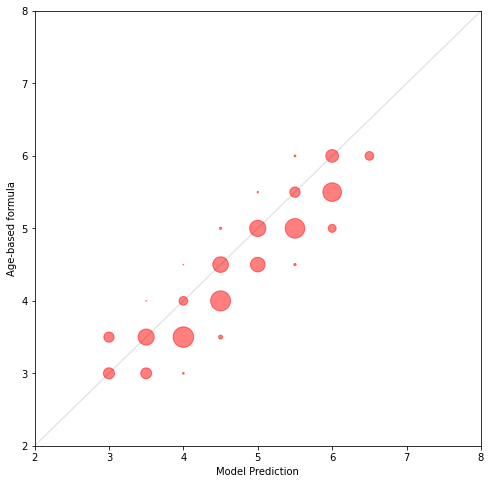

In [43]:
xvals = []
yvals = []
cvals = []
cvals_old = []
for x in np.arange(3, 8, 0.5):
    for y in np.arange(3, 8, 0.5):
        xvals.append(x)
        yvals.append(y)
        
        cvals.append(sum((y_pred == x) & (y_test_old == y)))
        cvals_old.append(sum((y_test_old == x) & (y_test == y)))
xvals = np.array(xvals)
yvals = np.array(yvals)
cvals = np.array(cvals) / 2
cvals_old = np.array(cvals_old) / 2

plt.figure(figsize=(8, 8))
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='red', alpha=0.5, s=cvals)
plt.xlabel('Model Prediction')
plt.ylabel('Age-based formula')
#lgnd = plt.legend()
#lgnd.legendHandles[0]._sizes = [30]
plt.plot([2,8], [2,8], 'k-', alpha=0.1)

Text(0, 0.5, 'age-based formula')

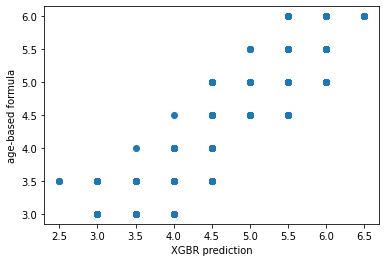

In [41]:
plt.scatter(y_pred, y_test_old)
plt.xlabel('XGBR prediction')
plt.ylabel('age-based formula')

# XGBr vs RF

In [ ]:
# xgbr model
xgbr = xgb.XGBRegressor()
xgbr.load_model('result/size/acc1-0.601_acc3-0.966_XGBR_10fold/model.model')
y_xgbr = xgbr.predict(x_test)

# RF model
rfr = pickle.load(open(f'result/size/acc1-0.595_acc3-0.963_RF_10fold/gridSearch','rb'))
y_rbr = rbr.predict(x_test_imputed).flatten()
#y_rbr = np.round(y_rbr * 2) / 2



In [3]:
dat = np.load(f'dataset/ETT_size.npz')
x, y = dat['x'], dat['y']
y_old  = dat['y_old']

# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

x_train: (27234, 5), x_test: (6808, 5)


In [7]:
# 0: age, 1: sex, 2: weight, 3: height, 4: cuffed
np.mean(np.isnan(x[:,3]))

0.024234768814993243

In [6]:
pd.DataFrame(x).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34042 entries, 0 to 34041
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       34042 non-null  float64
 1   1       34042 non-null  float64
 2   2       33603 non-null  float64
 3   3       33217 non-null  float64
 4   4       34042 non-null  float64
dtypes: float64(5)
memory usage: 1.3 MB


# 모델의 AGE 별 over/under estimate 비율

## Age 별 사용된 tube size (age-size plot)

### Age - size plot (uncuffed)

Text(0, 0.5, 'Size of uncuffed ETT used')

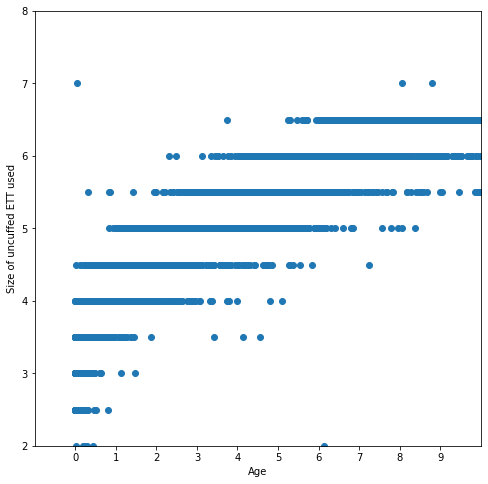

In [86]:
plt.figure(figsize=(8, 8))
plt.xticks(np.arange(0,10))
plt.xlim(-1, 10)
plt.ylim(2, 8)
plt.scatter(x_test[:,0][~cuff_mask], y_test[~cuff_mask])
plt.xlabel('Age')
plt.ylabel('Size of uncuffed ETT used')


### Uncuffed

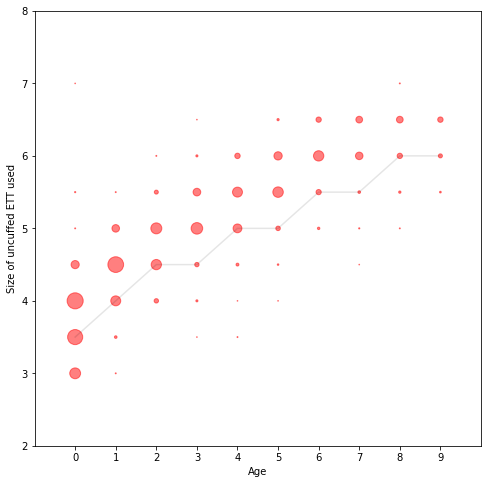

In [80]:
# Cole's formula 값
coles = [3.5, 4] + [math.floor((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4) for x in range(2,10)]
coles = np.array(coles)

xvals = []
yvals = []
cvals = []
cvals_old = []
x_age = np.array([math.floor(x) for x in x_test[:,0]])
cuff_mask = (x_test[:,4]==1)

for x in np.arange(0, 10, 1):
    for y in np.arange(3, 8, 0.5):
        xvals.append(x)
        yvals.append(y)
        
        cvals.append(sum((x_age[~cuff_mask] == x) & (y_test[~cuff_mask] == y)))
        #cvals_old.append(sum((y_test_old == x) & (y_test == y)))
xvals = np.array(xvals)
yvals = np.array(yvals)
cvals = np.array(cvals) / 2
#cvals_old = np.array(cvals_old) / 2

plt.figure(figsize=(8, 8))
plt.xticks(np.arange(0,10))
plt.xlim(-1, 10)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='red', alpha=0.5, s=cvals)
plt.xlabel('Age')
plt.ylabel('Size of uncuffed ETT used')
#lgnd = plt.legend()
#lgnd.legendHandles[0]._sizes = [30]
plt.plot(np.arange(0,10), coles, 'k-', alpha=0.1)
#plt.plot([2,10], [4.5,6.5], 'k-', alpha=0.1) # 4 + age/4

### Cuffed

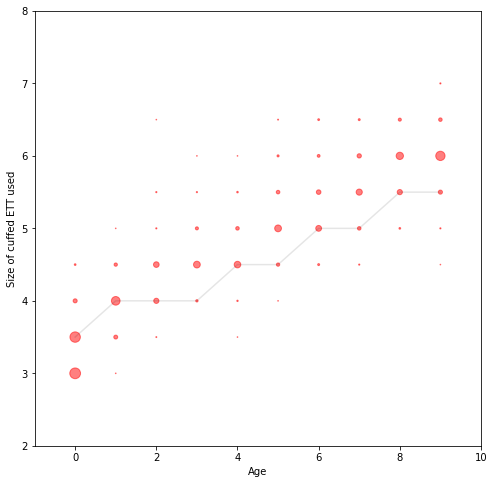

In [87]:
# Cole's formula 값
coles = [3.5, 4] + [math.floor((x / 4 + 3.5) * 2) / 2 if x >= 2 else (3.0 if x < 1 else 3.5) for x in range(2,10)]
coles = np.array(coles)

xvals = []
yvals = []
cvals = []
cvals_old = []
x_age = np.array([math.floor(x) for x in x_test[:,0]])

cuff_mask = (x_test[:,4]==1)

for x in np.arange(0, 10, 1):
    for y in np.arange(3, 8, 0.5):
        xvals.append(x)
        yvals.append(y)
        
        cvals.append(sum((x_age[cuff_mask] == x) & (y_test[cuff_mask] == y)))
        #cvals_old.append(sum((y_test_old == x) & (y_test == y)))
xvals = np.array(xvals)
yvals = np.array(yvals)
cvals = np.array(cvals) / 2
#cvals_old = np.array(cvals_old) / 2

plt.figure(figsize=(8, 8))
plt.xlim(-1, 10)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='red', alpha=0.5, s=cvals)
plt.xlabel('Age')
plt.ylabel('Size of cuffed ETT used')
#lgnd = plt.legend()
#lgnd.legendHandles[0]._sizes = [30]
#plt.plot([2,10], [4,6], 'k-', alpha=0.1) # 3.5 + age/4
plt.plot(np.arange(0,10), coles, 'k-', alpha=0.1)

In [ ]:
size_vals, cnt_vals = [], 
x_age = np.array([math.floor(x) for x in x_test[:,0]])
age_interval = ['0-1mo','1mo-1y'] + [f'{i}-{i+1}y' for i in range(1,10)]

for i in range(1,10):
    size_vals.append(np.mean(y_test[x_age==i]))

## Height - size plot

In [90]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

(array([  29.,    2.,  184.,  845., 1217., 1347., 1314., 1139.,  644.,
          86.]),
 array([  1.  ,  16.68,  32.36,  48.04,  63.72,  79.4 ,  95.08, 110.76,
        126.44, 142.12, 157.8 ]),
 <BarContainer object of 10 artists>)

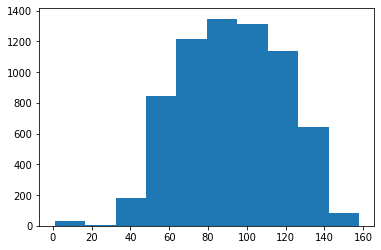

In [102]:
x_height = x_test_imputed[:,3]
x_height_ = x_height[x_height<200]
plt.hist(x_height_)

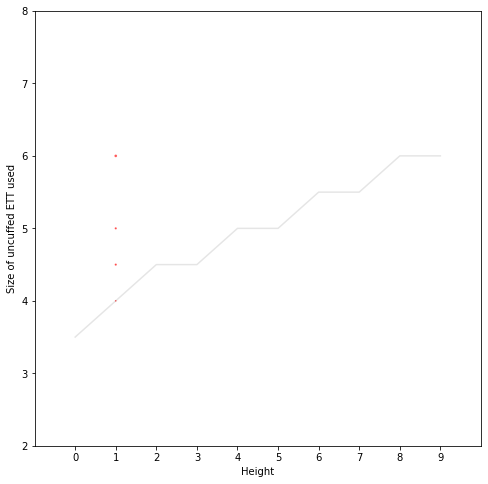

In [91]:
# Cole's formula 값
coles = [3.5, 4] + [math.floor((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4) for x in range(2,10)]
coles = np.array(coles)

xvals = []
yvals = []
cvals = []
cvals_old = []
x_age = np.array([math.floor(x) for x in x_test[:,0]])
cuff_mask = (x_test[:,4]==1)

for x in np.arange(0, 160, 10):
    for y in np.arange(3, 8, 0.5):
        xvals.append(x)
        yvals.append(y)
        
        cvals.append(sum((x_test_imputed[:,3][~cuff_mask] == x) & (y_test[~cuff_mask] == y)))
        #cvals_old.append(sum((y_test_old == x) & (y_test == y)))
xvals = np.array(xvals)
yvals = np.array(yvals)
cvals = np.array(cvals) / 2
#cvals_old = np.array(cvals_old) / 2

plt.figure(figsize=(8, 8))
plt.xticks(np.arange(0,10))
plt.xlim(-1, 10)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='red', alpha=0.5, s=cvals)
plt.xlabel('Height')
plt.ylabel('Size of uncuffed ETT used')
#lgnd = plt.legend()
#lgnd.legendHandles[0]._sizes = [30]
plt.plot(np.arange(0,10), coles, 'k-', alpha=0.1)
#plt.plot([2,10], [4.5,6.5], 'k-', alpha=0.1) # 4 + age/4

## Age-based model

In [54]:
# 계산
x_age = np.array([math.floor(x) for x in x_test[:,0]])
xvals = []
yvals = []
cvals = []
p_under, p_over, p_cor = [], [], []
po_under, po_over, po_cor = [], [], []
age_bins = []
age_interval = ['0-1mo','1mo-1y'] + [f'{i}-{i+1}y' for i in range(1,10)]

# 신생아
ag_mask = (x_test[:,0] < 1/12)
p_over.append(np.mean(y_test_old[ag_mask] > y_test[ag_mask]))
p_under.append(np.mean(y_test_old[ag_mask] < y_test[ag_mask]))
p_cor.append(np.mean(y_test_old[ag_mask] == y_test[ag_mask]))
age_bins.append(np.sum(ag_mask))

# 영아
ag_mask = (1/12 <= x_test[:,0]) & (x_test[:,0] < 1)
p_over.append(np.mean(y_test_old[ag_mask] > y_test[ag_mask]))
p_under.append(np.mean(y_test_old[ag_mask] < y_test[ag_mask]))
p_cor.append(np.mean(y_test_old[ag_mask] == y_test[ag_mask]))
age_bins.append(np.sum(ag_mask))

# 소아 (1~10살)
for x in np.arange(1, 10, 1):
    ag_mask = (x_age == x)
    p_over.append(np.mean(y_test_old[ag_mask] > y_test[ag_mask]))
    p_under.append(np.mean(y_test_old[ag_mask] < y_test[ag_mask]))
    p_cor.append(np.mean(y_test_old[ag_mask] == y_test[ag_mask]))
    age_bins.append(np.sum(ag_mask))
    
df_est = pd.DataFrame({'correct':p_cor, 'overestimate':p_over, 'underestimate':p_under, 'bins':age_bins}, index=age_interval)
df_est.round(2)

correct  overestimate  underestimate  bins
0-1mo      0.47          0.42           0.11   242
1mo-1y     0.35          0.11           0.54  1644
1-2y       0.22          0.02           0.76  1032
2-3y       0.41          0.06           0.53   654
3-4y       0.09          0.02           0.90   571
4-5y       0.44          0.04           0.52   557
5-6y       0.11          0.01           0.88   569
6-7y       0.26          0.04           0.70   481
7-8y       0.10          0.02           0.88   372
8-9y       0.32          0.05           0.63   348
9-10y      0.20          0.03           0.77   338

## XGBR

In [58]:
# xgbr 모델 예측값
xgbr = xgb.XGBRegressor()
xgbr.load_model('result/size/acc1-0.601_acc3-0.966_XGBR_10fold/model.model')

y_pred = xgbr.predict(x_test).flatten()
y_pred = np.round(y_pred * 2) / 2


# 계산
x_age = np.array([math.floor(x) for x in x_test[:,0]])
xvals = []
yvals = []
cvals = []
age_bins = []
p_under, p_over, p_cor = [], [], []
po_under, po_over, po_cor = [], [], []
age_interval = ['0-1mo','1mo-1y'] + [f'{i}-{i+1}y' for i in range(1,10)]

# 신생아
ag_mask = (x_test[:,0] < 1/12)
p_over.append(np.mean(y_pred[ag_mask] > y_test[ag_mask]))
p_under.append(np.mean(y_pred[ag_mask] < y_test[ag_mask]))
p_cor.append(np.mean(y_pred[ag_mask] == y_test[ag_mask]))
age_bins.append(np.sum(ag_mask))

# 영아
ag_mask = (1/12 <= x_test[:,0]) & (x_test[:,0] < 1)
p_over.append(np.mean(y_pred[ag_mask] > y_test[ag_mask]))
p_under.append(np.mean(y_pred[ag_mask] < y_test[ag_mask]))
p_cor.append(np.mean(y_pred[ag_mask] == y_test[ag_mask]))
age_bins.append(np.sum(ag_mask))

# 소아 (1~10살)
for x in np.arange(1, 10, 1):
    ag_mask = (x_age == x)
    p_over.append(np.mean(y_pred[ag_mask] > y_test[ag_mask]))
    p_under.append(np.mean(y_pred[ag_mask] < y_test[ag_mask]))
    p_cor.append(np.mean(y_pred[ag_mask] == y_test[ag_mask]))
    age_bins.append(np.sum(ag_mask))
    
df_est = pd.DataFrame({'correct':p_cor, 'overestimate':p_over, 'underestimate':p_under, 'bins':age_bins}, index=age_interval)
print(f'XGBR model prediction')
df_est.round(2)

XGBR model prediction


/home/painstudy/.local/lib/python3.8/site-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


correct  overestimate  underestimate  bins
0-1mo      0.57          0.21           0.22   242
1mo-1y     0.66          0.17           0.18  1644
1-2y       0.63          0.19           0.18  1032
2-3y       0.58          0.18           0.24   654
3-4y       0.62          0.16           0.22   571
4-5y       0.53          0.25           0.22   557
5-6y       0.56          0.22           0.21   569
6-7y       0.56          0.22           0.22   481
7-8y       0.51          0.16           0.33   372
8-9y       0.56          0.21           0.23   348
9-10y      0.67          0.18           0.14   338

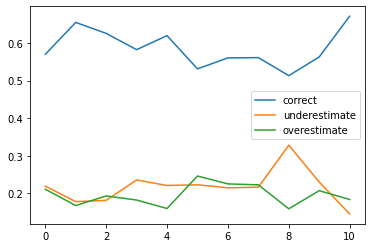

In [50]:
plt.plot(p_cor, label='correct')
plt.plot(p_under, label='underestimate')
plt.plot(p_over, label='overestimate')
plt.legend()